In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import os
import glob
import seaborn as sns
from typing import List, Optional
from sklearn.preprocessing import StandardScaler
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from typing import Tuple, Dict, List
from scipy.spatial.distance import cdist
# diet_paper_dir = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Matched/10Folds'
diet_paper_dir_ccs = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Matched_Oral_wCCS'
diet_paper_clustered = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Clustered_Reruns36'
diet_paper_dir = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Matched_Oral_r2_old_search_space_rerun'
diet_paper_dir_del = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper'
# diet_paper_dir = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/'
metabo_repeat_dir = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/'
figs_dir = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Figs_paper/'

In [2]:
def plot_auc_comparison(results_path, results_agb_path, output_path=None, min_prevalence=0, top_n=5, title="Comparison of AUC Values", use_adjust_text=True, use_prevalence=True, point_size=20):
    """
    Create a scatter plot comparing AUC values between original and AGB results.
    
    Parameters:
    -----------
    results_path : str
        Path to the original results CSV file
    results_agb_path : str
        Path to the AGB results CSV file
    output_path : str, optional
        Path to save the plot. If None, the plot will be displayed instead
    min_prevalence : float, optional
        Minimum prevalence threshold to include in the plot (default: 0)
    top_n : int, optional
        Number of top species to label (default: 5)
    title : str, optional
        Plot title
    use_adjust_text : bool, optional
        Whether to use adjust_text for label positioning
    use_prevalence : bool, optional
        Whether to use prevalence for point sizes and colors (default: True)
        
    Returns:
    --------
    fig, ax : tuple
        Matplotlib figure and axes objects
    """
    
    # Read the data
    results = pd.read_csv(results_path)
    results_agb = pd.read_csv(results_agb_path)
    
    # Filter for regression tasks and remove perfect AUC values
    results = results[
        (results['task'] == 'classification') & 
        (results['combined_auc'] < 1) &
        (~results['target'].isin(['age', 'gender', 'bmi'])) &
        (results['prevalence'] <= 0.95)
    ]
    
    results_agb = results_agb[
        (results_agb['task'] == 'classification') & 
        (~results_agb['target'].isin(['age', 'gender', 'bmi']))
    ]
    
    # Merge the dataframes on target
    merged_data = pd.merge(
        results[['target', 'combined_auc', 'prevalence']], 
        results_agb[['target', 'combined_auc']],
        on='target',
        suffixes=('', '_agb')
    )
    
    # Filter by minimum prevalence if specified
    if min_prevalence > 0:
        merged_data = merged_data[merged_data['prevalence'] >= min_prevalence]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    if use_prevalence:
        # Calculate point sizes (scale prevalence to reasonable dot sizes)
        sizes = merged_data['prevalence'] * 500
        colors = merged_data['prevalence']
        alpha = 0.5
        title_suffix = '\nPoint size and color indicate prevalence'
    else:
        # Use fixed size and color for all points
        sizes = point_size
        colors = 'blue'
        alpha = 0.6
        title_suffix = ''
    
    # Create scatter plot
    scatter = ax.scatter(
        merged_data['combined_auc_agb'],
        merged_data['combined_auc'],
        s=sizes,
        alpha=alpha,
        c=colors,
        cmap='viridis' if use_prevalence else None
    )
    
    # Add reference line (y=x)
    min_val = min(merged_data['combined_auc'].min(), merged_data['combined_auc_agb'].min())
    max_val = max(merged_data['combined_auc'].max(), merged_data['combined_auc_agb'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='y=x')
    
    # Customize the plot
    ax.set_xlabel('Age + BMI + Gender (AGB) -  AUC')
    ax.set_ylabel('Metabolites + AGB -   AUC')
    ax.set_title(f'{title}{title_suffix}')
    
    # Add colorbar only if using prevalence
    if use_prevalence:
        cbar = plt.colorbar(scatter)
        cbar.set_label('Prevalence')
    
    # Add grid
    ax.grid(True, alpha=0.5)
    
    # Make plot square with equal axes
    ax.set_aspect('equal')
    
    # Filter out GGB species and get top 5 by original AUC
    filtered_data = merged_data[~merged_data['target'].str.contains('GGB')]
    top_n_data = filtered_data.nlargest(top_n, 'combined_auc')
    
    # Define fixed offsets for annotations
    offsets = [
        (10, 10),   # up-right
        (-10, 10),  # up-left
        (10, -10),  # down-right
        (-10, -10), # down-left
        (15, 0)     # right
    ]
    
    if use_adjust_text:
        texts = [ax.text(row['combined_auc_agb'], row['combined_auc'], row['target']) 
                for _, row in top_n_data.iterrows()]
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
    else: 
        for i, (_, row) in enumerate(top_n_data.iterrows()):
            species_name = row['target'].replace('s__', '').replace('_', ' ')
            dx, dy = offsets[i % len(offsets)]
            
            ax.annotate(species_name,
                       (row['combined_auc_agb'], row['combined_auc']),
                       xytext=(dx, dy), textcoords='offset points',
                       fontsize=10, alpha=0.8,
                       ha='left' if dx > 0 else 'right',
                       arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save or display the plot
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

In [3]:
def plot_r2_comparison(results_path, results_agb_path, output_path=None, min_prevalence=0, use_prevalence=True, title="Comparison of R² Values",
                       top_n=5, lim_y=None):
    """
    Create a scatter plot comparing R² values between original and AGB results for regression tasks.
    
    Parameters:
    -----------
    results_path : str
        Path to the original results CSV file
    results_agb_path : str
        Path to the AGB results CSV file
    output_path : str, optional
        Path to save the plot. If None, the plot will be displayed instead
    min_prevalence : float, optional
        Minimum prevalence threshold to include in the plot (default: 0)
    use_prevalence : bool, optional
        If True, scale points by prevalence. If False, use regular scatter plot (default: True)
        
    Returns:
    --------
    fig, ax : tuple
        Matplotlib figure and axes objects
    """
    
    # Read the data
    results = pd.read_csv(results_path)
    results_agb = pd.read_csv(results_agb_path)
    
    # Filter for regression tasks and remove perfect R² values
    results = results[
        (results['task'] == 'regression') & 
        (results['combined_r2'] < 1) &
        (~results['target'].isin(['age', 'gender', 'bmi']))
    ]
    
    results_agb = results_agb[
        (results_agb['task'] == 'regression') & 
        (~results_agb['target'].isin(['age', 'gender', 'bmi']))
    ]
    
    # Merge the dataframes on target
    if use_prevalence:
        merged_data = pd.merge(
            results[['target', 'combined_r2', 'prevalence']], 
            results_agb[['target', 'combined_r2']],
            on='target',
            suffixes=('', '_agb')
        )

        # Filter by minimum prevalence if specified
        if min_prevalence > 0:
            merged_data = merged_data[merged_data['prevalence'] >= min_prevalence]
    else:
        merged_data = pd.merge(
            results[['target', 'combined_r2']], 
            results_agb[['target', 'combined_r2']],
            on='target',
            suffixes=('', '_agb')
        )
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    if use_prevalence:
        # Calculate point sizes (scale prevalence to reasonable dot sizes)
        sizes = merged_data['prevalence'] * 500
        
        # Create scatter plot with prevalence scaling
        scatter = ax.scatter(
            merged_data['combined_r2_agb'],
            merged_data['combined_r2'],
            s=sizes,
            alpha=0.5,
            c=merged_data['prevalence'],
            cmap='viridis'
        )
        
        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Prevalence')
        
        title = f'{title}\nPoint size and color indicate prevalence'
    else:
        # Create regular scatter plot
        scatter = ax.scatter(
            merged_data['combined_r2_agb'],
            merged_data['combined_r2'],
            alpha=0.5,
            c='blue'
        )
        title = title
    
    # Add reference line (y=x)
    min_val = min(merged_data['combined_r2'].min(), merged_data['combined_r2_agb'].min())
    max_val = max(merged_data['combined_r2'].max(), merged_data['combined_r2_agb'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='y=x')
    
    # Customize the plot
    ax.set_xlabel('Age + Gender + BMI (AGB) -  R²')
    ax.set_ylabel('Metabolites + AGB -  R²')
    ax.set_title(title)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Make plot square with equal axes
    ax.set_aspect('equal')
    
    # Filter out GGB species and get top 5 by original R²
    filtered_data = merged_data[~merged_data['target'].str.contains('GGB')]
    top_n = filtered_data.nlargest(top_n, 'combined_r2')
    
    # Define fixed offsets for annotations
    offsets = [
        (15, 15),   # up-right
        (-15, 15),  # up-left
        (15, -15),  # down-right
        (-15, -15), # down-left
        (20, 0),     # right
    ]
    
    #     # Define fixed offsets for annotations with more spacing
    # offsets = [
    #     (20, 20),    # up-right
    #     (-20, 40),   # up-left
    #     (30, -20),   # down-right
    #     (-30, -40),  # down-left
    #     (40, 0)      # right
    # ]
    
    # for i, (_, row) in enumerate(top_n.iterrows()):
    #     # Extract species name from target (remove 's__' prefix)
    #     species_name = row['target'].replace('s__', '').replace('_', ' ')
    #     # Get the offset for this annotation
    #     dx, dy = offsets[i % len(offsets)]
    #     
    #     ax.annotate(species_name,
    #                (row['combined_r2_agb'], row['combined_r2']),
    #                xytext=(dx, dy), textcoords='offset points',
    #                fontsize=8, alpha=0.8,
    #                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
    #                ha='left' if dx > 0 else 'right',
    #                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
        
    # use adjust_text to prevent overlapping annotations
    texts = [ax.text(row['combined_r2_agb'], row['combined_r2'], row['target']) for _, row in top_n.iterrows()]
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
    
    # # Add legend
    # ax.legend()
    if lim_y:
        plt.ylim(-0.1, lim_y)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save or display the plot
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

FileNotFoundError: [Errno 2] No such file or directory: '/home/davidkro/PycharmProjects/IBD/Metabolomics/diet_paper/figs/y_medical_conditions_consolidated_classification.png'

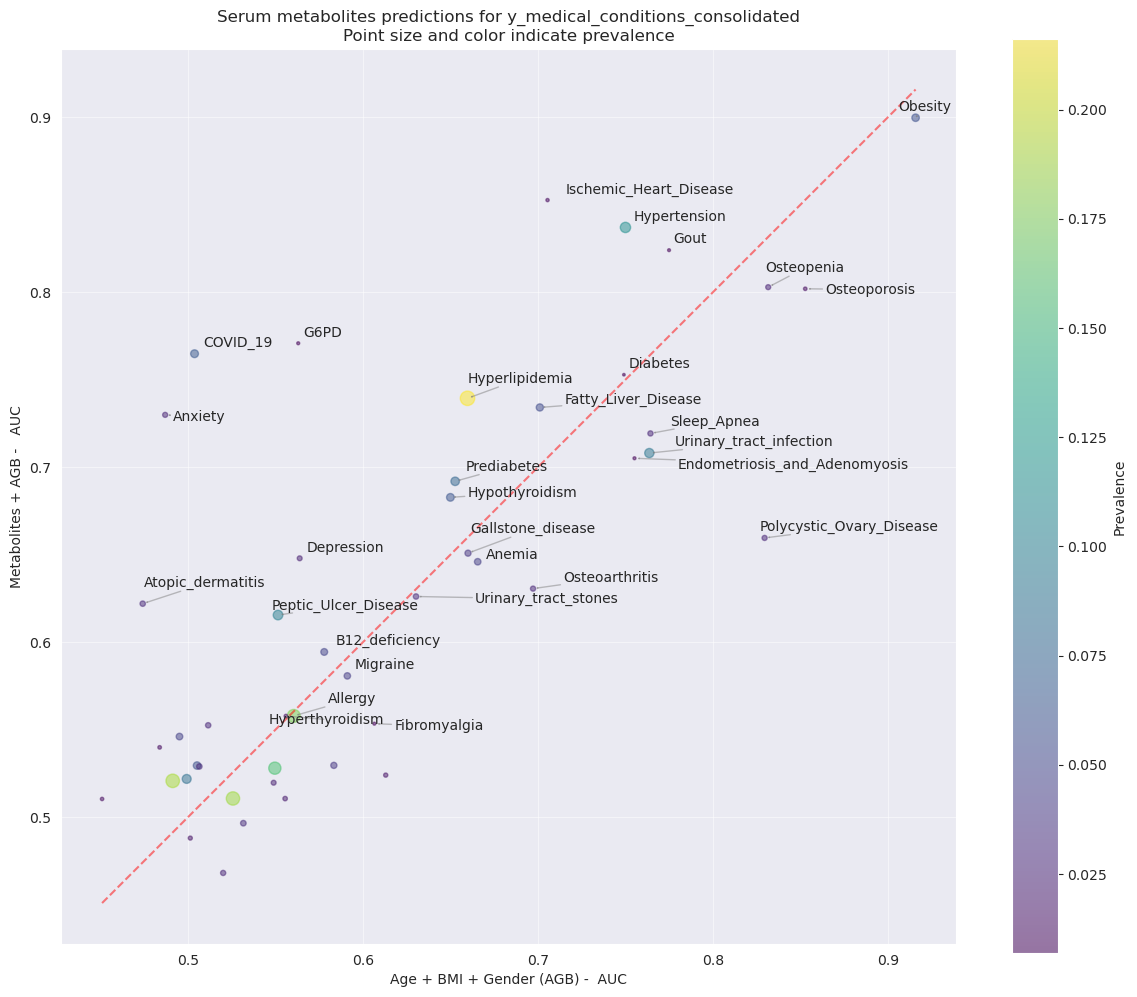

In [4]:
x_dir_name = 'x_medical_conditions_consolidated'
y_dir_name = 'y_medical_conditions_consolidated'
results_path = f"/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/{x_dir_name}/{y_dir_name}/final_results.csv"
results_agb_path = f"/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/{x_dir_name}/{y_dir_name}/only_AGB/final_results.csv"

# Create scatter plot for r2 values
fig, ax = plot_auc_comparison(
    results_path,
    results_agb_path,
    output_path=f"./figs/{y_dir_name}_classification.png",
    top_n=30,
    title=f"Serum metabolites predictions for {y_dir_name}",
    use_adjust_text=True,
    use_prevalence=True
)

In [446]:
x_dir_name = 'x_prs_data_sig_diet_nominal'
y_dir_name = 'y_prs_diet_scores'
results_path = f"/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Matched_Oral_r2_old_search_space_rerun/{x_dir_name}/{y_dir_name}/final_results.csv"
results_agb_path = f"/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Genetics/x_prs_data_sig_diet/{y_dir_name}/only_AGB/final_results.csv"
# results_agb_path = f"/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/x_diet_adherence/{y_dir_name}/only_AGB/final_results.csv"

# Create scatter plot for r2 values
fig, ax = plot_r2_comparison(
    results_path,
    results_agb_path,
    output_path=f"./figs/{y_dir_name}.png",
    top_n=30,
    title=f"Serum metabolites predictions for {y_dir_name}",
    use_prevalence=False,
    lim_y=None
)

FileNotFoundError: [Errno 2] No such file or directory: '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Matched_Oral_r2_old_search_space_rerun/x_prs_data_sig_diet/y_prs_diet_scores/final_results.csv'

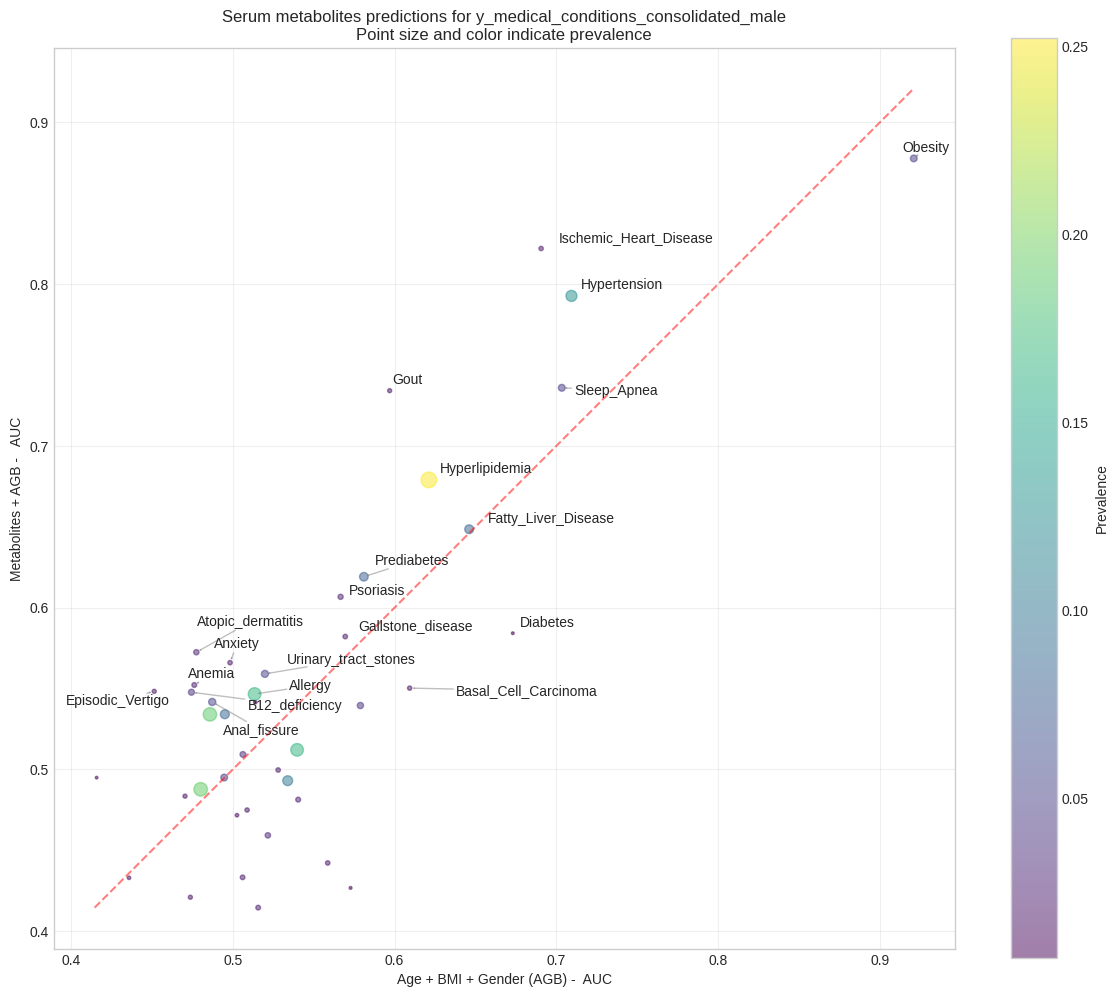

In [38]:
dir_name = 'y_medical_conditions_consolidated_male'
results_path = f"/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/dev_refactored/SERRF_runs_Identified_40/{dir_name}/final_results.csv"
results_agb_path = f"/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/dev_refactored/SERRF_runs_Identified_40/{dir_name}/only_AGB/final_results.csv"

# Create scatter plot for r2 values
fig, ax = plot_auc_comparison(
    results_path,
    results_agb_path,
    output_path=f"./figs/{dir_name}_SERRF_Identified_40.png",
    top_n=20,
    title=f"Serum metabolites predictions for {dir_name}",
    use_adjust_text=True,
    use_prevalence=True,
    # point_size=50
)

## Invesitgate False Predictions

In [39]:
# import predictions
keto_predictions = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/dev_refactored/AGB_runs/y_dietary_habits/results/keto/predictions.csv', index_col=0)

In [40]:
dietary_features = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/Xs/dietary_features_baseline.csv', index_col=0)

In [41]:
keto_predictions_merged = keto_predictions.join(dietary_features, how='inner')

In [42]:
# import medications
medications_baseline = pd.read_excel('/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/Xs/baseline_medicaitons_all.xlsx', index_col=0)
medications_baseline.set_index('RegistrationCode', inplace=True)
medications_df = medications_baseline.copy()

In [43]:
keto_predictions_merged_meds = keto_predictions_merged.join(medications_baseline, how='inner')

In [44]:
keto_predictions_merged.head()

,true_values,predictions,med_score_per_day,paleo_score_per_day,vegetarian_score_per_day,wfpb_score_per_day,vegan_score_per_day,wfab_score_per_day,fermented_score_per_day,Fasting_window,plant_foods_per_week,pct_carb_calories,pct_protein_calories,pct_fat_calories
10K_1012027362,0.0,0.000383,0.692607,0.377877,0.754935,0.583802,0.602664,0.142672,0.000000,13.047436,34.0,0.487775,0.212418,0.307513
10K_1012400211,0.0,0.000049,0.253241,0.092645,0.486856,0.186186,0.245146,0.055569,0.000722,10.375556,21.0,0.491979,0.212319,0.296152
10K_1038221395,0.0,0.000035,0.440658,0.316568,0.559483,0.428943,0.476493,0.095441,0.008070,10.584524,46.0,0.517730,0.177726,0.317467
10K_1047120060,0.0,0.001442,0.191232,0.144017,0.371086,0.122694,0.258001,0.116213,0.000000,11.346667,24.0,0.424718,0.195578,0.336558
10K_1098823023,0.0,0.000026,0.416262,0.243919,0.472559,0.323474,0.323550,0.086094,0.014730,12.726923,36.0,0.446186,0.166808,0.398589


In [45]:
# Step 1: Create a boolean column for Hyperlipoproteinaemia medication presence
sorted_df['Hyperlip_Meds'] = sorted_df.index.isin(
    medications_df[medications_df['Conditions'] == 'Hyperlipoproteinaemia'].index
)

# Step 2: Plot with Seaborn scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sorted_df,
    x='pct_fat_calories',
    y='predictions',
    hue='true_values',
    style='Hyperlip_Meds',  # Use boolean column for style
    markers={True: '^', False: 'o'},  # Map True to triangles, False to circles
    alpha=0.8
)
# Save the plot
plt.savefig('./figs/pct_fat_calories_vs_predictions_keto_1.png', dpi=300, bbox_inches='tight')

NameError: name 'sorted_df' is not defined

In [ ]:
# analyze pct_fat_calories
pct_fat_preds = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/dev_refactored/AGB_runs/y_dietary_features/results/pct_fat_calories/predictions.csv', index_col=0)

In [ ]:
pct_fat_preds.columns

In [ ]:
pct_fat_preds['Hyperlip_Meds'] = pct_fat_preds.index.isin(
    medications_df[medications_df['Conditions'] == 'Hyperlipoproteinaemia'].index)

In [ ]:
# plot a scatter plot of predictions vs true values color coded by Hyperlip_Meds
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pct_fat_preds,
    x='true_values',
    y='predictions',
    hue='Hyperlip_Meds',
    style='Hyperlip_Meds',
    markers={True: '^', False: 'o'},
    alpha=0.8
)
plt.title('pct_fat_calories predicted by metabolites+AGB')

plt.savefig('./figs/pct_fat_calories_vs_predictions.png', dpi=300, bbox_inches='tight')

In [138]:
import  matplotlib.patches as mpatches
import matplotlib.colors as mcolors
def compare_model_performance(model_paths, target_dirs=None, model_names=None,
                              color_palette="viridis", top_n=10, true_labels_path=None, x_labels=None, show_legend=True):
    """
    Compare R² scores between N models across different targets with bars and beeswarm plots.
    If target_dirs is None, will automatically discover all target directories in the first model's results folder.
    Targets are sorted alphabetically unless top_n is specified with true_labels_path.
    
    Parameters:
    -----------
    model_paths : list
        List of paths to the model directories
    target_dirs : list, optional
        List of target subdirectory names to compare. If None, will discover all directories
        in the first model's results directory.
    model_names : list, optional
        Names for the models in the plot. If None, will use "Model 1", "Model 2", etc.
    color_palette : str or list, optional
        Color palette to use for the plots. Can be any valid seaborn color palette name
        or a list of colors. Default is "viridis".
    top_n : int, optional
        Number of top targets to display, sorted by median value in true labels.
        Default is 10. If None or 0, all targets are shown in alphabetical order.
    true_labels_path : str, optional
        Path to the true labels file for calculating medians.
        Required if top_n is specified.
    x_labels : list, optional
        Custom labels for the x-axis. If provided, must match the length of target_dirs.
        If None, will use the target directory names with underscores replaced by spaces.
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The comparison plot
    """
    n_models = len(model_paths)
    
    # Set default model names if not provided
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(n_models)]
    elif len(model_names) != n_models:
        raise ValueError(f"Number of model names ({len(model_names)}) must match number of model paths ({n_models})")
    
    # Auto-discover target directories if not provided
    if target_dirs is None:
        # Use the first model's results directory as reference
        results_path = os.path.join(model_paths[0], 'results')
        if not os.path.exists(results_path):
            raise ValueError(f"Results directory not found at {results_path}")
        
        # Get all subdirectories in the results folder
        target_dirs = [d for d in os.listdir(results_path) 
                      if os.path.isdir(os.path.join(results_path, d))]
        
        if not target_dirs:
            raise ValueError(f"No target directories found in {results_path}")
        
        print(f"Discovered target directories: {', '.join(target_dirs)}")
    
    # Validate x_labels if provided
    if x_labels is not None:
        if len(x_labels) != len(target_dirs):
            raise ValueError(f"Number of x-axis labels ({len(x_labels)}) must match number of targets ({len(target_dirs)})")
    
    # Sort targets by median values if top_n is specified, otherwise sort alphabetically
    if top_n and true_labels_path:
        if not os.path.exists(true_labels_path):
            raise ValueError(f"True labels file not found at {true_labels_path}")
        
        # Read true labels
        true_labels = pd.read_csv(true_labels_path, index_col=0)
        
        # Calculate median for each column
        medians = true_labels.median()
        
        # Sort columns by median and get top N
        top_columns = medians.sort_values(ascending=False).head(top_n).index.tolist()
        
        # Filter target_dirs to only include top columns
        original_order = target_dirs.copy()
        target_dirs = [t for t in target_dirs if t in top_columns]
        
        # Sort target_dirs by median value
        target_dirs = sorted(target_dirs, key=lambda x: medians[x], reverse=True)
        
        # Update x_labels to match new target order if provided
        if x_labels is not None:
            x_labels = [x_labels[original_order.index(t)] for t in target_dirs]
        
        if not target_dirs:
            raise ValueError("No matching targets found in true labels file")
        
        print(f"Selected top {len(target_dirs)} targets based on median values")
    else:
        if x_labels is not None:
            if len(x_labels) != len(target_dirs):
                raise ValueError(
                    f"Number of x-axis labels ({len(x_labels)}) must match number of targets ({len(target_dirs)})"
                )
            # dictionary: 'target_dir_name' ? 'pretty label'
            x_label_lookup = dict(zip(target_dirs, x_labels))
        else:
            x_label_lookup = None
    
    # Store results for plotting and statistical testing
    summary_results = []  # For bar plots
    fold_results = []     # For beeswarm plots
    model_data_by_target = {}  # For statistical testing - now preserving fold pairing
    
    # Process each target directory
    for target in target_dirs:
        model_data_by_target[target] = {}
        
        # First pass: collect all fold data with fold indices
        for model_path, model_name in zip(model_paths, model_names):
            target_path = os.path.join(model_path, 'results', target)
            
            if not os.path.exists(target_path):
                print(f"Warning: Target directory {target} not found for {model_name}")
                print(f"{target_path}")
                continue
            
            cv_files = glob.glob(os.path.join(target_path, "*cv_results*.csv"))
            if not cv_files:
                print(f"No CV results found for {model_name} in {target}")
                continue
                
            cv_data = pd.read_csv(cv_files[0])
            
            r2_col = [col for col in cv_data.columns if 'r2' in col.lower()]
            if not r2_col:
                print(f"No R² column found for {model_name} in {target}")
                continue
            
            # Store values with fold indices
            model_data_by_target[target][model_name] = {
                'values': cv_data[r2_col[0]].values,
                'fold_indices': range(len(cv_data[r2_col[0]].values))
            }
            
            # Store summary results for bars
            summary_results.append({
                'Target': target,
                'Model': model_name,
                'R2_median': np.median(cv_data[r2_col[0]].values),
                'R2_std': np.std(cv_data[r2_col[0]].values)
            })
            
            # Store individual fold results for beeswarm
            for fold_idx, r2_value in enumerate(cv_data[r2_col[0]].values):
                fold_results.append({
                    'Target': target,
                    'Model': model_name,
                    'Fold': fold_idx,
                    'R2': r2_value
                })
    
    if not summary_results:
        raise ValueError("No valid results found for any model/target combination")
    
    # Convert results to DataFrames
    summary_df = pd.DataFrame(summary_results)
    fold_df = pd.DataFrame(fold_results)
    
    from scipy import stats
    from statsmodels.stats.multitest import multipletests
    significance_annotations = {}
    
    # Store all p-values for FDR correction
    all_comparisons = []
    
    # First pass: collect all p-values for adjacent models only
    for target in target_dirs:
        for i in range(len(model_names) - 1):  # Only compare adjacent models
            model1 = model_names[i]
            model2 = model_names[i + 1]
            
            if target in model_data_by_target:
                model1_data = model_data_by_target[target].get(model1)
                model2_data = model_data_by_target[target].get(model2)
                
                if model1_data is not None and model2_data is not None:
                    n_folds = min(len(model1_data['values']), len(model2_data['values']))
                    data1 = model1_data['values'][:n_folds]
                    data2 = model2_data['values'][:n_folds]
                    
                    statistic, p_value = stats.wilcoxon(data1, data2, alternative='two-sided')
                    all_comparisons.append({
                        'target': target,
                        'model1': model1,
                        'model2': model2,
                        'p_value': p_value,
                        'data1': data1,
                        'data2': data2
                    })
    
    # Apply FDR correction
    if all_comparisons:
        _, p_corrected, _, _ = multipletests(
            [comp['p_value'] for comp in all_comparisons],
            alpha=0.05,
            method='fdr_bh'
        )
        
        # Update p-values with corrected values
        for comp, p_adj in zip(all_comparisons, p_corrected):
            comp['p_adjusted'] = p_adj
    
    # Process results with FDR-corrected p-values
    for comp in all_comparisons:
        target = comp['target']
        if target not in significance_annotations:
            significance_annotations[target] = []
        
        p_adj = comp['p_adjusted']
        
        # Determine significance level with adjusted p-value
        if p_adj < 0.001:
            sig = '***'
        elif p_adj < 0.01:
            sig = '**'
        elif p_adj < 0.05:
            sig = '*'
        else:
            continue  # Skip non-significant results
        
        # Determine better model
        better_model = comp['model1'] if np.median(comp['data1']) > np.median(comp['data2']) else comp['model2']
        
        significance_annotations[target].append({
            'models': (comp['model1'], comp['model2']),
            'p_value': p_adj,
            'significance': sig,
            'better_model': better_model
        })
        
        # print(f"\nTarget: {target}")
        # print(f"Comparison: {comp['model1']} vs {comp['model2']}")
        # print(f"Original p-value: {comp['p_value']:.4f}")
        # print(f"FDR-adjusted p-value: {p_adj:.4f}")
        # print(f"Significance: {sig}")
        
   # Create the plot
    fig_width = max(8, len(target_dirs) * 2)
    plt.figure(figsize=(fig_width, 4))
    
    # Set white background with grid
    plt.gca().set_facecolor('white')
    plt.gcf().set_facecolor('white')
    plt.grid(True, alpha=0.5, color='#E0E0E0', zorder=0)
    
    # Get color palette
    base_colors  = ['#ffd966', '#f99f72', '#e37c80', '#c38ac3', '#8560b3'][:n_models]
    colors = base_colors[::-1][:n_models]
    
    # Create grouped bar plot with adjusted widths for separation
    total_width = 0.8
    bar_width = (total_width / n_models) * 0.85
    
    # Get unique targets and models
    targets = summary_df['Target'].unique()
    models = summary_df['Model'].unique()
    
    # Set positions for bars
    x = np.arange(len(targets))
    
    # Plot bars and beeswarm for each model
    legend_handles = []  # Store handles for legend
    for i, (model, color) in enumerate(zip(models, colors)):
        model_data = summary_df[summary_df['Model'] == model]
        offset = (i - (n_models-1)/2) * (total_width / n_models)
        
        # Plot bars with alpha
        bars = plt.bar(x + offset,
               model_data['R2_median'],
               bar_width,
               alpha=0.7,
               color=color,
               edgecolor='none')
        
        # Create solid color patch for legend
        solid_patch = mpatches.Patch(color=color, label=model)
        legend_handles.append(solid_patch)
        
        def darker(col_hex, amount=0.2):
            """Return a darker shade of a hex- or named-color string."""
            r, g, b = mcolors.to_rgb(col_hex)   # each in 0-1 range
            return (max(0, r - amount),
                    max(0, g - amount),
                    max(0, b - amount))
    
        # Add error bars
        error_bar_color = error_bar_color = darker(color, 0.2)
        plt.errorbar(x + offset,
                    model_data['R2_median'],
                    yerr=model_data['R2_std'],
                    fmt='none',
                    capsize=4,
                    capthick=1.5,
                    elinewidth=1.5,
                    color=error_bar_color,
                    alpha=0.7,
                    zorder=2)
        
        
        # Add beeswarm plots
        for j, target in enumerate(targets):
            target_data = fold_df[(fold_df['Model'] == model) & 
                                (fold_df['Target'] == target)]
            
            if not target_data.empty:
                x_pos = j + offset
                y_vals = target_data['R2'].values
                x_jitter = np.random.normal(0, bar_width/8, size=len(y_vals))
                
                # Create scatter points with gradient alpha
                density = stats.gaussian_kde(y_vals)
                density_vals = density(y_vals)
                density_vals = (density_vals - density_vals.min()) / (density_vals.max() - density_vals.min())
                
                for y_val, x_jit, dens in zip(y_vals, x_jitter, density_vals):
                    plt.scatter(x_pos + x_jit, y_val,
                              alpha=max(0.6, min(0.9, dens)),
                              s=20,
                              color=color,
                              edgecolor='none',
                              zorder=3)
    
    # Add significance annotations
    for target_idx, target in enumerate(target_dirs):
        if target in significance_annotations:
            base_y_offset = 0.06
            extra_offset = 0.02  # Additional offset between first and second bars
            
            for i, annotation in enumerate(significance_annotations[target]):
                model1, model2 = annotation['models']
                sig = annotation['significance']
                better_model = annotation['better_model']
                
                # Get x-positions for the two models
                idx1 = model_names.index(model1)
                idx2 = model_names.index(model2)
                
                # Only draw annotations for adjacent models
                if abs(idx1 - idx2) == 1:
                    x1 = target_idx + (idx1 - (n_models-1)/2) * (total_width / n_models)
                    x2 = target_idx + (idx2 - (n_models-1)/2) * (total_width / n_models)
                    
                    # Find the maximum y-value from beeswarm points for both models
                    model1_points = fold_df[(fold_df['Target'] == target) & (fold_df['Model'] == model1)]['R2'].max()
                    model2_points = fold_df[(fold_df['Target'] == target) & (fold_df['Model'] == model2)]['R2'].max()
                    max_y = max(model1_points, model2_points)
                    
                    # Calculate y_offset based on annotation position
                    if i == 1:
                        current_y_offset = base_y_offset  + 0.05
                    else:
                        current_y_offset = base_y_offset 
                    
                    bar_height = max_y + current_y_offset
                    vertical_line_length = 0.008  # Very short vertical lines
                    
                    # Draw horizontal connecting line
                    plt.plot([x1, x2], [bar_height, bar_height],
                            color='#808080', linewidth=0.8,)
                    
                    # Draw short vertical lines
                    plt.plot([x1, x1], [bar_height - vertical_line_length, bar_height], 
                            color='#808080', linewidth=0.8,)
                    plt.plot([x2, x2], [bar_height - vertical_line_length, bar_height], 
                            color='#808080', linewidth=0.8, )
                    
                    # Add significance stars
                    text_x = (x1 + x2) / 2
                    plt.text(text_x, bar_height + 0.005, f"{sig}",
                            ha='center', va='bottom', color='#808080',
                            fontsize=8, fontweight='bold')
    
    # Customize plot appearance
    plt.xlabel('')
    plt.ylabel('R² Score', fontsize=11, fontweight='medium')
    
    if x_label_lookup is not None:
        display_labels = [x_label_lookup[t] for t in targets]
    else:
        display_labels = [t.replace('_', ' ') for t in targets]
    
    plt.xticks(x, display_labels, rotation=45, ha='right', fontsize=10)
    
    # Adjust y-axis
    curr_ylim = plt.ylim()
    plt.ylim(0, max(curr_ylim[1], 0.6 + max([len(anns) for anns in significance_annotations.values()]) * 0.03))
    plt.yticks(fontsize=10)
    
    # 
    
    if show_legend:
        # Place legend horizontally below the figure
        legend = plt.legend(handles=legend_handles,
                          bbox_to_anchor=(0.5, -0.28),
                          loc='center',
                          ncol=len(models),  # Place all items in one row
                          frameon=True,
                          fancybox=True,
                          framealpha=0.95,
                          edgecolor='#cccccc',
                          fontsize=10)
        
        # Adjust figure bottom margin to make room for legend
        plt.gcf().subplots_adjust(bottom=0.2)
    
    # Style spines
    # for spine in plt.gca().spines.values():
    #     spine.set_color('#cccccc')
    #     spine.set_linewidth(0.8)
        
        # Remove borders (spines)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    
    return plt.gcf()

In [61]:
def compare_model_performance_transposed(model_paths, target_dirs=None, model_names=None, title="Model Performance Comparison",
                              color_palette="viridis", top_n=10, true_labels_path=None, x_labels=None, show_legend=True):
    """
    Compare R² scores between N models across different targets with bars and beeswarm plots.
    If target_dirs is None, will automatically discover all target directories in the first model's results folder.
    Targets are sorted alphabetically unless top_n is specified with true_labels_path.
    
    Parameters:
    -----------
    model_paths : list
        List of paths to the model directories
    target_dirs : list, optional
        List of target subdirectory names to compare. If None, will discover all directories
        in the first model's results directory.
    model_names : list, optional
        Names for the models in the plot. If None, will use "Model 1", "Model 2", etc.
    title : str, optional
        Title for the plot
    color_palette : str or list, optional
        Color palette to use for the plots. Can be any valid seaborn color palette name
        or a list of colors. Default is "viridis".
    top_n : int, optional
        Number of top targets to display, sorted by median value in true labels.
        Default is 10. If None or 0, all targets are shown in alphabetical order.
    true_labels_path : str, optional
        Path to the true labels file for calculating medians.
        Required if top_n is specified.
    x_labels : list, optional
        Custom labels for the x-axis. If provided, must match the length of target_dirs.
        If None, will use the target directory names with underscores replaced by spaces.
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The comparison plot
    """
    n_models = len(model_paths)
    
    # Set default model names if not provided
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(n_models)]
    elif len(model_names) != n_models:
        raise ValueError(f"Number of model names ({len(model_names)}) must match number of model paths ({n_models})")
    
    # Auto-discover target directories if not provided
    if target_dirs is None:
        # Use the first model's results directory as reference
        results_path = os.path.join(model_paths[0], 'results')
        if not os.path.exists(results_path):
            raise ValueError(f"Results directory not found at {results_path}")
        
        # Get all subdirectories in the results folder
        target_dirs = [d for d in os.listdir(results_path) 
                      if os.path.isdir(os.path.join(results_path, d))]
        
        if not target_dirs:
            raise ValueError(f"No target directories found in {results_path}")
        
        print(f"Discovered target directories: {', '.join(target_dirs)}")
    
    # ??? capture user labels right away ?????????????????????????????????
    if x_labels is not None:
        if len(x_labels) != len(target_dirs):
            raise ValueError(
                f"Number of x-axis labels ({len(x_labels)}) must match number of targets ({len(target_dirs)})"
            )
        # dictionary: 'target_dir_name' ? 'pretty label'
        x_label_lookup = dict(zip(target_dirs, x_labels))
    else:
        x_label_lookup = None
    
    # Sort targets by median values if top_n is specified, otherwise sort alphabetically
    if top_n and true_labels_path:
        if not os.path.exists(true_labels_path):
            raise ValueError(f"True labels file not found at {true_labels_path}")
        
        # Read true labels
        true_labels = pd.read_csv(true_labels_path, index_col=0)
        
        # Calculate median for each column
        medians = true_labels.median()
        
        # Sort columns by median and get top N
        top_columns = medians.sort_values(ascending=False).head(top_n).index.tolist()
        
        # Filter target_dirs to only include top columns
        original_order = target_dirs.copy()
        target_dirs = [t for t in target_dirs if t in top_columns]
        
        # Sort target_dirs by median value
        target_dirs = sorted(target_dirs, key=lambda x: medians[x], reverse=True)
        
        # Update x_labels to match new target order if provided
        if x_labels is not None:
            x_labels = [x_labels[original_order.index(t)] for t in target_dirs]
        
        if not target_dirs:
            raise ValueError("No matching targets found in true labels file")
        
        print(f"Selected top {len(target_dirs)} targets based on median values")
    else:
        # Sort targets alphabetically when not using top_n
        # target_dirs = sorted(target_dirs)
        if x_labels is not None:
            # Create a mapping of original positions to sorted positions
            original_order = {t: i for i, t in enumerate(target_dirs)}
            x_labels = [x_labels[i] for i in [original_order[t] for t in sorted(target_dirs)]]
    
    # Store results for plotting and statistical testing
    summary_results = []  # For bar plots
    fold_results = []     # For beeswarm plots
    model_data_by_target = {}  # For statistical testing - now preserving fold pairing
    
    # Process each target directory
    for target in target_dirs:
        model_data_by_target[target] = {}
        
        # First pass: collect all fold data with fold indices
        for model_path, model_name in zip(model_paths, model_names):
            target_path = os.path.join(model_path, 'results', target)
            
            if not os.path.exists(target_path):
                print(f"Warning: Target directory {target} not found for {model_name}")
                continue
            
            cv_files = glob.glob(os.path.join(target_path, "*cv_results*.csv"))
            if not cv_files:
                print(f"No CV results found for {model_name} in {target}")
                continue
                
            cv_data = pd.read_csv(cv_files[0])
            
            r2_col = [col for col in cv_data.columns if 'r2' in col.lower()]
            if not r2_col:
                print(f"No R² column found for {model_name} in {target}")
                continue
            
            # Store values with fold indices
            model_data_by_target[target][model_name] = {
                'values': cv_data[r2_col[0]].values,
                'fold_indices': range(len(cv_data[r2_col[0]].values))
            }
            
            # Store summary results for bars
            summary_results.append({
                'Target': target,
                'Model': model_name,
                'R2_median': np.median(cv_data[r2_col[0]].values),
                'R2_std': np.std(cv_data[r2_col[0]].values)
            })
            
            # Store individual fold results for beeswarm
            for fold_idx, r2_value in enumerate(cv_data[r2_col[0]].values):
                fold_results.append({
                    'Target': target,
                    'Model': model_name,
                    'Fold': fold_idx,
                    'R2': r2_value
                })
    
    if not summary_results:
        raise ValueError("No valid results found for any model/target combination")
    
    # Convert results to DataFrames
    summary_df = pd.DataFrame(summary_results)
    fold_df = pd.DataFrame(fold_results)
    
    from scipy import stats
    from statsmodels.stats.multitest import multipletests
    significance_annotations = {}
    
    # Store all p-values for FDR correction
    all_comparisons = []
    
    # First pass: collect all p-values for adjacent models only
    for target in target_dirs:
        for i in range(len(model_names) - 1):  # Only compare adjacent models
            model1 = model_names[i]
            model2 = model_names[i + 1]
            
            if target in model_data_by_target:
                model1_data = model_data_by_target[target].get(model1)
                model2_data = model_data_by_target[target].get(model2)
                
                if model1_data is not None and model2_data is not None:
                    n_folds = min(len(model1_data['values']), len(model2_data['values']))
                    data1 = model1_data['values'][:n_folds]
                    data2 = model2_data['values'][:n_folds]
                    
                    statistic, p_value = stats.wilcoxon(data1, data2, alternative='two-sided')
                    all_comparisons.append({
                        'target': target,
                        'model1': model1,
                        'model2': model2,
                        'p_value': p_value,
                        'data1': data1,
                        'data2': data2
                    })
    
    # Apply FDR correction
    if all_comparisons:
        _, p_corrected, _, _ = multipletests(
            [comp['p_value'] for comp in all_comparisons],
            alpha=0.05,
            method='fdr_bh'
        )
        
        # Update p-values with corrected values
        for comp, p_adj in zip(all_comparisons, p_corrected):
            comp['p_adjusted'] = p_adj
    
    # Process results with FDR-corrected p-values
    for comp in all_comparisons:
        target = comp['target']
        if target not in significance_annotations:
            significance_annotations[target] = []
        
        p_adj = comp['p_adjusted']
        
        # Determine significance level with adjusted p-value
        if p_adj < 0.001:
            sig = '***'
        elif p_adj < 0.01:
            sig = '**'
        elif p_adj < 0.05:
            sig = '*'
        else:
            continue  # Skip non-significant results
        
        # Determine better model
        better_model = comp['model1'] if np.median(comp['data1']) > np.median(comp['data2']) else comp['model2']
        
        significance_annotations[target].append({
            'models': (comp['model1'], comp['model2']),
            'p_value': p_adj,
            'significance': sig,
            'better_model': better_model
        })
        
        # print(f"\nTarget: {target}")
        # print(f"Comparison: {comp['model1']} vs {comp['model2']}")
        # print(f"Original p-value: {comp['p_value']:.4f}")
        # print(f"FDR-adjusted p-value: {p_adj:.4f}")
        # print(f"Significance: {sig}")
        
    # Create the plot with adjusted dimensions for horizontal orientation
    fig_height = max(8, len(target_dirs) * 0.8)  # Adjust height based on number of targets
    plt.figure(figsize=(8, fig_height))
    
    # Get color palette
    colors = sns.color_palette(color_palette, n_colors=n_models)
    
    # Create grouped bar plot with adjusted widths for separation
    total_width = 0.8
    bar_width = (total_width / n_models) * 0.85
    
    # Get unique targets and models
    targets = summary_df['Target'].unique()
    models = summary_df['Model'].unique()
    
    # Set positions for bars
    y = np.arange(len(targets))
    
    # Plot bars and beeswarm for each model
    for i, (model, color) in enumerate(zip(models, colors)):
        model_data = summary_df[summary_df['Model'] == model]
        offset = (i - (n_models-1)/2) * (total_width / n_models)
        
        # Plot horizontal bars
        error_bar_color = tuple(max(0, c - 0.2) for c in color)
        plt.barh(y + offset,
                model_data['R2_median'],
                bar_width,
                alpha=0.3,
                label=model,
                color=color,
                edgecolor='none')
        
        # Add error bars
        plt.errorbar(model_data['R2_median'],
                    y + offset,
                    xerr=model_data['R2_std'],
                    fmt='none',
                    capsize=4,
                    capthick=1.5,
                    elinewidth=1.5,
                    color=error_bar_color,
                    alpha=0.7,
                    zorder=2)
        
        # Add beeswarm plots
        for j, target in enumerate(targets):
            target_data = fold_df[(fold_df['Model'] == model) & 
                                (fold_df['Target'] == target)]
            
            if not target_data.empty:
                y_pos = j + offset
                x_vals = target_data['R2'].values
                y_jitter = np.random.normal(0, bar_width/8, size=len(x_vals))
                
                # Create scatter points with gradient alpha
                density = stats.gaussian_kde(x_vals)
                density_vals = density(x_vals)
                density_vals = (density_vals - density_vals.min()) / (density_vals.max() - density_vals.min())
                
                for x_val, y_jit, dens in zip(x_vals, y_jitter, density_vals):
                    plt.scatter(x_val, y_pos + y_jit,
                              alpha=max(0.6, min(0.9, dens)),
                              s=15,
                              color=color,
                              edgecolor='none',
                              zorder=3)
    
    # Add significance annotations
    for target_idx, target in enumerate(target_dirs):
        if target in significance_annotations:
            x_offset = 0.09  # Horizontal offset for annotations
            max_x = plt.gca().get_xlim()[1]  # Get current x-axis limit
            
            for annotation in significance_annotations[target]:
                model1, model2 = annotation['models']
                sig = annotation['significance']
                better_model = annotation['better_model']
                
                # Get y-positions for the two models
                idx1 = model_names.index(model1)
                idx2 = model_names.index(model2)
                
                # Only draw annotations for adjacent models
                if abs(idx1 - idx2) == 1:
                    y1 = target_idx + (idx1 - (n_models-1)/2) * (total_width / n_models)
                    y2 = target_idx + (idx2 - (n_models-1)/2) * (total_width / n_models)
                    
                    max_x_val = max(
                        summary_df[(summary_df['Target'] == target) & (summary_df['Model'] == model1)]['R2_median'].values[0],
                        summary_df[(summary_df['Target'] == target) & (summary_df['Model'] == model2)]['R2_median'].values[0]
                    )
                    
                    # Draw vertical annotation lines
                    annotation_x = max_x_val + x_offset
                    plt.plot([annotation_x, annotation_x + 0.02, annotation_x + 0.02, annotation_x],
                            [y1, y1, y2, y2],
                            color='black', linewidth=0.8)
                    
                    # Add significance stars
                    text_y = (y1 + y2) / 2
                    plt.text(annotation_x + 0.025, text_y, f"{sig}",
                            ha='left', va='center', color='black',
                            fontsize=8, fontweight='bold')
                    
                    x_offset += 0.06
            
            # Update x-axis limit to accommodate annotations
            plt.gca().set_xlim(right=max_x + x_offset + 0.1)
    
    # Customize plot appearance
    plt.ylabel('')
    plt.xlabel('R² Score', fontsize=11, fontweight='medium')
    
    # Set y-axis labels
    if x_label_lookup is not None:
        display_labels = [x_label_lookup[t] for t in targets]
    else:
        display_labels = [t.replace('_', ' ') for t in targets]
    
    plt.yticks(y, display_labels, fontsize=10)
    plt.xticks(fontsize=10)
    
    if show_legend:
        legend = plt.legend(bbox_to_anchor=(1.02, 1),
                          loc='upper left',
                          frameon=True,
                          fancybox=True,
                          framealpha=0.95,
                          edgecolor='#cccccc',
                          fontsize=10)
    
    # Style spines
    for spine in plt.gca().spines.values():
        spine.set_color('#cccccc')
        spine.set_linewidth(0.8)
        
    # Set x-axis limit to 0.8
    plt.xlim(0, 0.9)
    
    # Add some padding to the layout
    plt.tight_layout()
    
    
    
    return plt.gcf()

In [139]:
y_name = 'y_diet_adherence_scores'
model2_path = diet_paper_clustered + f'/x_ms_matched/{y_name}'
model3_path = diet_paper_clustered + f'/x_NMR_matched/{y_name}'
model4_path = diet_paper_clustered + f'/x_mpa_matched/{y_name}'
model5_path = diet_paper_clustered + f'/x_oral_matched/{y_name}'
model6_path = diet_paper_clustered + f'/x_ms_matched/{y_name}/only_AGB'
diet_scores = [
    'aHEI_score_per_day',
    'eatLANCET_score_per_day',
    'hPDI_score_per_day',
    'DASH_score',
    'IMEDAS_score_per_day',
    'vegetarian_score_per_day',
    'vegan_score_per_day',
    'carnivore_score_per_day',
    'low_carb_diet',
    # 'keto',
    # 'pct_NOVA_4',
]
true_labels_path = f'/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper/{y_name}.csv'
model1_name = "MS Metabolites + Microbiome"
model2_name = "MS Metabolites"
model3_name = "NMR Metabolites"
model4_name = "Gut Microbiome"
model5_name = "Oral Microbiome"
model6_name = "AGB only"

x_labels_diets = ['aHEI','eatLANCET','hPDI', 'DASH', 'iMEDAS', 'Vegetarian', 'Vegan','Carnivore', 'Low-carb']

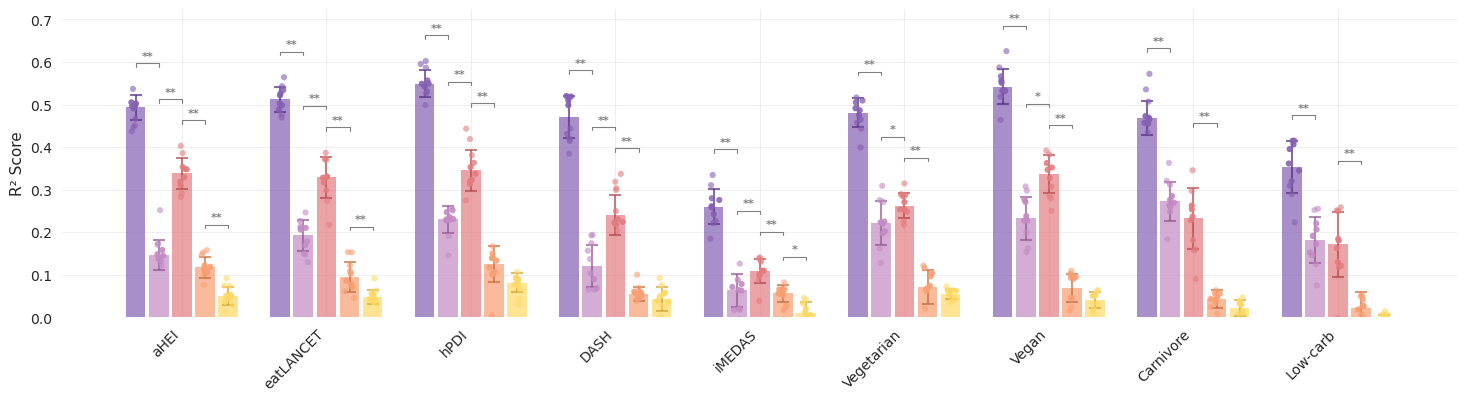

In [142]:
color_palette = 'plasma'
fig = compare_model_performance([model2_path, model3_path, model4_path, model5_path, model6_path], model_names=[model2_name, model3_name, model4_name, model5_name, model6_name], target_dirs=diet_scores, color_palette=color_palette, show_legend=False, x_labels=x_labels_diets)
plt.savefig(figs_dir + f'/performance_comparison_{y_name}_clustered.png', dpi=600, bbox_inches='tight')
plt.savefig(figs_dir + f'/performance_comparison_{y_name}_clustered_.pdf', bbox_inches='tight')
plt.show()

In [295]:
y_name = 'y_nova_scores'
model1_path = diet_paper_clustered + f'/x_ms_mpa_matched/{y_name}'
model2_path = diet_paper_clustered + f'/x_ms_matched/{y_name}'
model3_path = diet_paper_clustered + f'/x_NMR_matched/{y_name}'
model4_path = diet_paper_clustered + f'/x_mpa_matched/{y_name}'
model5_path = diet_paper_clustered + f'/x_oral_matched/{y_name}'
model6_path = diet_paper_clustered + f'/x_ms_matched/{y_name}/only_AGB'
# target_dirs = ['med_score_per_day', 'wfpb_score_per_day', 'carnivore_score_per_day', 'vegetarian_score_per_day', 'vegan_score_per_day', 'paleo_score_per_day', 'NOVA_food_score']
# true_labels_path = f'/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper/{y_name}.csv'
model1_name = "MS Metabolites + Microbiome"
model2_name = "MS Metabolites"
model3_name = "NMR Metabolites"
model4_name = "Gut Microbiome"
model5_name = "Oral Microbiome"
model6_name = "AGB only"
x_labels = []

Discovered target directories: total_nova_fiber, 1_nova_fiber, 4_nova_fiber, 2, 3_nova_fiber, 3, 2_nova_fiber, NOVA_Score, 4, 1


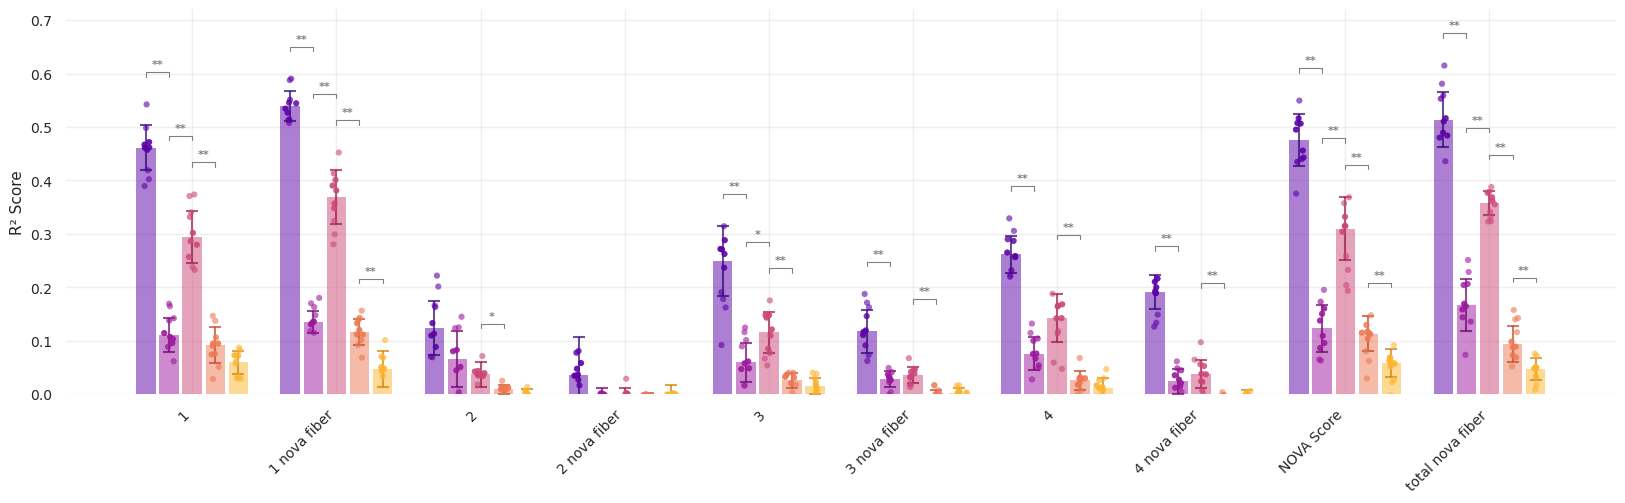

In [296]:
fig = compare_model_performance([ model2_path, model3_path, model4_path, model5_path, model6_path], model_names=[ model2_name, model3_name, model4_name, model5_name, model6_name], target_dirs=None, title=f"Model Performance Comparison for {y_name}", color_palette=color_palette, show_legend=False)
plt.savefig(figs_dir + f'/performance_comparison_{y_name}_clustered.png', dpi=300, bbox_inches='tight')
plt.savefig(figs_dir + f'/performance_comparison_{y_name}_clustered.pdf', bbox_inches='tight')
plt.show()

In [297]:
y_name = 'y_lipid_ratios'
model1_path = diet_paper_clustered + f'/x_ms_mpa_matched/{y_name}'
model2_path = diet_paper_clustered + f'/x_ms_matched/{y_name}'
model3_path = diet_paper_clustered + f'/x_NMR_matched/{y_name}'
model4_path = diet_paper_clustered + f'/x_mpa_matched/{y_name}'
model5_path = diet_paper_clustered + f'/x_oral_matched/{y_name}'
model6_path = diet_paper_clustered + f'/x_ms_matched/{y_name}/only_AGB'
true_labels_path = f'/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper/{y_name}.csv'
model1_name = "MS Metabolites + Microbiome"
model2_name = "MS Metabolites"
model3_name = "NMR Metabolites"
model4_name = "Gut Microbiome"
model5_name = "Oral Microbiome"
model6_name = "AGB only"
x_labels = []

Discovered target directories: trans_to_total_lipids_ratio, omega6_to_omega3_ratio, omega3_to_total_lipids_ratio, poly_to_total_lipids_ratio, omega6_to_total_lipids_ratio, sat_to_total_lipids_ratio, mono_to_total_lipids_ratio


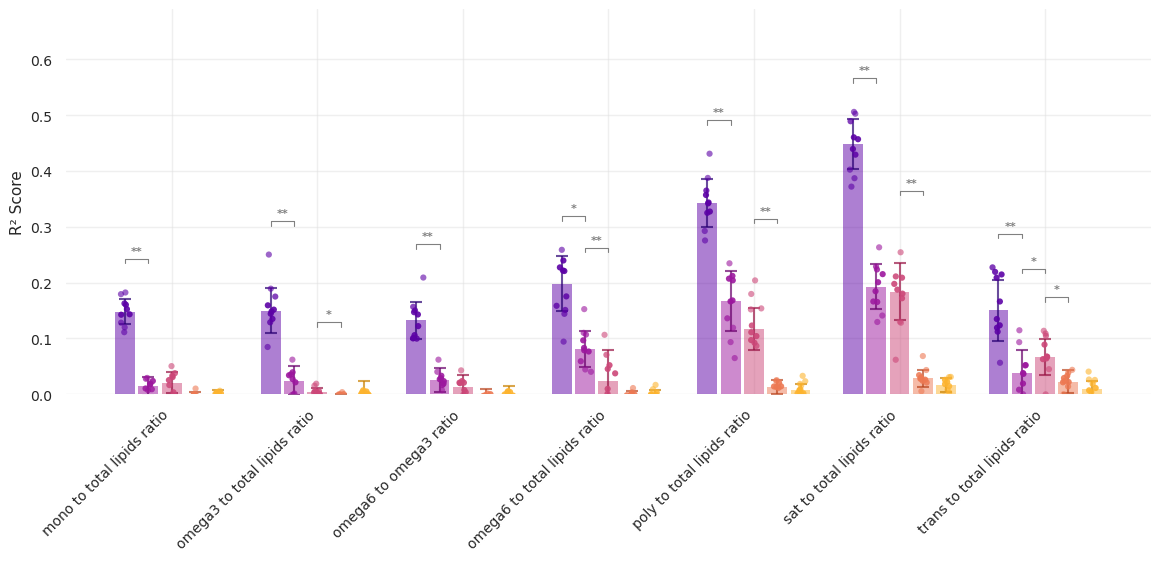

In [298]:
fig = compare_model_performance([model2_path, model3_path, model4_path, model5_path, model6_path], model_names=[model2_name, model3_name, model4_name, model5_name, model6_name], target_dirs=None, title="Model Performance Comparison for Diet Adherence", color_palette=color_palette, show_legend=False)
plt.savefig(figs_dir + f'/performance_comparison_{y_name}.png', dpi=300, bbox_inches='tight')
plt.savefig(figs_dir + f'/performance_comparison_{y_name}.pdf')
plt.show()

In [301]:
y_name = 'y_plant_ratios'
model1_path = diet_paper_clustered + f'/x_ms_mpa_matched/{y_name}'
model2_path = diet_paper_clustered + f'/x_ms_matched/{y_name}'
model3_path = diet_paper_clustered + f'/x_NMR_matched/{y_name}'
model4_path = diet_paper_clustered + f'/x_mpa_matched/{y_name}'
model5_path = diet_paper_clustered + f'/x_oral_matched/{y_name}'
model6_path = diet_paper_clustered + f'/x_ms_matched/{y_name}/only_AGB'
# true_labels_path = f'/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper/{y_name}.csv'
model1_name = "MS Metabolites + Microbiome"
model2_name = "MS Metabolites"
model3_name = "NMR Metabolites"
model4_name = "Gut Microbiome"
model5_name = "Oral Microbiome"
model6_name = "AGB only"
x_labels = []


Discovered target directories: plant_protein_pct, plant_fat_pct, plant_energy_pct


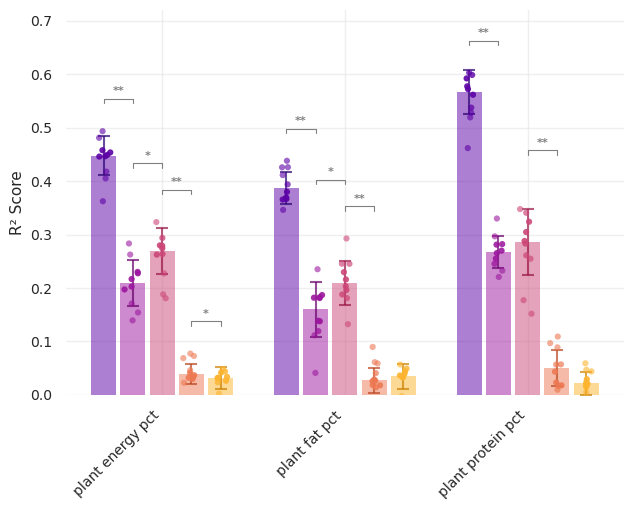

In [302]:
fig = compare_model_performance([model2_path, model3_path, model4_path, model5_path, model6_path], model_names=[ model2_name, model3_name, model4_name, model5_name, model6_name], target_dirs=None, color_palette=color_palette, show_legend=False)

plt.savefig(figs_dir + f'/performance_comparison_{y_name}_w_oral.png', dpi=300, bbox_inches='tight')
plt.savefig(figs_dir + f'/performance_comparison_{y_name}_w_oral.pdf', bbox_inches='tight')
plt.show()

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib as mpl


def plot_pred_vs_true_colored(predictions_path, x_data_path, feature_name, 
                             figsize=(2.5, 2.5), save_path=None, 
                             alpha=0.6, dot_size=10, tick_font_size=6,
                             title=None, feature_display_name=None, 
                             force_origin=False):
    """
    Create a square scatter plot of predicted vs true values colored by a feature gradient.
    The coloring feature values are z-scored (standardized).
    
    Parameters:
    -----------
    predictions_path : str
        Path to the CSV file containing true_values and predictions.
    x_data_path : str
        Path to the CSV file containing the original feature data.
    feature_name : str
        Name of the feature to use for coloring the points (continuous gradient).
    figsize : tuple, optional
        Size of the figure (width, height) in inches.
    save_path : str, optional
        If provided, save the plot to this path.
    alpha : float, optional
        Transparency of the scatter points.
    dot_size : float, optional
        Size of the dots in the scatter plot.
    tick_font_size : int, optional
        Font size for axis tick labels.
    force_origin : bool, optional
        If True, force both axes to start from 0. If False, use data-driven limits.
        
    Returns:
    --------
    fig, ax : tuple
        Matplotlib figure and axis objects.
    """
    # Set font size
    font_size = 7
    
    # Load the data
    preds_df = pd.read_csv(predictions_path, index_col=0)
    x_df = pd.read_csv(x_data_path, index_col=0)
    
    # Adjust column names based on your specific file
    true_col = 'true_values'
    pred_col = 'predictions'
    
    # Ensure we have the required columns
    if true_col not in preds_df.columns or pred_col not in preds_df.columns:
        raise ValueError(f"Predictions dataframe must contain '{true_col}' and '{pred_col}' columns")
    
    # Ensure the feature name exists in X
    if feature_name not in x_df.columns:
        raise ValueError(f"Feature '{feature_name}' not found in X dataframe")
    
    combined_df = preds_df.join(x_df[feature_name], how='inner')
    
    # Z-score the feature values
    feature_values = combined_df[feature_name]
    feature_values_z = (feature_values - feature_values.mean()) / feature_values.std()
    combined_df[f'{feature_name}_z'] = feature_values_z
    
    # Create light gray to blue colormap
    colors = ['#E0E0E0', '#B0C4DE', '#6495ED', '#0043B8']  # Light Gray to Blue
    n_bins = 100  # Number of color gradations
    cmap = mpl.colors.LinearSegmentedColormap.from_list("gray_to_blue", colors, N=n_bins)
    
    # Create the plot with specified layout
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    ax.set_facecolor('white')
    
    # Set spine visibility and color
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    
    # Configure ticks
    ax.tick_params(direction='out', length=2, width=0.5, colors='black')
    ax.tick_params(axis='x', which='both', bottom=True)
    ax.tick_params(axis='y', which='both', left=True)
    ax.grid(False)
    
    # Determine axis limits based on force_origin parameter
    if force_origin:
        # Original behavior: start from origin
        min_x = 0
        min_y = 0
        max_x = combined_df[true_col].max()
        max_y = combined_df[pred_col].max()
        
        # Add margins only to the maximum values
        margin_x = max_x * 0.05
        margin_y = max_y * 0.05
        max_x += margin_x
        max_y += margin_y
    else:
        # New behavior: data-driven limits with margins
        min_x = combined_df[true_col].min()
        max_x = combined_df[true_col].max()
        min_y = combined_df[pred_col].min()
        max_y = combined_df[pred_col].max()
        
        # Add margins to both min and max
        range_x = max_x - min_x
        range_y = max_y - min_y
        margin_x = range_x * 0.05
        margin_y = range_y * 0.05
        
        min_x -= margin_x
        max_x += margin_x
        min_y -= margin_y
        max_y += margin_y
    
    # Sort the dataframe by feature value so higher values are plotted last (on top)
    combined_df = combined_df.sort_values(by=f'{feature_name}_z')
    
    # Create the scatter plot with continuous color gradient using z-scored values
    scatter = ax.scatter(
        combined_df[true_col],
        combined_df[pred_col],
        c=combined_df[f'{feature_name}_z'],  # Use z-scored values for coloring
        cmap=cmap,
        alpha=alpha,
        s=dot_size,
        edgecolors='none'  # Remove the outer line
    )
    
    # Add y=x line (perfect prediction line)
    # Determine the range for the diagonal line based on the axis limits
    line_min = max(min_x, min_y)
    line_max = min(max_x, max_y)
    
    # Only draw the diagonal line if it would be visible within the plot area
    if line_min < line_max:
        ax.plot([line_min, line_max], [line_min, line_max], 'k--', lw=0.5)
    
    # Set dynamic limits for both axes
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    
    # Add labels with font sizes
    ax.set_xlabel('Measured', fontsize=font_size)
    ax.set_ylabel('Predicted', fontsize=font_size)
    
    # Add title if provided
    if title is not None:
        ax.set_title(title, fontsize=font_size)
    
    # Add colorbar with styling
    cbar = fig.colorbar(scatter, ax=ax)
    
    # Set the colorbar spines to linewidth 0.5
    cbar.outline.set_linewidth(0.5)
    
    # Add colorbar label
    cbar.set_label(f'{feature_display_name} (z-score)', fontsize=font_size-1)
    
    # Set colorbar scale to a reasonable z-score range
    scatter.set_clim(-3, 3)  # Typically most z-scores fall within ±3
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    cbar.ax.tick_params(labelsize=tick_font_size, width=0.5)
    
    # Calculate metrics for annotations
    r2 = r2_score(combined_df[true_col], combined_df[pred_col])
    feature_corr, feature_pval = stats.spearmanr(combined_df[feature_name], combined_df[true_col])
    
    # Add annotations for metrics
    ax.text(0.75, 0.2, f'R² = {r2:.2f}', transform=ax.transAxes,
            fontsize=font_size-2, verticalalignment='top')
    
    ax.text(0.75, 0.1, r'$\rho = {:.2f}$'.format(feature_corr), 
                transform=ax.transAxes, fontsize=font_size-2, verticalalignment='top')
    
    # Tight layout
    plt.tight_layout()
    
    # Save if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        # save in pdf format as well
        plt.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', facecolor='white')
    
    return fig, ax, {'R2': r2, 'Feature_Correlation': feature_corr, 'Feature_P_value': feature_pval}

In [83]:
# prediction_path = os.path.join(diet_paper_clustered, 'x_ms_matched', 'y_nova_scores', 'results', '4', 'predictions_4.csv')
# data_dir = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper'
# data_table_x = os.path.join(data_dir, 'x_ms_matched.csv')
# feature_name = '1.50_269.1141m/z_162.09'
diet_type = 'hPDI_score_per_day'
prediction_path = os.path.join(diet_paper_clustered, 'x_ms_matched', 'y_diet_adherence_scores', 'results', f'{diet_type}', f'predictions_{diet_type}.csv')
data_dir = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper'
data_table_x = os.path.join(data_dir, 'x_ms_matched.csv')
# feature_name = '1.53_144.1031m/z_138.12' ## deoxycarnitine
feature_name = '1.80_186.0563m/z_143.14' ## Indoleacrylic acid

(<Figure size 300x200 with 2 Axes>,
 <Axes: xlabel='Measured', ylabel='Predicted'>,
 {'R2': 0.5565094871482368,
  'Feature_Correlation': 0.32531585042950784,
  'Feature_P_value': 1.584960684137093e-79})

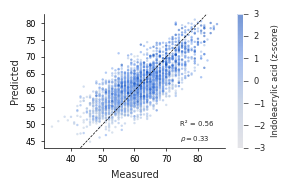

In [87]:
plot_pred_vs_true_colored(prediction_path, data_table_x, feature_name,
                          save_path=figs_dir + f'/predicted_true_colored_{diet_type}_1.png', dot_size=3, feature_display_name='Indoleacrylic acid', alpha=0.5, figsize=(3, 2))

In [91]:
# prediction_path = os.path.join(diet_paper_clustered, 'x_ms_matched', 'y_nova_scores', 'results', '4', 'predictions_4.csv')
# data_dir = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper'
# data_table_x = os.path.join(data_dir, 'x_ms_matched.csv')
# feature_name = '1.50_269.1141m/z_162.09'
# diet_type = 'Zinc_Zn'
# diet_type = 'Choline_total'
diet_type = 'Vitamin_D_D2_D3_'
# diet_type = 'Magnesium_Mg'
prediction_path = os.path.join(diet_paper_clustered, 'x_ms_matched', 'y_nutrients', 'results', f'{diet_type}', f'predictions_{diet_type}.csv')
data_dir = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/final_for_diet_paper'
data_table_x = os.path.join(data_dir, 'x_ms_matched.csv')
# feature_name = '1.53_144.1031m/z_138.12' ## deoxycarnitine
# feature_name = '1.80_186.0563m/z_143.14' ## Xanthurenic acid
# feature_name = '1.53_253.1197m/z_157.0' ## Pyrraline
feature_name = '5.79_301.2175m/z_182.85' ## EPA
# feature_name = '5.94_464.3148m/z_218.42' ## LysoPE(P-18:0/0:0)
# feature_name = '2.95_353.0340m/z_176.06' ## Dihydronaringenin-O-sulphate

(<Figure size 300x200 with 2 Axes>,
 <Axes: xlabel='Measured', ylabel='Predicted'>,
 {'R2': 0.2429314983300842,
  'Feature_Correlation': 0.3330105484517883,
  'Feature_P_value': 1.8070556572644142e-83})

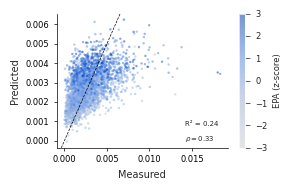

In [92]:
plot_pred_vs_true_colored(prediction_path, data_table_x, feature_name,
                          save_path=figs_dir + f'/predicted_true_colored_{diet_type}_1.png', dot_size=3, 
                          feature_display_name='EPA', alpha=0.5,
                          figsize=(3, 2))

## Person-Diet Identification

In [71]:
def clean_model_name(filename: str) -> str:
    """
    Extract clean model name from filename.
    Example: 'predictions_model_v1.csv' -> 'model_v1'
    
    Args:
        filename (str): Original filename
        
    Returns:
        str: Clean model name
    """
    # Remove 'predictions_' prefix and '.csv' suffix
    if 'predictions_' in filename:
        clean_name = filename.split('predictions_')[1]
    else:
        clean_name = filename
        
    # Remove .csv extension if present
    if clean_name.endswith('.csv'):
        clean_name = clean_name[:-4]
        
    return clean_name

def process_prediction_files(root_dir: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Processes prediction files within subdirectories of the 'results' directory
    and creates two tables: one for true values and one for predictions.
    Column names are taken from the part of the filename after 'predictions_'.
    
    Directory structure expected:
    root_dir/
        results/
            model1/
                predictions_experiment1.csv  -> column name: 'experiment1'
            model2/
                predictions_baseline.csv     -> column name: 'baseline'
            ...
    
    Args:
        root_dir (str): Path to the root directory containing a 'results' subdirectory
        
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Two DataFrames containing true values and predictions
    """
    # Initialize dictionaries to store results
    true_values_dict: Dict[str, List[float]] = {}
    predictions_dict: Dict[str, List[float]] = {}
    
    # Define results directory path
    results_dir = os.path.join(root_dir, 'results')
    
    # Check if results directory exists
    if not os.path.exists(results_dir):
        raise FileNotFoundError(f"Results directory not found at {results_dir}")
    
    # Process each subdirectory in results
    for model_dir in os.listdir(results_dir):
        model_path = os.path.join(results_dir, model_dir)
        
        # Skip if not a directory
        if not os.path.isdir(model_path):
            continue
            
        # Process files in the model directory
        for filename in os.listdir(model_path):
            # Check if file contains 'predictions' in its name and is a CSV
            if 'predictions' in filename.lower() and filename.endswith('.csv'):
                try:
                    # Create model identifier using only the clean name
                    model_id = clean_model_name(filename)
                    
                    # Read the CSV file
                    file_path = os.path.join(model_path, filename)
                    df = pd.read_csv(file_path)
                    
                    # Verify required columns exist
                    if 'true_values' not in df.columns or 'predictions' not in df.columns:
                        print(f"Warning: Required columns missing in {model_id}")
                        continue
                    
                    # Store values in dictionaries
                    true_values_dict[model_id] = df['true_values'].tolist()
                    predictions_dict[model_id] = df['predictions'].tolist()
                    
                except Exception as e:
                    print(f"Error processing {model_id}: {str(e)}")
                    continue
    
    # Check if any files were processed
    if not true_values_dict:
        raise ValueError("No valid prediction files found in results subdirectories")
    
    # Create DataFrames from the collected data
    true_values_df = pd.DataFrame(true_values_dict)
    predictions_df = pd.DataFrame(predictions_dict)
    
    # Add index column if it exists in original files
    sample_model = list(true_values_dict.keys())[0]
    # Find the original file path for the sample model
    for root, _, files in os.walk(results_dir):
        for file in files:
            if clean_model_name(file) == sample_model:
                sample_path = os.path.join(root, file)
                break
    
    sample_df = pd.read_csv(sample_path)
    if 'index' in sample_df.columns:
        true_values_df.index = sample_df['index']
        predictions_df.index = sample_df['index']
    
    return true_values_df, predictions_df

In [89]:
categories_dir_mpa = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Matched/x_mpa_matched/y_diet_adherence_scores'
categories_dir_ms = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Matched/x_ms_matched/y_diet_adherence_scores'
categories_dir_nightingale = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Matched/x_nightingale_matched/y_diet_adherence_scores'
categories_dir_agb = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Matched/x_ms_matched/y_diet_adherence_scores/only_AGB'

In [96]:
# do a for loop to get the results for each model stores them in a list
root_dirs = [categories_dir_ms, categories_dir_mpa, categories_dir_nightingale, categories_dir_agb]
true_values_dfs = []
predictions_dfs = []
for root_dir in root_dirs:
    true_values_df, predictions_df = process_prediction_files(root_dir)
    true_values_dfs.append(true_values_df)
    predictions_dfs.append(predictions_df)

In [160]:
# true_values_df.drop(columns=['Energy', 'Water', 'Carbohydrate_by_difference', 'Protein', 'Total_lipid_fat_', 'Alcohol_ethyl'], inplace=True)
# predictions_df.drop(columns=['Energy', 'Water', 'Carbohydrate_by_difference', 'Protein', 'Total_lipid_fat_', 'Alcohol_ethyl'], inplace=True)

In [52]:
def calculate_multivariate_self_distances(true_values_df, predictions_df):
    """
    Calculate multivariate distances between all predictions and true values,
    then extract and analyze self-distances (matching indices).
    
    Args:
        true_values_df (pd.DataFrame): DataFrame with true values
        predictions_df (pd.DataFrame): DataFrame with predictions
        
    Returns:
        tuple: (all_distances, self_distances, self_distance_ranks)
            - all_distances: matrix of distances between all pairs
            - self_distances: array of distances between matching indices
            - self_distance_ranks: rank of self-distance among all distances for each point
    """
    # Convert DataFrames to numpy arrays for distance calculation
    true_array = true_values_df.values
    pred_array = predictions_df.values
    
    # Calculate all pairwise distances
    all_distances = cdist(pred_array, true_array)
    
    # Get self-distances (diagonal elements - matching indices)
    self_distances = np.diag(all_distances)
    
    # Calculate ranks for each point
    self_distance_ranks = []
    for i in range(len(self_distances)):
        # Get all distances for this prediction
        distances_for_point = all_distances[i]
        
        # Calculate rank of self-distance among all distances
        rank = np.where(np.argsort(distances_for_point) == i)[0][0] + 1
        
        self_distance_ranks.append({
            'index': true_values_df.index[i],
            'self_distance': self_distances[i],
            'rank': rank,
            'normalized_rank': rank / len(true_array)
        })
    
    # Convert ranks to DataFrame
    ranks_df = pd.DataFrame(self_distance_ranks)
    
    # Calculate summary statistics
    stats = {
        'n_points': len(self_distances),
        'mean_self_distance': np.mean(self_distances),
        'median_self_distance': np.median(self_distances),
        'std_self_distance': np.std(self_distances),
        'min_self_distance': np.min(self_distances),
        'max_self_distance': np.max(self_distances),
        'perfect_matches': sum(ranks_df['rank'] == 1),
        'median_rank': np.median(ranks_df['rank']),
        'mean_rank': np.mean(ranks_df['rank'])
    }
    
    return all_distances, self_distances, ranks_df, stats

def plot_self_distances_boxplot(self_distances, output_path=None):
    """
    Create a box plot of the self-distances.
    
    Args:
        self_distances (np.array): Array of distances between matching indices
        output_path (str, optional): Path to save the plot
    """
    plt.figure(figsize=(10, 6))
    plt.boxplot(self_distances)
    plt.ylabel('Distance')
    plt.title('Distribution of Self-Distances\n(Distances between True and Predicted Values for Same Index)')
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()

In [53]:
all_distances, self_distances, ranks_df, stats = calculate_multivariate_self_distances(true_values_df, predictions_df)

In [421]:
def preprocess_data(true_values_df: pd.DataFrame, 
                   predictions_df: pd.DataFrame, 
                   top_n: int = 10, 
                   standardize: bool = False) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Preprocess the data by selecting top columns and optionally standardizing.
    
    Args:
        true_values_df: DataFrame with true values
        predictions_df: DataFrame with predictions
        top_n: Number of top columns to select based on median values
        standardize: Whether to standardize the data
        
    Returns:
        tuple of processed true values and predictions DataFrames
    """
    # Calculate median values for each column
    medians = true_values_df.median()
    
    # Select top N columns
    top_columns = medians.nlargest(top_n).index.tolist()
    
    # Subset both DataFrames
    true_subset = true_values_df[top_columns]
    pred_subset = predictions_df[top_columns]
    
    if standardize:
        scaler = StandardScaler()
        true_scaled = pd.DataFrame(
            scaler.fit_transform(true_subset),
            columns=true_subset.columns,
            index=true_subset.index
        )
        # Use the same scaler for predictions to maintain scale
        pred_scaled = pd.DataFrame(
            scaler.transform(pred_subset),
            columns=pred_subset.columns,
            index=pred_subset.index
        )
        return true_scaled, pred_scaled
    
    return true_subset, pred_subset

def calculate_topk_percentage_curve(true_values_df: pd.DataFrame, 
                                  predictions_df: pd.DataFrame, 
                                  num_points: int = 100,
                                  top_n: int = 10,
                                  standardize: bool = False) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculate the top-k curve where k is expressed as percentage of total population.
    
    Args:
        true_values_df: DataFrame with true values
        predictions_df: DataFrame with predictions
        num_points: Number of points to calculate for the curve
        top_n: Number of top columns to use based on median values
        standardize: Whether to standardize the data before calculation
        
    Returns:
        tuple: (percentage_values, accuracies) for plotting
    """
    # Preprocess the data
    true_processed, pred_processed = preprocess_data(
        true_values_df, predictions_df, top_n, standardize
    )
    
    # Calculate distances
    true_array = true_processed.values
    pred_array = pred_processed.values
    distances = cdist(pred_array, true_array)
    
    # Calculate ranks for each point
    ranks = []
    n_points = len(true_array)
    
    for i in range(n_points):
        distances_for_point = distances[i]
        rank = np.where(np.argsort(distances_for_point) == i)[0][0] + 1
        ranks.append(rank)
    
    ranks = np.array(ranks)
    
    # Calculate percentage values (0 to 100)
    percentage_values = np.linspace(0, 100, num_points)
    
    # Calculate accuracy for each percentage threshold
    accuracies = []
    for percentage in percentage_values:
        if percentage == 0:
            accuracies.append(0)
            continue
        
        k = int(np.ceil((percentage / 100) * n_points))
        accuracy = 100 * np.mean(ranks <= k)
        accuracies.append(accuracy)
    
    return percentage_values, np.array(accuracies)

def plot_topk_percentage_curve(percentage_values: np.ndarray, 
                             accuracies: np.ndarray, 
                             output_path: str = None,
                             title_suffix: str = "",
                             category_name: str = ""):
    """
    Plot the top-k curve with percentage-based x-axis.
    
    Args:
        percentage_values: Array of percentage values (0-100)
        accuracies: Array of accuracy values
        output_path: Path to save the plot
        title_suffix: Additional information to add to plot title
        category_name: Category name for the columns being analyzed
    """
    plt.figure(figsize=(10, 6))
    
    # Plot the curve
    plt.plot(percentage_values, accuracies, '-b', linewidth=2)
    
    # Add reference lines
    plt.axhline(y=100, color='r', linestyle='--', alpha=0.5)
    plt.plot([0, 100], [0, 100], 'r--', alpha=0.3)
    
    # Customize plot
    plt.xlabel('Top-k (% of Population)')
    plt.ylabel('Accuracy (% within Top-k)')
    
    # Create title with category name if provided
    title = f'Top-k Accuracy Curve - {category_name}' if category_name else 'Top-k Accuracy Curve'
    title += title_suffix
    plt.title(title)
    
    plt.grid(True, alpha=0.3)
    
    # Add annotations at key percentages
    key_percentages = [1, 5, 10, 25, 50, 75]
    for p in key_percentages:
        idx = np.searchsorted(percentage_values, p)
        if idx < len(accuracies):
            plt.plot(percentage_values[idx], accuracies[idx], 'ro', alpha=0.6)
            plt.annotate(f'Top {p}%: {accuracies[idx]:.1f}%', 
                        (percentage_values[idx], accuracies[idx]),
                        xytext=(10, 10), textcoords='offset points')
            
            
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
        
    plt.show()


def analyze_topk(true_values_df: pd.DataFrame, 
                predictions_df: pd.DataFrame,
                top_n: int = 10,
                standardize: bool = False,
                output_path: str = None,
                category_name: str = ""):
    """
    Perform complete top-k analysis with given parameters.
    
    Args:
        true_values_df: DataFrame with true values
        predictions_df: DataFrame with predictions
        top_n: Number of top columns to use
        standardize: Whether to standardize the data
        output_path: Base path for saving the plot and report
        category_name: Category name for the columns being analyzed (e.g., "Food Categories")
    """
    # Get selected columns
    true_processed, _ = preprocess_data(true_values_df, predictions_df, top_n, False)
    selected_columns = true_processed.columns.tolist()
    
    # Calculate curve
    percentage_values, accuracies = calculate_topk_percentage_curve(
        true_values_df, predictions_df, top_n=top_n, standardize=standardize
    )
    
    # Create title suffix
    title_suffix = f"\n(Top {top_n} columns"
    title_suffix += ", Standardized" if standardize else ""
    title_suffix += ")"
    
    # Prepare base filename
    if output_path:
        # Clean category name for filename
        clean_category = category_name.lower().replace(' ', '_') if category_name else ''
        filename_base = f"{clean_category}_" if clean_category else ""
        
        # Create filenames
        plot_name = f"{filename_base}topk_curve_top{top_n}{'_standardized' if standardize else ''}.png"
        report_name = f"{filename_base}topk_report_top{top_n}{'_standardized' if standardize else ''}.txt"
        
        plot_path = f"{output_path}_{plot_name}"
        report_path = f"{output_path}_{report_name}"
    else:
        plot_path = None
        report_path = None
    
    # Create plot
    plot_topk_percentage_curve(percentage_values, accuracies, plot_path, 
                             title_suffix, category_name)
    
    # Prepare analysis report
    report_lines = [
        f"Analysis Report - {category_name}" if category_name else "Analysis Report",
        f"{'=' * 50}",
        f"\nParameters:",
        f"- Category: {category_name}",
        f"- Top {top_n} columns used",
        f"- Standardization: {'Yes' if standardize else 'No'}",
        f"\nSelected columns:",
        *[f"- {col}" for col in selected_columns],
        f"\nKey Statistics:",
        f"{'-' * 20}"
    ]
    
    key_percentages = [1, 5, 10, 25, 50, 75, 100]
    for p in key_percentages:
        idx = np.searchsorted(percentage_values, p)
        if idx < len(accuracies):
            report_lines.append(f"Top {p:>3}%: {accuracies[idx]:>6.2f}% accuracy")
    
    # Print report
    print("\n".join(report_lines))
    
    # Save report if output path is provided
    if output_path:
        with open(report_path, 'w') as f:
            f.write("\n".join(report_lines))
            
    return percentage_values, accuracies, selected_columns

In [94]:
def analyze_topk_multiple(true_values_dfs: list, 
                         predictions_dfs: list,
                         model_names: list = None,
                         top_n: int = 10,
                         standardize: bool = False,
                         output_path: str = None,
                         category_name: str = "",
                         columns_to_exclude: list = None,
                         show_annotations: bool = True):
    """
    Perform complete top-k analysis for multiple models with given parameters.
    
    Args:
        true_values_dfs: List of DataFrames with true values for each model
        predictions_dfs: List of DataFrames with predictions for each model
        model_names: List of names for each model (optional)
        top_n: Number of top columns to use
        standardize: Whether to standardize the data
        output_path: Base path for saving the plot and report
        category_name: Category name for the columns being analyzed (e.g., "Food Categories")
        columns_to_exclude: List of column names to exclude from the analysis
        show_annotations: Whether to show key point annotations on the plot (default: True)
    """
    if len(true_values_dfs) != len(predictions_dfs):
        raise ValueError("Number of true value and prediction DataFrames must match")
    
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(true_values_dfs))]
    elif len(model_names) != len(true_values_dfs):
        raise ValueError("Number of model names must match number of models")

    # Store results for each model
    all_percentage_values = []
    all_accuracies = []
    all_selected_columns = []
    
    # Calculate curves for each model
    for true_df, pred_df, model_name in zip(true_values_dfs, predictions_dfs, model_names):
        # Filter out excluded columns if specified
        if columns_to_exclude:
            true_df = true_df.drop(columns=columns_to_exclude, errors='ignore')
            pred_df = pred_df.drop(columns=columns_to_exclude, errors='ignore')
        
        # Get selected columns
        true_processed, _ = preprocess_data(true_df, pred_df, top_n, False)
        selected_columns = true_processed.columns.tolist()
        
        # Calculate curve
        percentage_values, accuracies = calculate_topk_percentage_curve(
            true_df, pred_df, top_n=top_n, standardize=standardize
        )
        
        all_percentage_values.append(percentage_values)
        all_accuracies.append(accuracies)
        all_selected_columns.append(selected_columns)

    # Find the best performing model based on average accuracy
    avg_accuracies = [np.mean(accs) for accs in all_accuracies]
    best_model_idx = np.argmax(avg_accuracies)

    # Create title suffix
    title_suffix = f"\n(Top {top_n} columns"
    title_suffix += ", Standardized" if standardize else ""
    if columns_to_exclude:
        title_suffix += f", {len(columns_to_exclude)} columns excluded"
    title_suffix += ")"
    
    # Prepare base filename
    if output_path:
        clean_category = category_name.lower().replace(' ', '_') if category_name else ''
        filename_base = f"{clean_category}_" if clean_category else ""
        
        plot_name = f"{filename_base}topk_curve_comparison_top{top_n}{'_standardized' if standardize else ''}.png"
        report_name = f"{filename_base}topk_report_comparison_top{top_n}{'_standardized' if standardize else ''}.txt"
        
        plot_path = f"{output_path}_{plot_name}"
        report_path = f"{output_path}_{report_name}"
    else:
        plot_path = None
        report_path = None
    
    # Create plot with multiple curves
    plt.figure(figsize=(12, 8))
    
    # Add diagonal dashed line first
    plt.plot([0, 100], [0, 100], '--', color='red', alpha=0.5, label='Random')
    
    # Key percentages to annotate
    key_percentages = [1, 5, 10, 25, 50, 75]
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_percentage_values)))
    
    for i, (percentages, accs, model_name) in enumerate(zip(all_percentage_values, all_accuracies, model_names)):
        line, = plt.plot(percentages, accs, label=model_name, marker='o', markersize=4, color=colors[i])
        
        # Add annotations only for the best performing model
        if show_annotations and i == best_model_idx:
            for p in key_percentages:
                idx = np.searchsorted(percentages, p)
                if idx < len(accs):
                    # Add point
                    plt.plot(percentages[idx], accs[idx], 'o', color=colors[i])
                    
                    # Add annotation with line
                    plt.annotate(f'Top {p}%: {accs[idx]:.1f}%',
                               xy=(percentages[idx], accs[idx]),
                               xytext=(10, 10), textcoords='offset points',
                               ha='left', va='bottom',
                               bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.xlabel('Top-k (% of Population)')
    plt.ylabel('Accuracy (% within Top-k)')
    title = f"Top-k Accuracy Curve{' - ' + category_name if category_name else ''}{title_suffix}"
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    
    # Set axis limits
    plt.xlim(-5, 105)
    plt.ylim(-5, 105)
    
    if plot_path:
        plt.savefig(plot_path, bbox_inches='tight', dpi=300, facecolor='white')
    plt.show()
    
    # Prepare analysis report
    report_lines = [
        f"Comparative Analysis Report - {category_name}" if category_name else "Comparative Analysis Report",
        f"{'=' * 50}",
        f"\nParameters:",
        f"- Category: {category_name}",
        f"- Top {top_n} columns used",
        f"- Standardization: {'Yes' if standardize else 'No'}",
        f"- Best performing model: {model_names[best_model_idx]}"
    ]
    
    if columns_to_exclude:
        report_lines.extend([
            f"- Excluded columns:",
            *[f"  * {col}" for col in columns_to_exclude]
        ])
    
    report_lines.extend([
        f"\nResults by Model:",
        f"{'-' * 20}"
    ])
    
    for model_idx, (percentages, accs, model_name, columns) in enumerate(
        zip(all_percentage_values, all_accuracies, model_names, all_selected_columns)
    ):
        report_lines.extend([
            f"\nModel: {model_name}{'  (Best Performance)' if model_idx == best_model_idx else ''}",
            f"Average Accuracy: {np.mean(accs):.2f}%",
            f"Selected columns:",
            *[f"- {col}" for col in columns],
            f"\nKey Statistics:"
        ])
        
        for p in key_percentages:
            idx = np.searchsorted(percentages, p)
            if idx < len(accs):
                report_lines.append(f"Top {p:>3}%: {accs[idx]:>6.2f}% accuracy")
    
    # Print report
    print("\n".join(report_lines))
    
    # Save report if output path is provided
    if output_path:
        with open(report_path, 'w') as f:
            f.write("\n".join(report_lines))
            
    return all_percentage_values, all_accuracies, all_selected_columns

In [57]:
true_values_df.columns

Index(['is_vegetarian', 'med_score_per_day', 'keto', 'paleo_score_per_day',
       'vegan_score_per_day', 'Energy_Expenditure_Consumption_Ratio',
       'wfpb_score_per_day', 'vegetarian_score_per_day', 'NOVA_food_score',
       'wfab_score_per_day'],
      dtype='object')

In [ ]:
cols_to_drop = ['is_vegetarian', 'keto', 'Energy_Expenditure_Consumption_Ratio']
percentage_values, accuracies, selected_columns = analyze_topk(true_values_df.drop(columns=cols_to_drop), predictions_df.drop(columns=cols_to_drop), standardize=True,
                                                               output_path='./diet_paper/person_diet_identification/', 
                                                               category_name='Diet Adherence_only')

In [ ]:
# Create a comparative analysis for multiple models
analyze_topk_multiple(true_values_dfs, predictions_dfs, model_names=['MS', 'MPA', 'Nightingale', 'AGB'], standardize=True, output_path='./diet_paper/person_diet_identification/', category_name='Diet Adherence_only', columns_to_exclude=['Energy_Expenditure_Consumption_Ratio'], show_annotations=True)

## Histogram comparison

In [235]:
def create_performance_heatmap_for_nutrients(
    directories: List[str],
    regression: bool = True,
    exclude_targets: Optional[List[str]] = None,
    output_path: Optional[str] = None,
    cmap: str = "RdYlBu_r",
    figsize: Tuple[int, int] = (18, 12),
    show_nutrient_groups: bool = False,
    use_auc_range: bool = False,  # New flag for AUC specific plotting
    use_bottom_10_percent: bool = False,  # New flag to modify directory paths
    use_top_10_percent: bool = False,  # New flag to modify directory paths
        
) -> None:
    from matplotlib.colors import ListedColormap
    from matplotlib.patches import Patch
    import numpy as np
    
    def get_nutrient_color_safe(target):
        original_name = convert_to_original(target)
        group = get_nutrient_group(original_name)
        return group_colors.get(group, '#CCCCCC')
    
    def get_group_order(target):
        original_name = convert_to_original(target)
        group = get_nutrient_group(original_name)
        group_order = {
            'Macronutrients': 0,
            'Vitamins': 1,
            'Minerals': 2,
            'Fatty Acids': 3,
            'Amino Acids': 4,
            'Phytonutrients': 5,
            'Other Compounds': 6,
            'Unknown': 7
        }
        return group_order.get(group, 8)
    
    all_results = {}
    all_targets = set()
    
    # Custom x-axis labels mapping
    custom_labels = {
        'only_AGB': 'AGB Only',
        'x_ms_matched': 'MS Metabolites',
        'x_mpa_matched': 'Gut Microbiome',
        'x_NMR_matched': 'NMR Metabolites',
        'x_oral_matched': 'Oral Microbiome'
    }
    
    for dir_path in directories:
        try:
            # Modify the directory path if use_bottom_10_percent is True
            if use_bottom_10_percent:
                # For a path like /path/to/model_name/, we want /path/to/model_name/bottom_10_percent/
                actual_dir_path = os.path.join(dir_path, "bottom_10_percent")
            elif use_top_10_percent:
                # For a path like /path/to/model_name/, we want /path/to/model_name/top_10_percent/
                actual_dir_path = os.path.join(dir_path, "top_10_percent")
            else:
                actual_dir_path = dir_path
            
            results_path = os.path.join(actual_dir_path, "final_results.csv")
            df = pd.read_csv(results_path)
            
            # Get the experiment name and map to custom label
            if use_bottom_10_percent or use_top_10_percent:
                # For a path like /path/to/model_name/bottom_10_percent/, 
                # we need to extract "model_name"
                # First get the dirname of actual_dir_path to get to /path/to/model_name/bottom_10_percent
                parent_dir = os.path.dirname(actual_dir_path)
                # Then get the dirname again to get to /path/to/model_name
                grandparent_dir = os.path.dirname(parent_dir)
                # Extract model_name
                base_name = os.path.basename(grandparent_dir)
            else:
                base_name = os.path.basename(os.path.dirname(dir_path))
                
            if 'only_AGB' in dir_path:
                exp_name = 'only_AGB'
            else:
                exp_name = base_name
                
            if exclude_targets:
                df = df[~df['target'].isin(exclude_targets)]
            
            metric = 'combined_r2' if regression else 'combined_auc'
            df[metric] = df[metric].clip(lower=0)
            all_results[exp_name] = dict(zip(df['target'], df[metric]))
            all_targets.update(df['target'])
            
        except Exception as e:
            print(f"Error processing directory {dir_path}: {str(e)}")
    
    if not all_results:
        raise ValueError("No valid data found in the specified directories")
    
    all_targets = sorted(list(all_targets), 
                        key=lambda x: (get_group_order(x), convert_to_original(x)))
    
    data_matrix = []
    exp_names = []
    
    for exp_name, results in all_results.items():
        exp_names.append(exp_name)
        row = [results.get(target, np.nan) for target in all_targets]
        data_matrix.append(row)
    
    display_targets = [convert_to_original(target) for target in all_targets]
    heatmap_df = pd.DataFrame(data_matrix, index=exp_names, columns=display_targets).T
    
    # Map the column names to custom labels
    heatmap_df.columns = [custom_labels.get(col, col) for col in heatmap_df.columns]
    
    first_dir_values = heatmap_df[heatmap_df.columns[0]].dropna()
    center_value = first_dir_values.median()
    max_value = heatmap_df.max().max()
    
    # Set vmin based on the use_auc_range flag
    vmin = 0.5 if use_auc_range and not regression else 0
    # Set vmax based on the use_auc_range flag
    vmax = 1.0 if use_auc_range and not regression else max_value
    
    fig = plt.figure(figsize=figsize)
    
    if show_nutrient_groups:
        gs = fig.add_gridspec(2, 2, height_ratios=[1, 15], width_ratios=[15, 5])
        ax_cbar = fig.add_subplot(gs[0, 0])
        ax_main = fig.add_subplot(gs[1, 0])
        
        sns.heatmap(heatmap_df,
                   cmap=cmap,
                   center=center_value if not (use_auc_range and not regression) else 0.75,
                   vmin=vmin,
                   vmax=vmax,
                   ax=ax_main,
                   cbar_ax=ax_cbar,
                   cbar_kws={'label': 'R² Score' if regression else 'AUC Score', 'orientation': 'horizontal'},
                   linewidth=.5,
                   yticklabels=display_targets,)
        
        # Rotate x-axis labels
        ax_main.set_xticklabels(ax_main.get_xticklabels(), rotation=45, ha='right')
        
        patch_width = 0.3
        for idx, target in enumerate(all_targets):
            color = get_nutrient_color_safe(target)
            rect = plt.Rectangle((ax_main.get_xlim()[1], idx), patch_width, 1, 
                               facecolor=color, clip_on=False)
            ax_main.add_patch(rect)
        
        ax_legend = fig.add_subplot(gs[1])
        ax_legend.axis('off')
        
        known_groups = {get_nutrient_group(convert_to_original(target)) 
                       for target in all_targets} - {'Unknown'}
        
        if known_groups:
            legend_elements = [Patch(facecolor=group_colors[group], label=group)
                             for group in sorted(known_groups)]
            if 'Unknown' in {get_nutrient_group(convert_to_original(target)) 
                           for target in all_targets}:
                legend_elements.append(Patch(facecolor='#CCCCCC', label='Unknown'))
                
            ax_legend.legend(handles=legend_elements,
                           title="Nutrient Groups",
                           loc='center left')
                           
        ax = ax_main  # Set ax to ax_main for consistent variable usage
    else:
        ax = sns.heatmap(heatmap_df,
                        cmap=cmap,
                        center=center_value if not (use_auc_range and not regression) else 0.75,
                        vmin=vmin,
                        vmax=vmax,
                        cbar_kws={'label': 'R² Score' if regression else 'AUC Score'},
                        yticklabels=display_targets)
        
        # Rotate x-axis labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.gca().yaxis.set_ticks_position('right')
    
    # Use the consistent 'ax' variable for final adjustments
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()
    
    plt.close()

In [236]:
def create_ridgeline_comparison(
    directories: List[str],
    regression: bool = True,
    exclude_targets: Optional[List[str]] = None,
    output_path: Optional[str] = None,
    color_palette: str = "viridis",
    overlap: float = 0.7,
    bandwidth: float = 0.2
) -> None:
    """
    Create a ridgeline plot comparing metrics across different experiments with peak annotations.
    
    Args:
        directories (List[str]): List of paths to directories containing final_results.csv files
        regression (bool): If True, use combined_r2 metric, else use combined_auc
        exclude_targets (List[str], optional): List of target names to exclude from the plot
        output_path (str, optional): Path to save the plot. If None, displays the plot
        color_palette (str): Name of the seaborn color palette to use
        overlap (float): Overlap between distributions (0 to 1)
        bandwidth (float): Kernel bandwidth for density estimation
    """
    # Initialize storage for all results
    all_data = []
    
    # Process each directory
    for dir_path in directories:
        try:
            # Read the results file
            results_path = os.path.join(dir_path, "final_results.csv")
            df = pd.read_csv(results_path)
            
            # Get directory name for labeling
            if 'only_AGB' not in dir_path:
                exp_name = os.path.basename(os.path.dirname(dir_path))
            else:
                exp_name = 'AGB only'
            
            # Filter targets if specified
            if exclude_targets:
                df = df[~df['target'].isin(exclude_targets)]
            
            # Select metric based on task type
            metric = 'combined_r2' if regression else 'combined_auc'
            
            # Store results with experiment name and best target
            best_idx = df[metric].idxmax()
            best_target = df.loc[best_idx, 'target']
            max_value = df[metric].max()
                
            all_data.append({
                'experiment': exp_name,
                'values': df[metric].values,
                'best_target': best_target,
                'max_value': max_value
            })
            
        except Exception as e:
            print(f"Error processing directory {dir_path}: {str(e)}")
    
    if not all_data:
        raise ValueError("No valid data found in the specified directories")
    
    # Create the ridgeline plot
    fig, ax = plt.subplots(figsize=(14, 8))  # Increased width for annotations
    
    # Get color palette
    colors = sns.color_palette(color_palette, n_colors=len(all_data))
    
    # Calculate the maximum density for scaling
    max_density = 0
    for data in all_data:
        kernel = stats.gaussian_kde(data['values'], bw_method=bandwidth)
        x_range = np.linspace(min(data['values']), max(data['values']), 200)
        density = kernel(x_range)
        max_density = max(max_density, max(density))
    
    # Plot each distribution
    for idx, data in enumerate(all_data):
        # Calculate kernel density
        kernel = stats.gaussian_kde(data['values'], bw_method=bandwidth)
        x_range = np.linspace(min(data['values']), max(data['values']), 200)
        density = kernel(x_range)
        
        # Scale density and create offset
        scaled_density = density / max_density
        offset = idx * (1 - overlap)
        
        # Plot the distribution
        plt.fill_between(x_range, offset, scaled_density + offset,
                        alpha=0.8, color=colors[idx], label=data['experiment'])
        plt.plot(x_range, scaled_density + offset, color='black', linewidth=0.5)
        
        # Find the y-value at the maximum R² position
        max_x = data['max_value']
        max_idx = np.abs(x_range - max_x).argmin()
        max_y = scaled_density[max_idx] + offset
        
        # Add annotation for best target
        annotation_text = f"{data['best_target']}"
        plt.annotate(annotation_text,
                    xy=(max_x, max_y),
                    xytext=(5, 0),
                    textcoords='offset points',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                    fontsize=8,
                    verticalalignment='center')
    
    # Customize the plot
    plt.ylabel('')
    plt.xlabel('Combined R² Score' if regression else 'Combined AUC Score')
    plt.title('Ridgeline Plot of Model Performance Across Experiments')
    
    # Set y-ticks to align with distributions
    plt.yticks([i * (1 - overlap) for i in range(len(all_data))],
               [data['experiment'] for data in all_data])
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Add vertical line at x=0
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.7)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save or display the plot
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()
    
    plt.close()

In [238]:
# Define directories for comparison
y_name = 'nutrients'
dir1 = diet_paper_dir + f'/x_ms_matched/y_{y_name}'
# dir2 = diet_paper_dir + f'/x_mpa_for_diet/y_diet_{y_name}_mpa'
# dir3 = diet_paper_dir + f'/x_nightingale_diet/y_diet_{y_name}_nightingale'
dir4 = diet_paper_dir + f'/x_ms_mpa_matched/y_{y_name}/only_AGB'
dir5 = diet_paper_dir + f'/x_ms_mpa_matched/y_{y_name}'
dir6 = diet_paper_dir + f'/x_mpa_matched/y_{y_name}'
dir7 = diet_paper_dir + f'/x_nightingale_matched/y_{y_name}'

In [239]:
# # Create ridgeline plot for nutrient predictions
# list_dirs = [dir5, dir1, dir6, dir7, dir4]
# # list_dirs.reverse()
# create_ridgeline_comparison(
#     list_dirs,
#     regression=True,
#     # exclude_targets=['Fiber_total_dietary'],
#     bandwidth=0.1,
#     output_path=figs_dir + f'/ridgeline_nutrients_{y_name}_matched_plasma.png',
#     color_palette='plasma'
# )

In [240]:
nutrient_groups = {
    'Macronutrients': [
        'Energy',
        'Water',
        'Starch',
        'Sugars, Total',
        'Glucose',
        'Fructose',
        'Sugar alcohols',
        'Fiber, total dietary',
        'Ash'
    ],
    
    'Vitamins': [
        'Vitamin A, RAE',
        'Vitamin C, total ascorbic acid',
        'Vitamin D (D2 + D3)',
        'vitamin_E',
        'Vitamin K',
        'Thiamin',           # B1
        'Riboflavin',        # B2
        'Niacin',            # B3
        'Pantothenic acid',  # B5
        'Vitamin B-6',
        'Biotin',            # B7
        'Folate, total',     # B9
        'Vitamin B-12'
    ],
    
    'Minerals': [
        'Calcium, Ca',
        'Iron, Fe',
        'Magnesium, Mg',
        'Phosphorus, P',
        'Potassium, K',
        'Sodium, Na',
        'Zinc, Zn',
        'Copper, Cu',
        'Selenium, Se',
        'Manganese, Mn',
        'Iodine',
        'Fluoride, F'
    ],
    
    'Fatty Acids': [
        'Fatty acids, total saturated',
        'Fatty acids, total monounsaturated',
        'Fatty acids, total polyunsaturated',
        'Fatty acids, total trans',
        'omega_6',
        'omega_3',
        'Cholesterol'
    ],
    
    'Amino Acids': [
        'Isoleucine',
        'Leucine',
        'Valine',
        'Lysine',
        'Threonine',
        'Methionine',
        'Phenylalanine',
        'Tryptophan',
        'Histidine',
        'Tyrosine',
        'Arginine',
        'Cystine',
        'Serine',
        'Alanine',
        'Aspartic acid',
        'Glutamic acid',
        'Glycine',
        'Hydroxyproline',
        'Proline'
    ],
    
    'Phytonutrients': [
        'Lutein + zeaxanthin',
        'Lycopene',
        'Phytosterols',
        'Campesterol'
    ],
    
    'Other Compounds': [
        'Choline, total',
        'Betaine',
        'Caffeine'
    ]
}

# Create color mapping for visualization
group_colors = {
    'Macronutrients': '#8A4FFF',      # Purple
    'Vitamins': '#00CC99',            # Mint green
    'Minerals': '#FF9966',            # Peach/Orange
    'Fatty Acids': '#66CCFF',         # Light blue
    'Amino Acids': '#FF6699',         # Pink
    'Phytonutrients': '#99CC33',      # Lime green
    'Other Compounds': '#9B9B9B'      # Gray (kept as is)
}

# Function to get group for a nutrient
def get_nutrient_group(nutrient):
    for group, nutrients in nutrient_groups.items():
        if nutrient in nutrients:
            return group
    return 'Unknown'

# Function to get color for a nutrient
def get_nutrient_color(nutrient):
    group = get_nutrient_group(nutrient)
    return group_colors.get(group, '#CCCCCC')  # Default gray for unknown

In [241]:
def create_name_mappings():
    underscored_to_original = {
        'Fiber_total_dietary': 'Fiber, total dietary',
        'Calcium_Ca': 'Calcium, Ca',
        'Iron_Fe': 'Iron, Fe',
        'Magnesium_Mg': 'Magnesium, Mg',
        'Phosphorus_P': 'Phosphorus, P',
        'Potassium_K': 'Potassium, K',
        'Sodium_Na': 'Sodium, Na',
        'Zinc_Zn': 'Zinc, Zn',
        'Copper_Cu': 'Copper, Cu',
        'Vitamin_C_total_ascorbic_acid': 'Vitamin C, total ascorbic acid',
        'Thiamin': 'Thiamin',
        'Riboflavin': 'Riboflavin',
        'Niacin': 'Niacin',
        'Vitamin_B_6': 'Vitamin B-6',
        'Folate_total': 'Folate, total',
        'Vitamin_B_12': 'Vitamin B-12',
        'Cholesterol': 'Cholesterol',
        'Fatty_acids_total_saturated': 'Fatty acids, total saturated',
        'Fatty_acids_total_monounsaturated': 'Fatty acids, total monounsaturated',
        'Fatty_acids_total_polyunsaturated': 'Fatty acids, total polyunsaturated',
        'Vitamin_D_D2_D3_': 'Vitamin D (D2 + D3)',
        'Sugars_Total': 'Sugars, Total',
        'Fatty_acids_total_trans': 'Fatty acids, total trans',
        'Vitamin_A_RAE': 'Vitamin A, RAE',
        'Isoleucine': 'Isoleucine',
        'Leucine': 'Leucine',
        'Valine': 'Valine',
        'Lysine': 'Lysine',
        'Threonine': 'Threonine',
        'Methionine': 'Methionine',
        'Phenylalanine': 'Phenylalanine',
        'Tryptophan': 'Tryptophan',
        'Histidine': 'Histidine',
        'Tyrosine': 'Tyrosine',
        'Arginine': 'Arginine',
        'Cystine': 'Cystine',
        'Serine': 'Serine',
        'Pantothenic_acid': 'Pantothenic acid',
        'Selenium_Se': 'Selenium, Se',
        'Choline_total': 'Choline, total',
        'Manganese_Mn': 'Manganese, Mn',
        'Fructose': 'Fructose',
        'Vitamin_K': 'Vitamin K',
        'Iodine': 'Iodine',
        'Sugar_alcohols': 'Sugar alcohols',
        'Biotin': 'Biotin',
        'Alanine': 'Alanine',
        'Ash': 'Ash',
        'Aspartic_acid': 'Aspartic acid',
        'Betaine': 'Betaine',
        'Caffeine': 'Caffeine',
        'Campesterol': 'Campesterol',
        'Fluoride_F': 'Fluoride, F',
        'Glucose': 'Glucose',
        'Glutamic_acid': 'Glutamic acid',
        'Glycine': 'Glycine',
        'Hydroxyproline': 'Hydroxyproline',
        'Lutein_zeaxanthin': 'Lutein + zeaxanthin',
        'Lycopene': 'Lycopene',
        'Phytosterols': 'Phytosterols',
        'Proline': 'Proline',
        'Starch': 'Starch',
        'omega_6': 'omega_6',
        'omega_3': 'omega_3',
        'vitamin_E': 'vitamin_E',
        'Energy': 'Energy',
        'Water': 'Water'
    }
    
    original_to_underscored = {v: k for k, v in underscored_to_original.items()}
    
    return underscored_to_original, original_to_underscored

def convert_to_original(target_name):
    underscored_to_original, _ = create_name_mappings()
    return underscored_to_original.get(target_name, target_name)

def convert_to_underscored(target_name):
    _, original_to_underscored = create_name_mappings()
    return original_to_underscored.get(target_name, target_name)

In [552]:
# Define directories for comparison
y_name = 'nutrients'
dir1 = diet_paper_dir + f'/x_ms_matched/y_{y_name}'
dir2 = diet_paper_dir + f'/x_NMR_matched/y_{y_name}'
dir3 = diet_paper_dir + f'/x_mpa_matched/y_{y_name}'
dir4 = diet_paper_dir + f'/x_oral_matched/y_{y_name}'
dir5 = diet_paper_dir + f'/x_ms_matched/y_{y_name}/only_AGB'

In [564]:
create_performance_heatmap_for_nutrients(
    [dir1, dir2, dir3, dir4, dir5],
    regression=True,
    exclude_targets=['Energy', 'Ash'],
    output_path=figs_dir + f'/heatmap_nutrients_{y_name}_matched_with_classes_new_2.png',
    cmap='RdYlBu_r',
    figsize=(6, 15),
    show_nutrient_groups=True
)

In [581]:
# Define directories for comparison
y_name = 'nutrients'
dir1 = diet_paper_dir + f'/x_ms_matched/y_{y_name}/'
dir2 = diet_paper_dir + f'/x_NMR_matched/y_{y_name}/'
dir3 = diet_paper_dir + f'/x_mpa_matched/y_{y_name}/'
dir4 = diet_paper_dir + f'/x_oral_matched/y_{y_name}/'
dir5 = diet_paper_dir + f'/x_ms_matched/y_{y_name}/only_AGB/'

In [589]:
create_performance_heatmap_for_nutrients(
    [dir1, dir2, dir3, dir4, dir5],
    regression=False,
    exclude_targets=['Energy', 'Ash'],
    output_path=figs_dir + f'/heatmap_nutrients_{y_name}_top_quantile.png',
    cmap='RdYlBu_r',
    figsize=(6, 15),
    show_nutrient_groups=True,
    use_auc_range=True,
    use_top_10_percent=True
)

In [138]:
def format_food_category(category: str) -> str:
    """
    Convert food category names into more readable format.
    """
    custom_replacements = {
        'AlcoholicDrinks': 'Alcoholic Drinks',
        'Beefveallambandothermeatproducts': 'Beef, Veal, Lamb & Other Meats',
        'Bread_cat': 'Bread',
        'Bread_wholewheat': 'Whole Wheat Bread',
        'Cannedvegandfruits': 'Canned Vegetables & Fruits',
        'Cereals_cat': 'Cereals',
        'Deepfriedfoods': 'Deep Fried Foods',
        'Drinks': 'Drinks',
        'Eggsandtheirproducts': 'Eggs & Products',
        'FastFoods': 'Fast Foods',
        'Fishandseafood': 'Fish & Seafood',
        'Fruits': 'Fruits',
        'Hardcheese': 'Hard Cheese',
        'Industrializedvegetarianfoodreadytoeat': 'Ready-to-eat Vegetarian Foods',
        'Lowcaloriesanddietdrinks': 'Low-calorie & Diet Drinks',
        'MedOilandfats': 'Mediterranean Oils & Fats',
        'Nutsseedsandproducts': 'Nuts, Seeds & Products',
        'Oilsandfats': 'Oils & Fats',
        'Others': 'Others',
        'PastaGrainsandSidedishes': 'Pasta, Grains & Side Dishes',
        'PastaGrainsandSidedishes_wholewheat': 'Whole Wheat Pasta & Grains',
        'Poultryanditsproducts': 'Poultry & Products',
        'Proccessedmeatproducts': 'Processed Meat Products',
        'Pulsesandproducts': 'Pulses & Products',
        'Snacks': 'Snacks',
        'Soupsandsauces': 'Soups & Sauces',
        'Spicesandherbs': 'Spices & Herbs',
        'Vegetables': 'Vegetables',
        'bakedgoods': 'Baked Goods',
        'fruitjuicesandsoftdrinks': 'Fruit Juices & Soft Drinks',
        'milkcreamcheeseandyogurts': 'Milk, Cream, Cheese & Yogurts',
        'sweetmilkproducts': 'Sweet Milk Products',
        'sweets': 'Sweets'
    }
    
    if category in custom_replacements:
        return custom_replacements[category]
    
    formatted = category.replace('_', ' ')
    formatted = ''.join([' ' + c if c.isupper() and i > 0 else c 
                        for i, c in enumerate(formatted)])
    formatted = ' '.join(word.capitalize() for word in formatted.split())
    formatted = formatted.replace(' And ', ' & ')
    
    return formatted.strip()

def create_performance_heatmap(
    directories: List[str],
    regression: bool = True,
    exclude_targets: Optional[List[str]] = None,
    output_path: Optional[str] = None,
    cmap: str = "RdYlBu_r",
    figsize: Tuple[int, int] = (18, 12),
    show_data_groups: bool = False,
    is_food_categories: bool = False
) -> None:
    from matplotlib.colors import ListedColormap
    from matplotlib.patches import Patch
    import numpy as np
    
    def get_data_type(target: str) -> str:
        """Determine the data type category for a target."""
        target_lower = target.lower()
        if any(term in target_lower for term in ['16s', 'bacteria', 'phylum', 'genus']):
            return 'Microbiome'
        elif any(term in target_lower for term in ['ms_', 'metabolite_']):
            return 'MS Metabolites'
        elif any(term in target_lower for term in ['nmr_']):
            return 'NMR Metabolites'
        elif any(term in target_lower for term in ['nutrient_']):
            return 'Nutrients'
        else:
            return 'Other'
    
    def get_group_order(target: str) -> int:
        """Get the sort order for different data types."""
        group = get_data_type(target)
        group_order = {
            'Nutrients': 0,
            'MS Metabolites': 1,
            'NMR Metabolites': 2,
            'Microbiome': 3,
            'Other': 4
        }
        return group_order.get(group, 5)
    
    def get_group_color(group: str) -> str:
        """Get color for each data type group."""
        color_map = {
            'Nutrients': '#2ecc71',
            'MS Metabolites': '#e74c3c',
            'NMR Metabolites': '#3498db',
            'Microbiome': '#f1c40f',
            'Other': '#95a5a6'
        }
        return color_map.get(group, '#CCCCCC')
    
    all_results = {}
    all_targets = set()
    
    # Custom x-axis labels mapping
    custom_labels = {
        'only_AGB': 'AGB Only',
        'x_ms_matched': 'MS Metabolites',
        'x_mpa_matched': 'Gut Microbiome',
        'x_NMR_matched': 'NMR Metabolites',
        'x_oral_matched': 'Oral Microbiome'
    }
    
    for dir_path in directories:
        try:
            results_path = os.path.join(dir_path, "final_results.csv")
            df = pd.read_csv(results_path)
            
            base_name = os.path.basename(os.path.dirname(dir_path))
            if 'only_AGB' in dir_path:
                exp_name = 'only_AGB'
            else:
                exp_name = base_name
                
            if exclude_targets:
                df = df[~df['target'].isin(exclude_targets)]
            
            metric = 'combined_r2' if regression else 'combined_auc'
            df[metric] = df[metric].clip(lower=0)
            all_results[exp_name] = dict(zip(df['target'], df[metric]))
            all_targets.update(df['target'])
            
        except Exception as e:
            print(f"Error processing directory {dir_path}: {str(e)}")
    
    if not all_results:
        raise ValueError("No valid data found in the specified directories")
    
    # Sort targets by group and then by name
    all_targets = sorted(list(all_targets), 
                        key=lambda x: (get_group_order(x), x))
    
    data_matrix = []
    exp_names = []
    
    for exp_name, results in all_results.items():
        exp_names.append(exp_name)
        row = [results.get(target, np.nan) for target in all_targets]
        data_matrix.append(row)
    
    # Create DataFrame with original target names
    heatmap_df = pd.DataFrame(data_matrix, index=exp_names, columns=all_targets).T
    
    # Map the column names to custom labels
    heatmap_df.columns = [custom_labels.get(col, col) for col in heatmap_df.columns]
    
    # Format y-axis labels if they are food categories
    if is_food_categories:
        y_labels = [format_food_category(target) for target in all_targets]
    else:
        y_labels = all_targets
    
    first_dir_values = heatmap_df[heatmap_df.columns[0]].dropna()
    center_value = first_dir_values.median()
    max_value = heatmap_df.max().max()
    
    fig = plt.figure(figsize=figsize)
    
    if show_data_groups:
        gs = fig.add_gridspec(1, 2, width_ratios=[15, 5])
        ax_main = fig.add_subplot(gs[0])
        
        sns.heatmap(heatmap_df,
                   cmap=cmap,
                   center=center_value,
                   vmin=0,
                   vmax=max_value,
                   ax=ax_main,
                   cbar_kws={'label': 'R² Score' if regression else 'AUC Score'},
                   yticklabels=y_labels)  # Use formatted labels
        
        # Rotate x-axis labels and adjust y-axis labels
        ax_main.set_xticklabels(ax_main.get_xticklabels(), rotation=45, ha='right')
        ax_main.set_yticklabels(ax_main.get_yticklabels(), rotation=0, ha='right')
        ax_main.yaxis.set_ticks_position('left')
        
        # Add colored squares for data type groups
        patch_width = 0.3
        for idx, target in enumerate(all_targets):
            group = get_data_type(target)
            color = get_group_color(group)
            rect = plt.Rectangle((-patch_width, idx), patch_width, 1, 
                               facecolor=color, clip_on=False)
            ax_main.add_patch(rect)
        
        # Add legend
        ax_legend = fig.add_subplot(gs[1])
        ax_legend.axis('off')
        
        unique_groups = sorted(set(get_data_type(target) for target in all_targets))
        legend_elements = [Patch(facecolor=get_group_color(group), label=group)
                         for group in unique_groups]
        
        ax_legend.legend(handles=legend_elements,
                        title="Data Types",
                        loc='center left')
        ax = ax_main
        
    else:
        ax = sns.heatmap(heatmap_df,
                        cmap=cmap,
                        center=center_value,
                        vmin=0,
                        vmax=max_value,
                        cbar_kws={'label': 'R² Score' if regression else 'AUC Score'},
                        yticklabels=y_labels)  # Use formatted labels
        
        # Rotate x-axis labels and adjust y-axis labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
        ax.yaxis.set_ticks_position('left')
    
    # Use the consistent 'ax' variable for final adjustments
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()
    
    plt.close()

In [599]:
# Define directories for comparison
y_name = 'food_categories'
dir1 = diet_paper_dir + f'/x_ms_matched/y_{y_name}'
# dir2 = diet_paper_dir + f'/x_mpa_for_diet/y_diet_{y_name}_mpa'
# dir3 = diet_paper_dir + f'/x_nightingale_diet/y_diet_{y_name}_nightingale'
dir4 = diet_paper_dir + f'/x_ms_matched/y_{y_name}/only_AGB'
dir6 = diet_paper_dir + f'/x_mpa_matched/y_{y_name}'
dir8 = diet_paper_dir + f'/x_oral_matched/y_{y_name}'
dir7 = diet_paper_dir + f'/x_NMR_matched/y_{y_name}'

In [602]:
create_performance_heatmap(
    [dir1, dir7, dir6,dir8, dir4],
    regression=True,
    exclude_targets=['Others', 'Cannedvegandfruits', 'Industrializedvegetarianfoodreadytoeat', 'Lowcaloriesanddietdrinks', 'Lowcaloriesanddietdrinks', 'Snacks', 'Soupsandsauces', 'Spicesandherbs', 'fruitjuicesandsoftdrinks', 'sweetmilkproducts', 'bakedgoods', 'Deepfriedfoods', 'FastFoods', 'Drinks', 'PastaGrainsandSidedishes_wholewheat', 'Proccessedmeatproducts', 
                     'Cereals_cat'],
    output_path=figs_dir + f'/heatmap_{y_name}_matched.png',
    cmap='RdYlBu_r',
    figsize=(6, 10),
    is_food_categories=True
)

## Nutriens Radar Plot

In [303]:
def create_performance_radar_plot_for_nutrients(
    directories: List[str],
    regression: bool = True,
    exclude_targets: Optional[List[str]] = None,
    output_path: Optional[str] = None,
    figsize: Tuple[int, int] = (16, 12),
    n_nutrients: Optional[int] = None,
    palette: Optional[List[str]] = None
) -> None:
    """
    Create a radar plot showing model performance across different nutrients.
    
    Parameters:
    -----------
    directories : List[str]
        List of directory paths containing model performance results.
    regression : bool, default=True
        If True, uses R² scores; if False, uses AUC scores.
    exclude_targets : Optional[List[str]], default=None
        List of target nutrients to exclude from the plot.
    output_path : Optional[str], default=None
        Path to save the figure. If None, the plot is displayed.
    figsize : Tuple[int, int], default=(16, 12)
        Figure size in inches.
    n_nutrients : Optional[int], default=None
        Number of top nutrients to include. If None, all nutrients are included.
    palette : Optional[List[str]], default=None
        List of colors for the different models. If None, default palette is used.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import os
    import matplotlib.cm as cm
    from matplotlib.path import Path
    from matplotlib.spines import Spine
    from matplotlib.transforms import Affine2D
    
    # Custom x-axis labels mapping
    custom_labels = {
        'only_AGB': 'AGB only',
        'x_ms_matched': 'MS metabolites',
        'x_mpa_matched': 'Gut Microbiome',
        'x_NMR_matched': 'NMR metabolites',
        'x_oral_matched': 'Oral Microbiome'
    }
    
    # Read and process data
    all_results = {}
    all_targets = set()
    
    for dir_path in directories:
        try:
            results_path = os.path.join(dir_path, "final_results.csv")
            df = pd.read_csv(results_path)
            
            # Get the experiment name and map to custom label
            base_name = os.path.basename(os.path.dirname(dir_path))
            if 'only_AGB' in dir_path:
                exp_name = 'only_AGB'
            else:
                exp_name = base_name
                
            if exclude_targets:
                df = df[~df['target'].isin(exclude_targets)]
            
            metric = 'combined_r2' if regression else 'combined_auc'
            df[metric] = df[metric].clip(lower=0)
            all_results[exp_name] = dict(zip(df['target'], df[metric]))
            all_targets.update(df['target'])
            
        except Exception as e:
            print(f"Error processing directory {dir_path}: {str(e)}")
    
    if not all_results:
        raise ValueError("No valid data found in the specified directories")
    
    # Convert to DataFrame for easier sorting and filtering
    result_df = pd.DataFrame(all_results)
    
    # Fill NaN values with 0 for sorting purposes
    result_df = result_df.fillna(0)
    
    # Sort by x_ms_matched performance
    if 'x_ms_matched' in result_df.columns:
        result_df = result_df.sort_values(by='x_ms_matched', ascending=False)
    
    # Limit to top n nutrients if specified
    if n_nutrients is not None and n_nutrients < len(result_df):
        result_df = result_df.head(n_nutrients)
    
    # Prepare data for radar plot
    categories = [convert_to_original(idx) for idx in result_df.index]
    N = len(categories)
    
    # Create angles for the radar plot
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle
    
    # Set up figure
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
    
    # Set white background
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Set black grid lines
    ax.grid(color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # If no palette provided, use default colormap
    if palette is None:
        palette = plt.cm.tab10.colors
        
    # Get the model names using the custom labels
    model_names = [custom_labels.get(col, col) for col in result_df.columns]
    
    # Plot each model
    for i, (model, color) in enumerate(zip(result_df.columns, palette)):
        values = result_df[model].values.tolist()
        values += values[:1]  # Close the loop
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model_names[i], color=color)
        ax.fill(angles, values, alpha=0.1, color=color)
    
    # Set the axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    
    # Adjust label positioning for better readability
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        if angle < np.pi/2 or angle > 3*np.pi/2:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
    
    # Set fixed y-axis limit to 0.55
    ax.set_ylim(0, 0.55)
    
    # Set specific grid intervals as requested: 0.1, 0.2, 0.3, 0.4, 0.5, 0.55
    grid_values = [0.1, 0.2, 0.3, 0.4, 0.5]
    ax.set_rgrids(grid_values, color='black')
    
    # Set black spines (circular boundary)
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1)
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    # Add title
    plt.title(f"Model Performance Comparison Across Nutrients\n({'R² Score' if regression else 'AUC Score'})",
             fontsize=14, y=1.05)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save or show plot
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()
    
    plt.close()

In [304]:
# target = 'y_nutrients'
target = 'y_food_categories'
dirs_nutrients = [diet_paper_clustered + f'/x_ms_matched/{target}', 
        diet_paper_clustered + f'/x_NMR_matched/{target}', 
        diet_paper_clustered + f'/x_mpa_matched/{target}', 
        diet_paper_clustered + f'/x_oral_matched/{target}',
        diet_paper_clustered + f'/x_ms_matched/{target}/only_AGB']
create_performance_radar_plot_for_nutrients(dirs_nutrients, regression=True, output_path=figs_dir + f'/radar_{target}.png')

In [123]:
from typing import List, Optional, Tuple, Dict

def create_performance_polar_plot_for_nutrients_by_group(
    directories: List[str],
    regression: bool = True,
    exclude_targets: Optional[List[str]] = None,
    output_path: Optional[str] = None,
    figsize: Tuple[int, int] = (16, 16),
    n_nutrients_per_group: Optional[Dict[str, int]] = None,
    palette: Optional[List[str]] = None,
    ms_threshold: float = 0.1,
    max_radius: float = 0.58,
    group_gap_degrees: float = 15,
    nutrient_groups: Optional[Dict[str, List[str]]] = None,
    bar_width_ratio: float = 0.9
) -> None:
    """
    Draw a polar bar-chart of model performance for nutrients, grouped by nutrient class.
    Bars are stacked (one slice per modality) from WORST to BEST performance so
    high values never occlude lower ones.
    """

    # ------------------------------------------------------------------ #
    #  Imports
    # ------------------------------------------------------------------ #
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    # ------------------------------------------------------------------ #
    #  Custom mapping and default groups
    # ------------------------------------------------------------------ #
    custom_labels = {
        'only_AGB':        'AGB only',
        'x_ms_matched':    'MS metabolites',
        'x_mpa_matched':   'Gut Microbiome',
        'x_NMR_matched':   'NMR metabolites',
        'x_oral_matched':  'Oral Microbiome',
    }

    # Label transformation for prettier display names
    label_transform = {
        "Fiber, total dietary": "Fiber",
        "Cholesterol": "Cholesterol",
        "Potassium, K": "Potassium",
        "Magnesium, Mg": "Magnesium",
        "Phosphorus, P": "Phosphorus",
        "Choline, total": "Choline",
        "Vitamin C, total ascorbic acid": "Vitamin C",
        "Calcium, Ca": "Calcium",
        "Starch": "Starch",
        "Glutamic acid": "Glutamic Acid",
        "Sugars, Total": "Sugars",
        "Leucine": "Leucine",
        "omega_6": "Omega-6",
        "vitamin_E": "Vitamin E",
        "Vitamin D (D2 + D3)": "Vitamin D",
        "Aspartic acid": "Aspartic Acid",
        "Vitamin K": "Vitamin K",
        "Lysine": "Lysine",
        "Niacin": "Niacin",
        "Folate, total": "Folate",
        "Fructose": "Fructose",
        "Sodium, Na": "Sodium",
        "sat_to_total_lipids_ratio": "Saturated Fat Ratio",
        "poly_to_total_lipids_ratio": "Polyunsaturated Fat Ratio",
        "Fatty acids, total monounsaturated": "Monounsaturated Fats",
        "Fatty acids, total saturated": "Saturated Fats",
        "Fatty acids, total polyunsaturated": "Polyunsaturated Fats",
        "plant_energy_pct": "Plant Energy %",
        "plant_protein_pct": "Plant Protein %",
        "plant_fat_pct": "Plant Fat %",
        "AlcoholicDrinks": "Alcoholic Drinks",
        "Fruits": "Fruits",
        "Nutsseedsandproducts": "Nuts & Seeds",
        "milkcreamcheeseandyogurts": "Dairy",
        "Vegetables": "Vegetables",
        "Bread_cat": "Refined Bread",
        "Pulsesandproducts": "Pulses",
        "Poultryanditsproducts": "Poultry",
        "Beefveallambandothermeatproducts": "Red Meats",
        "MedOilandfats": "Olive Oil & Fats",
        "Fishandseafood": "Fish & Seafood",
        "sweets": "Sweets",
        "Beer": "Beer",
        "Wine": "Wine",
        "Tahini": "Tahini",
        "Apple": "Apple",
        "Walnuts": "Walnuts",
        "1": "MPF",
        "3": "PF",
        "4": "UPF"     
    }

    # Define default nutrient groups if not provided
    if nutrient_groups is None:
        nutrient_groups = {
            'Macronutrients': [
                'Energy', 'Water', 'Starch', 'Sugars, Total', 'Glucose',
                'Fructose', 'Sugar alcohols', 'Fiber, total dietary', 'Ash'
            ],
            'Vitamins': [
                'Vitamin A, RAE', 'Vitamin C, total ascorbic acid', 
                'Vitamin D (D2 + D3)', 'vitamin_E', 'Vitamin K', 'Thiamin',
                'Riboflavin', 'Niacin', 'Pantothenic acid', 'Vitamin B-6',
                'Biotin', 'Folate, total', 'Vitamin B-12', 'Choline, total'
            ],
            'Minerals': [
                'Calcium, Ca', 'Iron, Fe', 'Magnesium, Mg', 'Phosphorus, P',
                'Potassium, K', 'Sodium, Na', 'Zinc, Zn', 'Copper, Cu',
                'Selenium, Se', 'Manganese, Mn', 'Iodine', 'Fluoride, F'
            ],
            'Fatty Acids': [
                'Fatty acids, total saturated', 'Fatty acids, total monounsaturated',
                'Fatty acids, total polyunsaturated', 'Fatty acids, total trans',
                'omega_6', 'omega_3', 'Cholesterol'
            ],
            'Amino Acids': [
                'Isoleucine', 'Leucine', 'Valine', 'Lysine', 'Threonine',
                'Methionine', 'Phenylalanine', 'Tryptophan', 'Histidine',
                'Tyrosine', 'Arginine', 'Cystine', 'Serine', 'Alanine',
                'Aspartic acid', 'Glutamic acid', 'Glycine', 'Hydroxyproline', 'Proline'
            ],
            'Phytonutrients': [
                'Lutein + zeaxanthin', 'Lycopene', 'Phytosterols', 'Campesterol'
            ],
            'Other Compounds': [
             'Betaine', 'Caffeine'
            ]
        }
    
    # Create mapping between underscored and original nutrient names
    underscored_to_original = {
        'Fiber_total_dietary': 'Fiber, total dietary',
        'Calcium_Ca': 'Calcium, Ca',
        'Iron_Fe': 'Iron, Fe',
        'Magnesium_Mg': 'Magnesium, Mg',
        'Phosphorus_P': 'Phosphorus, P',
        'Potassium_K': 'Potassium, K',
        'Sodium_Na': 'Sodium, Na',
        'Zinc_Zn': 'Zinc, Zn',
        'Copper_Cu': 'Copper, Cu',
        'Vitamin_C_total_ascorbic_acid': 'Vitamin C, total ascorbic acid',
        'Thiamin': 'Thiamin',
        'Riboflavin': 'Riboflavin',
        'Niacin': 'Niacin',
        'Vitamin_B_6': 'Vitamin B-6',
        'Folate_total': 'Folate, total',
        'Vitamin_B_12': 'Vitamin B-12',
        'Cholesterol': 'Cholesterol',
        'Fatty_acids_total_saturated': 'Fatty acids, total saturated',
        'Fatty_acids_total_monounsaturated': 'Fatty acids, total monounsaturated',
        'Fatty_acids_total_polyunsaturated': 'Fatty acids, total polyunsaturated',
        'Vitamin_D_D2_D3_': 'Vitamin D (D2 + D3)',
        'Sugars_Total': 'Sugars, Total',
        'Fatty_acids_total_trans': 'Fatty acids, total trans',
        'Vitamin_A_RAE': 'Vitamin A, RAE',
        'Isoleucine': 'Isoleucine',
        'Leucine': 'Leucine',
        'Valine': 'Valine',
        'Lysine': 'Lysine',
        'Threonine': 'Threonine',
        'Methionine': 'Methionine',
        'Phenylalanine': 'Phenylalanine',
        'Tryptophan': 'Tryptophan',
        'Histidine': 'Histidine',
        'Tyrosine': 'Tyrosine',
        'Arginine': 'Arginine',
        'Cystine': 'Cystine',
        'Serine': 'Serine',
        'Pantothenic_acid': 'Pantothenic acid',
        'Selenium_Se': 'Selenium, Se',
        'Choline_total': 'Choline, total',
        'Manganese_Mn': 'Manganese, Mn',
        'Fructose': 'Fructose',
        'Vitamin_K': 'Vitamin K',
        'Iodine': 'Iodine',
        'Sugar_alcohols': 'Sugar alcohols',
        'Biotin': 'Biotin',
        'Alanine': 'Alanine',
        'Ash': 'Ash',
        'Aspartic_acid': 'Aspartic acid',
        'Betaine': 'Betaine',
        'Caffeine': 'Caffeine',
        'Campesterol': 'Campesterol',
        'Fluoride_F': 'Fluoride, F',
        'Glucose': 'Glucose',
        'Glutamic_acid': 'Glutamic acid',
        'Glycine': 'Glycine',
        'Hydroxyproline': 'Hydroxyproline',
        'Lutein_zeaxanthin': 'Lutein + zeaxanthin',
        'Lycopene': 'Lycopene',
        'Phytosterols': 'Phytosterols',
        'Proline': 'Proline',
        'Starch': 'Starch',
        'omega_6': 'omega_6',
        'omega_3': 'omega_3',
        'vitamin_E': 'vitamin_E',
        'Energy': 'Energy',
        'Water': 'Water'
    }

    def convert_to_original(name: str) -> str:
        return underscored_to_original.get(name, name)

    def nutrient_group(nutrient: str) -> str:
        original = convert_to_original(nutrient)
        for grp, lst in nutrient_groups.items():
            if original in lst:
                return grp
        return 'Unknown'

    # ------------------------------------------------------------------ #
    #  Read results from each directory
    # ------------------------------------------------------------------ #
    all_results, all_targets, all_modality_names = {}, set(), []

    for d in directories:
        try:
            df = pd.read_csv(os.path.join(d, "final_results.csv"))
            # detect modality key from folder name
            modality_key = 'only_AGB' if 'only_AGB' in d else next(
                (k for k in custom_labels if f'/{k}/' in f'/{d}/'),  # robust search
                os.path.basename(os.path.dirname(d))
            )
            all_modality_names.append(modality_key)

            if exclude_targets is not None:
                df = df[~df['target'].isin(exclude_targets)]

            metric = 'combined_r2' if regression else 'combined_auc'
            df[metric] = df[metric].clip(lower=0.0)

            all_results[modality_key] = dict(zip(df['target'], df[metric]))
            all_targets.update(df['target'])
        except Exception as exc:
            print(f"??  Skipped {d}: {exc}")

    if not all_results:
        raise ValueError("No valid data found in any directory")

    result_df = pd.DataFrame(all_results).fillna(0.0)
    if 'x_ms_matched' in result_df.columns:
        result_df = result_df[result_df['x_ms_matched'] >= ms_threshold]

    # ------------------------------------------------------------------ #
    #  Group nutrients
    # ------------------------------------------------------------------ #
    grouped: Dict[str, List[Dict]] = {}
    for tgt, row in result_df.iterrows():
        grp = nutrient_group(tgt)
        grouped.setdefault(grp, []).append({
            'target': tgt,
            'modalities': row.to_dict(),
            'avg': row.mean()
        })

    for grp in grouped:
        grouped[grp].sort(key=lambda x: max(x['modalities'].values()), reverse=True)
        if n_nutrients_per_group and grp in n_nutrients_per_group:
            grouped[grp] = grouped[grp][:n_nutrients_per_group[grp]]

    grouped = {g: v for g, v in grouped.items() if v}  # drop empties
    if not grouped:
        raise ValueError("No data left after filtering")

    # ------------------------------------------------------------------ #
    #  Figure set-up
    # ------------------------------------------------------------------ #
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_ylim(0, max_radius)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    # radial grid
    for r in np.arange(0.1, max_radius, 0.1):
        ax.add_artist(plt.Circle((0, 0), r, transform=ax.transData._b,
                                 fill=False, color='black', alpha=.2, lw=.5))
    ax.add_artist(plt.Circle((0, 0), max_radius, transform=ax.transData._b,
                             fill=False, color='black', alpha=.2, lw=.8))
    ax.set_rgrids(np.arange(0.1, max_radius, 0.1),
                  labels=[f'{v:.2f}' for v in np.arange(0.1, max_radius, 0.1)],
                  angle=0, fontsize=14)  # Increased fontsize from 10 to 14

    # ------------------------------------------------------------------ #
    #  Palette & modality colours
    # ------------------------------------------------------------------ #
    if palette is None:
        palette = ['#ffd966', '#f99f72', '#e37c80', '#c38ac3', '#8560b3'][::-1]  # Reversed palette
    # repeat if not long enough
    while len(palette) < len(all_modality_names):
        palette *= 2
    modality_to_color = {
        m: palette[i % len(palette)]
        for i, m in enumerate(all_modality_names)
    }

    # ------------------------------------------------------------------ #
    #  Angle calculations
    # ------------------------------------------------------------------ #
    gap_rad = np.deg2rad(group_gap_degrees)
    top_gap_rad = np.deg2rad(30)
    total_nutrients = sum(len(v) for v in grouped.values())
    available_angle = 2*np.pi - top_gap_rad - gap_rad*(len(grouped) - 1)
    angle_per_nutrient = available_angle / total_nutrients
    cur_angle = top_gap_rad / 2

    # group drawing order
    preferred = [
        'Macronutrients', 'Vitamins', 'Minerals', 'Amino Acids',
        'Fatty Acids', 'Phytonutrients', 'Other Compounds', 'Unknown'
    ]
    group_order = [g for g in preferred if g in grouped] + \
                  [g for g in grouped if g not in preferred]

    xticks, xlabels = [], []

    # ------------------------------------------------------------------ #
    #  Draw groups & bars
    # ------------------------------------------------------------------ #
    for grp in group_order:
        items = grouped[grp]
        grp_span = len(items) * angle_per_nutrient
        angles = np.linspace(cur_angle, cur_angle + grp_span, len(items), endpoint=False)
        bar_width = angle_per_nutrient * bar_width_ratio

        for ang, item in zip(angles, items):
            bottom = 0.0

            # sort THIS nutrient's modalities ascending so worst drawn first
            for mod, val in sorted(item['modalities'].items(), key=lambda kv: kv[1]):
                if val <= 0:
                    continue
                inc = val - bottom
                if inc <= 0:
                    continue
                ax.bar(
                    ang, inc, width=bar_width, bottom=bottom,
                    color=modality_to_color[mod], edgecolor='white',
                    linewidth=0.3, alpha=0.9
                )
                bottom = val

            xticks.append(ang)
            # Apply label transformation for prettier display names
            original_name = convert_to_original(item['target'])
            pretty_label = label_transform.get(original_name, original_name)
            xlabels.append(pretty_label)

        # group label & arc
        mid = cur_angle + grp_span/2
        ax.text(mid, max_radius + 0.07, grp,
                ha='center', va='center', fontsize=12, fontweight='bold')
        theta_arc = np.linspace(cur_angle, cur_angle + grp_span, 100)
        ax.plot(theta_arc, np.full_like(theta_arc, max_radius + 0.02),
                color='gray', alpha=.7, lw=1.5)

        cur_angle += grp_span + gap_rad

    # ------------------------------------------------------------------ #
    #  Ticks, labels, legend
    # ------------------------------------------------------------------ #
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    for lbl, ang in zip(ax.get_xticklabels(), xticks):
        deg = np.rad2deg(ang)
        if 70 < deg < 110:         # top
            lbl.set_rotation(deg - 90); lbl.set_va('bottom'); lbl.set_ha('center')
        elif 250 < deg < 290:      # bottom
            lbl.set_rotation(deg + 90); lbl.set_va('top'); lbl.set_ha('center')
        elif deg < 180:            # right
            lbl.set_rotation(deg); lbl.set_va('center'); lbl.set_ha('left')
        else:                      # left
            lbl.set_rotation(deg - 180); lbl.set_va('center'); lbl.set_ha('right')
        lbl.set_fontsize(14)  # Increased fontsize from 8 to 14

    legend_handles = [
        mpatches.Patch(color=modality_to_color[m], label=custom_labels.get(m, m))
        for m in all_modality_names
    ]
    ax.legend(handles=legend_handles, loc='upper right',
              bbox_to_anchor=(1.3, 0.9), title='Modalities', fontsize=8)\
       .get_title().set_fontsize(10)

    ax.grid(True, linestyle='-', alpha=.15, color='black')

    # ------------------------------------------------------------------ #
    #  Output
    # ------------------------------------------------------------------ #
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    plt.close(fig)

In [96]:
target = 'y_nutrients'
dirs_nutrients = [diet_paper_clustered + f'/x_ms_matched/{target}',
                     diet_paper_clustered + f'/x_NMR_matched/{target}',
                     diet_paper_clustered + f'/x_mpa_matched/{target}',
                     diet_paper_clustered + f'/x_oral_matched/{target}',
                     diet_paper_clustered + f'/x_ms_matched/{target}/only_AGB']

In [117]:
create_performance_polar_plot_for_nutrients_by_group(
    dirs_nutrients,
    regression=True,
    exclude_targets=['Energy', 'Water', 'Fiber_total_dietary_1'],
    output_path=figs_dir + f'/polar_{target}_matched_grouped_final_1.pdf',
    # n_nutrients_per_group={
    #     'Macronutrients': 5,
    #     'Vitamins': 5,
    #     'Minerals': 5,
    #     'Amino Acids': 5,
    #     'Fatty Acids': 5,
    #     'Phytonutrients': 5,
    #     'Other Compounds': 5
    # },
    palette=['#ffd966', '#f99f72', '#e37c80', '#c38ac3', '#8560b3'][::-1],
    ms_threshold=0.1,
    max_radius=0.55,
    group_gap_degrees=15,
    nutrient_groups=None)

In [106]:
def create_performance_polar_plot_for_nutrients(
    directories: List[str],
    regression: bool = True,
    exclude_targets: Optional[List[str]] = None,
    output_path: Optional[str] = None,
    figsize: Tuple[int, int] = (16, 16),
    n_nutrients: Optional[int] = None,
    palette: Optional[List[str]] = None,
    ms_threshold: float = 0.1,
    max_radius = 0.58
) -> None:
    """
    Create a polar bar chart with stacked bars showing model performance across different nutrients.
    
    Parameters:
    -----------
    directories : List[str]
        List of directory paths containing model performance results.
    regression : bool, default=True
        If True, uses R² scores; if False, uses AUC scores.
    exclude_targets : Optional[List[str]], default=None
        List of target nutrients to exclude from the plot.
    output_path : Optional[str], default=None
        Path to save the figure. If None, the plot is displayed.
    figsize : Tuple[int, int], default=(16, 16)
        Figure size in inches.
    n_nutrients : Optional[int], default=None
        Number of top nutrients to include. If None, all nutrients are included.
    palette : Optional[List[str]], default=None
        List of colors for the different models. If None, default palette is used.
    ms_threshold : float, default=0.1
        Minimum performance threshold for MS metabolites to include a target.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import os
    import matplotlib.patches as mpatches
    
    # Custom x-axis labels mapping
    custom_labels = {
        'only_AGB': 'AGB only',
        'x_ms_matched': 'MS metabolites',
        'x_mpa_matched': 'Gut Microbiome',
        'x_NMR_matched': 'NMR metabolites',
        'x_oral_matched': 'Oral Microbiome'
    }
    
    # Read and process data
    all_results = {}
    all_targets = set()
    
    for dir_path in directories:
        try:
            results_path = os.path.join(dir_path, "final_results.csv")
            df = pd.read_csv(results_path)
            
            # Get the experiment name and map to custom label
            base_name = os.path.basename(os.path.dirname(dir_path))
            if 'only_AGB' in dir_path:
                exp_name = 'only_AGB'
            else:
                exp_name = base_name
                
            if exclude_targets:
                df = df[~df['target'].isin(exclude_targets)]
            
            metric = 'combined_r2' if regression else 'combined_auc'
            df[metric] = df[metric].clip(lower=0)
            all_results[exp_name] = dict(zip(df['target'], df[metric]))
            all_targets.update(df['target'])
            
        except Exception as e:
            print(f"Error processing directory {dir_path}: {str(e)}")
    
    if not all_results:
        raise ValueError("No valid data found in the specified directories")
    
    # Convert to DataFrame for easier sorting and filtering
    result_df = pd.DataFrame(all_results)
    
    # Fill NaN values with 0 for sorting purposes
    result_df = result_df.fillna(0)
    
    # Filter by MS metabolites threshold if the column exists
    if 'x_ms_matched' in result_df.columns:
        result_df = result_df[result_df['x_ms_matched'] >= ms_threshold]
        
        # Sort by x_ms_matched performance
        result_df = result_df.sort_values(by='x_ms_matched', ascending=False)
    
    # Limit to top n nutrients if specified
    if n_nutrients is not None and n_nutrients < len(result_df):
        result_df = result_df.head(n_nutrients)
    
    # Set up figure and polar axes
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, polar=True)
    
    # Set background color for better contrast
    ax.set_facecolor('#f8f8f8')  # Light gray background
    fig.patch.set_facecolor('white')
    # Get number of nutrients and models
    n_nutrients = len(result_df)
    n_models = len(result_df.columns)
    
    # Calculate angles for each nutrient (evenly spaced)
    # Leave a gap of 30 degrees at the top to prevent label overlap
    gap_angle = 30 * (np.pi/180)  # 30 degrees in radians
    total_angle = 2*np.pi - gap_angle  # Total available angle
    theta = np.linspace(gap_angle/2, 2*np.pi - gap_angle/2, n_nutrients, endpoint=False)
    
    # Width of each bar sector - increase to 90% to make bars fuller
    width = 2*np.pi / n_nutrients * 0.9  # 90% of available space
    
    # If no palette provided, use a sequential colormap for performance levels
    if palette is None:
        palette = plt.cm.viridis(np.linspace(0, 1, n_models))
    
    # Get model names using custom labels
    model_names = [custom_labels.get(col, col) for col in result_df.columns]
    # Reverse model names to match the palette reversal
    model_names = list(reversed(model_names))
    
    # Set fixed radius max value and grid lines as requested
    r_max = max_radius
    # make the radius grid lines at 0.1 intervals
    radii = np.arange(0.1, r_max, 0.1)
    
    # Set up polar axis properties
    ax.set_ylim(0, r_max)
    ax.set_theta_zero_location("N")  # 0 degrees at the top
    ax.set_theta_direction(-1)       # Clockwise
    
    # Draw grid lines
    for radius in radii:
        circle = plt.Circle((0, 0), radius, transform=ax.transData._b,
                           fill=False, color='black', alpha=0.2, linestyle='-', linewidth=0.5)
        ax.add_artist(circle)
    
    # # Add an outer circle at the maximum radius for visual completeness
    # outer_circle = plt.Circle((0, 0), r_max, transform=ax.transData._b,
    #                          fill=False, color='black', alpha=0.2, linestyle='-', linewidth=0.8)
    # ax.add_artist(outer_circle)
    
    # Set radial tick labels with actual R² values
    ax.set_rgrids(radii, labels=[f'{r:.2f}' for r in radii], angle=0, fontsize=10)
    
    # Legend elements
    legend_elements = []
    
    # Sort columns by overall performance (worst to best)
    column_means = result_df.mean()
    sorted_columns = column_means.sort_values().index.tolist()
    
    # Draw stacked bars for each nutrient showing only the incremental improvement
    bottom = np.zeros(n_nutrients)  # Initialize bottom positions
    
    for i, model in enumerate(sorted_columns):
        values = result_df[model].values
        color = palette[i % len(palette)]  # Use modulo to avoid index errors
        
        # For the first model, use its actual values
        if i == 0:
            bars = ax.bar(theta, values, width=width, bottom=0, alpha=0.9, color=color, 
                          edgecolor='white', linewidth=0.3)
            bottom = values
        else:
            # For subsequent models, calculate the incremental improvement over the previous max
            incremental = np.maximum(values - bottom, 0)  # Only show positive improvements
            bars = ax.bar(theta, incremental, width=width, bottom=bottom, alpha=0.9, color=color,
                         edgecolor='white', linewidth=0.3)
            # Update bottom to the new maximum
            bottom = np.maximum(bottom, values)
        
        # Add to legend with original model name
        legend_elements.append(mpatches.Patch(color=color, label=custom_labels.get(model, model)))
    
    # Set nutrient names as tick labels
    nutrient_names = [convert_to_original(idx) for idx in result_df.index]
    ax.set_xticks(theta)
    ax.set_xticklabels(nutrient_names)
    
    # Rotate the labels for better readability and adjust for position in the circle
    for label, angle in zip(ax.get_xticklabels(), theta * 180/np.pi):
        # Adjust vertical alignment based on position
        if 70 < angle < 110:  # Near the top
            label.set_rotation(angle - 90)
            label.set_va('bottom')
            label.set_ha('center')
        elif 250 < angle < 290:  # Near the bottom
            label.set_rotation(angle + 90)
            label.set_va('top')
            label.set_ha('center')
        elif angle < 180:  # Right half
            label.set_rotation(angle)
            label.set_ha('left')
            label.set_va('center')
        else:  # Left half
            label.set_rotation(angle - 180)
            label.set_ha('right')
            label.set_va('center')
        
        label.set_fontsize(9)
    
    # Add grid lines (theta)
    ax.grid(True, linestyle='-', alpha=0.15, color='black')
    
    # Set title
    # metric_name = 'R² Score' if regression else 'AUC Score'
    # plt.title(f"Model Performance Comparison Across Nutrients\n({metric_name})",
    #          fontsize=14, y=1.08)
    
    # Add legend with title indicating performance order
    legend = ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1.0), 
                      title="Model Performance\n(stacked by improvement)", fontsize=9)
    legend.get_title().set_fontsize('10')
    
    # Use a clean white background
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save or show plot
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()
    
    plt.close()

In [99]:
from typing import List, Optional, Tuple, Dict

def create_performance_polar_plot_for_nutrients_multiple_dirs(
    directory_sets: List[List[str]],
    regression: bool = True,
    exclude_targets: Optional[List[str]] = None,
    output_path: Optional[str] = None,
    figsize: Tuple[int, int] = (16, 16),
    n_nutrients_per_set: Optional[List[int]] = None,
    palette: Optional[List[List[str]]] = None,
    ms_threshold: float = 0.1,
    max_radius: float = 0.58,
    set_gap_degrees: float = 15,
    set_labels: Optional[List[str]] = None,
    show_legend: bool = True
) -> None:
    """
    Draw a polar bar-chart of model performance across nutrients for *multiple*
    directory sets.  For each nutrient the bar slices are stacked from lowest
    ? highest performance, so no modality hides another.
    """

    # ------------------------------------------------------------------ #
    #  Imports
    # ------------------------------------------------------------------ #
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    # ------------------------------------------------------------------ #
    #  Custom label mapping and name converter
    # ------------------------------------------------------------------ #
    custom_labels = {
        'only_AGB':       'AGB only',
        'x_ms_matched':   'MS metabolites',
        'x_mpa_matched':  'Gut Microbiome',
        'x_NMR_matched':  'NMR metabolites',
        'x_oral_matched': 'Oral Microbiome',
    }
    
    label_transform = {
    "Fiber, total dietary": "Fiber",
    "Cholesterol": "Cholesterol",
    "Potassium, K": "Potassium",
    "Magnesium, Mg": "Magnesium",
    "Phosphorus, P": "Phosphorus",
    "Choline, total": "Choline",
    "Vitamin C, total ascorbic acid": "Vitamin C",
    "Calcium, Ca": "Calcium",
    "Starch": "Starch",
    "Glutamic acid": "Glutamic Acid",
    "Sugars, Total": "Sugars",
    "Leucine": "Leucine",
    "omega_6": "Omega-6",
    "vitamin_E": "Vitamin E",
    "Vitamin D (D2 + D3)": "Vitamin D",
    "Aspartic acid": "Aspartic Acid",
    "Vitamin K": "Vitamin K",
    "Lysine": "Lysine",
    "Niacin": "Niacin",
    "Folate, total": "Folate",
    "Fructose": "Fructose",
    "Sodium, Na": "Sodium",
    "sat_to_total_lipids_ratio": "Saturated Fat Ratio",
    "poly_to_total_lipids_ratio": "Polyunsaturated Fat Ratio",
    "Fatty acids, total monounsaturated": "Monounsaturated Fats",
    "Fatty acids, total saturated": "Saturated Fats",
    "Fatty acids, total polyunsaturated": "Polyunsaturated Fats",
    "plant_energy_pct": "Plant Energy %",
    "plant_protein_pct": "Plant Protein %",
    "plant_fat_pct": "Plant Fat %",
    "AlcoholicDrinks": "Alcoholic Drinks",
    "Fruits": "Fruits",
    "Nutsseedsandproducts": "Nuts & Seeds",
    "milkcreamcheeseandyogurts": "Dairy",
    "Vegetables": "Vegetables",
    "Bread_cat": "Refined Bread",
    "Pulsesandproducts": "Pulses",
    "Poultryanditsproducts": "Poultry",
    "Beefveallambandothermeatproducts": "Red Meats",
    "MedOilandfats": "Olive Oil & Fats",
    "Fishandseafood": "Fish & Seafood",
    "sweets": "Sweets",
    "Beer": "Beer",
    "Wine": "Wine",
    "Tahini": "Tahini",
    "Apple": "Apple",
    "Walnuts": "Walnuts",
    "1": "MPF",
    "3": "PF",
    "4": "UPF"     
    }


    underscored_to_original: Dict[str, str] = {
        # ------------ long mapping table (same as in your earlier function) ------------
        'Fiber_total_dietary': 'Fiber, total dietary',
        'Calcium_Ca': 'Calcium, Ca',
        'Iron_Fe': 'Iron, Fe',
        'Magnesium_Mg': 'Magnesium, Mg',
        'Phosphorus_P': 'Phosphorus, P',
        'Potassium_K': 'Potassium, K',
        'Sodium_Na': 'Sodium, Na',
        'Zinc_Zn': 'Zinc, Zn',
        'Copper_Cu': 'Copper, Cu',
        'Vitamin_C_total_ascorbic_acid': 'Vitamin C, total ascorbic acid',
        'Thiamin': 'Thiamin',
        'Riboflavin': 'Riboflavin',
        'Niacin': 'Niacin',
        'Vitamin_B_6': 'Vitamin B-6',
        'Folate_total': 'Folate, total',
        'Vitamin_B_12': 'Vitamin B-12',
        'Cholesterol': 'Cholesterol',
        'Fatty_acids_total_saturated': 'Fatty acids, total saturated',
        'Fatty_acids_total_monounsaturated': 'Fatty acids, total monounsaturated',
        'Fatty_acids_total_polyunsaturated': 'Fatty acids, total polyunsaturated',
        'Vitamin_D_D2_D3_': 'Vitamin D (D2 + D3)',
        'Sugars_Total': 'Sugars, Total',
        'Fatty_acids_total_trans': 'Fatty acids, total trans',
        'Vitamin_A_RAE': 'Vitamin A, RAE',
        'Isoleucine': 'Isoleucine',
        'Leucine': 'Leucine',
        'Valine': 'Valine',
        'Lysine': 'Lysine',
        'Threonine': 'Threonine',
        'Methionine': 'Methionine',
        'Phenylalanine': 'Phenylalanine',
        'Tryptophan': 'Tryptophan',
        'Histidine': 'Histidine',
        'Tyrosine': 'Tyrosine',
        'Arginine': 'Arginine',
        'Cystine': 'Cystine',
        'Serine': 'Serine',
        'Pantothenic_acid': 'Pantothenic acid',
        'Selenium_Se': 'Selenium, Se',
        'Choline_total': 'Choline, total',
        'Manganese_Mn': 'Manganese, Mn',
        'Fructose': 'Fructose',
        'Vitamin_K': 'Vitamin K',
        'Iodine': 'Iodine',
        'Sugar_alcohols': 'Sugar alcohols',
        'Biotin': 'Biotin',
        'Alanine': 'Alanine',
        'Ash': 'Ash',
        'Aspartic_acid': 'Aspartic acid',
        'Betaine': 'Betaine',
        'Caffeine': 'Caffeine',
        'Campesterol': 'Campesterol',
        'Fluoride_F': 'Fluoride, F',
        'Glucose': 'Glucose',
        'Glutamic_acid': 'Glutamic acid',
        'Glycine': 'Glycine',
        'Hydroxyproline': 'Hydroxyproline',
        'Lutein_zeaxanthin': 'Lutein + zeaxanthin',
        'Lycopene': 'Lycopene',
        'Phytosterols': 'Phytosterols',
        'Proline': 'Proline',
        'Starch': 'Starch',
        'omega_6': 'omega_6',
        'omega_3': 'omega_3',
        'vitamin_E': 'vitamin_E',
        'Energy': 'Energy',
        'Water': 'Water',
    }

    def convert_to_original(name: str) -> str:
        """Return pretty nutrient name if mapping exists."""
        return underscored_to_original.get(name, name)

    # ------------------------------------------------------------------ #
    #  Basic validation
    # ------------------------------------------------------------------ #
    if not isinstance(directory_sets, list) or \
       not all(isinstance(s, list) for s in directory_sets):
        raise ValueError("directory_sets must be a list of lists")

    if set_labels and len(set_labels) != len(directory_sets):
        raise ValueError("set_labels length must match directory_sets")

    if n_nutrients_per_set and len(n_nutrients_per_set) != len(directory_sets):
        raise ValueError("n_nutrients_per_set length must match directory_sets")

    # ------------------------------------------------------------------ #
    #  Figure / axes
    # ------------------------------------------------------------------ #
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(111, polar=True)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_ylim(0, max_radius)

    # radial grid
    for r in np.arange(0.1, max_radius, 0.1):
        ax.add_artist(plt.Circle((0, 0), r, transform=ax.transData._b,
                                 fill=False, color='black', alpha=.2, lw=.5))
    ax.add_artist(plt.Circle((0, 0), max_radius, transform=ax.transData._b,
                             fill=False, color='black', alpha=.2, lw=.8))
    ax.set_rgrids(np.arange(0.1, max_radius, 0.1),
                  labels=[f'{v:.2f}' for v in np.arange(0.1, max_radius, 0.1)],
                  angle=0, fontsize=14)

    # ------------------------------------------------------------------ #
    #  Load each directory set
    # ------------------------------------------------------------------ #
    processed_sets, nutrient_counts = [], []

    for dirs in directory_sets:
        all_res, targets = {}, set()
        for d in dirs:
            try:
                df = pd.read_csv(os.path.join(d, "final_results.csv"))
                if exclude_targets is not None:
                    df = df[~df['target'].isin(exclude_targets)]

                mod_key = 'only_AGB' if 'only_AGB' in d else \
                          os.path.basename(os.path.dirname(d))
                metric  = 'combined_r2' if regression else 'combined_auc'
                df[metric] = df[metric].clip(lower=0.0)

                all_res[mod_key] = dict(zip(df['target'], df[metric]))
                targets.update(df['target'])
            except Exception as exc:
                print(f"??  Skipping {d}: {exc}")

        if not all_res:
            processed_sets.append(None)
            nutrient_counts.append(0)
            continue

        res_df = pd.DataFrame(all_res).fillna(0.0)
        if 'x_ms_matched' in res_df.columns:
            res_df = res_df[res_df['x_ms_matched'] >= ms_threshold]

        if n_nutrients_per_set:
            k = n_nutrients_per_set[len(processed_sets)]
            if k:
                res_df['avg'] = res_df.mean(axis=1)
                res_df = res_df.nlargest(k, 'avg').drop(columns='avg')

        processed_sets.append(res_df)
        nutrient_counts.append(len(res_df))

    valid = [(i, df) for i, df in enumerate(processed_sets) if df is not None]
    if not valid:
        raise ValueError("No valid data found.")

    # ------------------------------------------------------------------ #
    #  Angle calculations
    # ------------------------------------------------------------------ #
    gap = np.deg2rad(set_gap_degrees)
    top_gap = np.deg2rad(30)
    tot   = sum(nutrient_counts)
    avail = 2*np.pi - top_gap - gap*(len(valid)-1)
    ang_per = avail / tot
    cur_ang = top_gap / 2

    # ------------------------------------------------------------------ #
    #  Palette handling
    # ------------------------------------------------------------------ #
    if palette is None:
        base = ['#ffd966', '#f99f72', '#e37c80', '#c38ac3', '#8560b3'][::-1]            
        palette = []
        for i, df in valid:
            palette.append([base[j % len(base)] for j in range(len(df.columns))])   

    # ------------------------------------------------------------------ #
    #  Plot each valid set
    # ------------------------------------------------------------------ #
    all_xticks, all_xlabels, legend_blocks = [], [], []

    for v_idx, df in valid:
        n_nut = nutrient_counts[v_idx]
        span  = n_nut * ang_per
        angles = np.linspace(cur_ang, cur_ang + span, n_nut, endpoint=False)
        width  = ang_per * 0.9

        # colour map specific to this set
        mod_cols = {
            mod: palette[v_idx][i % len(palette[v_idx])]
            for i, mod in enumerate(df.columns)
        }

        # draw each nutrient, stacking slices worst?best
        for ang, (_, row) in zip(angles, df.iterrows()):
            bottom = 0.0
            for mod, val in sorted(row.items(), key=lambda kv: kv[1]):  # ascending
                if val <= 0:
                    continue
                inc = val - bottom
                if inc <= 0:
                    continue
                ax.bar(
                    ang, inc, width=width, bottom=bottom,
                    color=mod_cols[mod],
                    edgecolor='white', linewidth=0.3, alpha=0.9
                )
                bottom = val
        
            all_xticks.append(ang)
            pretty_label = label_transform.get(convert_to_original(row.name), convert_to_original(row.name))
            all_xlabels.append(pretty_label)

        # group label (optional)
        if set_labels:
            mid = cur_ang + span/2
            ax.text(mid, max_radius + .07, set_labels[v_idx],
                    ha='center', va='center', fontsize=12, fontweight='bold')
            theta = np.linspace(cur_ang, cur_ang + span, 100)
            ax.plot(theta, np.full_like(theta, max_radius + .02),
                    color='gray', alpha=.7, lw=1.5)

        # store legend info for this set
        legend_blocks.append((
            set_labels[v_idx] if set_labels else f"Set {v_idx+1}",
            [mpatches.Patch(color=mod_cols[m],
                            label=custom_labels.get(m, m))
             for m in df.columns]
        ))

        cur_ang += span + gap

    # ------------------------------------------------------------------ #
    #  Tick labels
    # ------------------------------------------------------------------ #
    ax.set_xticks(all_xticks)
    ax.set_xticklabels(all_xlabels)
    for lbl, ang in zip(ax.get_xticklabels(), all_xticks):
        deg = np.rad2deg(ang)
        if 70 < deg < 110:
            lbl.set_rotation(deg - 90);  lbl.set_va('bottom'); lbl.set_ha('center')
        elif 250 < deg < 290:
            lbl.set_rotation(deg + 90);  lbl.set_va('top');    lbl.set_ha('center')
        elif deg < 180:
            lbl.set_rotation(deg);        lbl.set_va('center'); lbl.set_ha('left')
        else:
            lbl.set_rotation(deg - 180);  lbl.set_va('center'); lbl.set_ha('right')
        lbl.set_fontsize(14)

    ax.grid(True, linestyle='-', alpha=.15, color='black')

    # ------------------------------------------------------------------ #
    #  Legends
    # ------------------------------------------------------------------ #
    if show_legend:
        positions = [(1.3, .9), (1.3, .6), (1.3, .3)]
        for (title, elems), pos in zip(legend_blocks, positions):
            lg = ax.legend(handles=elems, loc='upper right',
                           bbox_to_anchor=pos, title=title, fontsize=8)
            lg.get_title().set_fontsize(10)
            plt.gca().add_artist(lg)

    # ------------------------------------------------------------------ #
    #  Output
    # ------------------------------------------------------------------ #
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()
    plt.close(fig)


In [108]:
target = 'y_foods'
# target = 'y_food_categories'
diet_paper_dir_ccs = diet_paper_clustered
dirs_foods = [diet_paper_dir_ccs + f'/x_ms_matched/{target}', 
        diet_paper_dir_ccs + f'/x_NMR_matched/{target}', 
        diet_paper_dir_ccs + f'/x_mpa_matched/{target}', 
        diet_paper_dir_ccs + f'/x_oral_matched/{target}',
        diet_paper_dir_ccs + f'/x_ms_matched/{target}/only_AGB']

target = 'y_nutrients'
dirs_nutrients = [diet_paper_dir_ccs + f'/x_ms_matched/{target}', 
        diet_paper_dir_ccs + f'/x_NMR_matched/{target}', 
        diet_paper_dir_ccs + f'/x_mpa_matched/{target}', 
        diet_paper_dir_ccs + f'/x_oral_matched/{target}',
        diet_paper_dir_ccs + f'/x_ms_matched/{target}/only_AGB']

In [109]:
target = 'y_food_categories'
dirs_categories = [diet_paper_dir_ccs + f'/x_ms_matched/{target}',
                     diet_paper_dir_ccs + f'/x_NMR_matched/{target}',
                     diet_paper_dir_ccs + f'/x_mpa_matched/{target}',
                     diet_paper_dir_ccs + f'/x_oral_matched/{target}',
                     diet_paper_dir_ccs + f'/x_ms_matched/{target}/only_AGB']

In [110]:
target = 'y_diet_adherence_scores'
dirs_diets = [diet_paper_dir_ccs + f'/x_ms_matched/{target}',
                     diet_paper_dir_ccs + f'/x_NMR_matched/{target}',
                     diet_paper_dir_ccs + f'/x_mpa_matched/{target}',
                     diet_paper_dir_ccs + f'/x_oral_matched/{target}',
                     diet_paper_dir_ccs + f'/x_ms_matched/{target}/only_AGB']

In [111]:
target = 'y_nova_scores'
dirs_nova = [diet_paper_dir_ccs + f'/x_ms_matched/{target}',
                     diet_paper_dir_ccs + f'/x_NMR_matched/{target}',
                     diet_paper_dir_ccs + f'/x_mpa_matched/{target}',
                     diet_paper_dir_ccs + f'/x_oral_matched/{target}',
                     diet_paper_dir_ccs + f'/x_ms_matched/{target}/only_AGB']
target = 'y_lipid_ratios'
dirs_lipids = [diet_paper_dir_ccs + f'/x_ms_matched/{target}',
                        diet_paper_dir_ccs + f'/x_NMR_matched/{target}',
                        diet_paper_dir_ccs + f'/x_mpa_matched/{target}',
                        diet_paper_dir_ccs + f'/x_oral_matched/{target}',
                        diet_paper_dir_ccs + f'/x_ms_matched/{target}/only_AGB']
target = 'y_plant_ratios'
dirs_plants = [diet_paper_dir_ccs + f'/x_ms_matched/{target}',
                            diet_paper_dir_ccs + f'/x_NMR_matched/{target}',
                            diet_paper_dir_ccs + f'/x_mpa_matched/{target}',
                            diet_paper_dir_ccs + f'/x_oral_matched/{target}',
                            diet_paper_dir_ccs + f'/x_ms_matched/{target}/only_AGB']

In [127]:
import pandas as pd
import os
import glob
from pathlib import Path

def extract_fat_rows_to_results(source_directory, target_directory, results_filename='final_results.csv', search_term='fat'):
    """
    Extract rows containing 'fat' (or specified search term) from all CSV files in source directory,
    append them to a results file in the target directory, and DELETE the matching rows from source files.
    
    Parameters:
    - source_directory (str): Path to directory containing CSV files to process
    - target_directory (str): Path to directory where results file is located
    - results_filename (str): Name of the results file (default: 'final_results.csv')
    - search_term (str): String to search for in rows (default: 'fat')
    
    WARNING: This function MODIFIES the source CSV files by removing matching rows!
    """
    
    # Ensure directories exist
    source_path = Path(source_directory)
    target_path = Path(target_directory)
    
    if not source_path.exists():
        raise FileNotFoundError(f"Source directory does not exist: {source_directory}")
    
    if not target_path.exists():
        target_path.mkdir(parents=True, exist_ok=True)
        print(f"Created target directory: {target_directory}")
    
    # Full path to results file
    results_file_path = target_path / results_filename
    
    # Find all CSV files in source directory
    csv_files = list(source_path.glob('*.csv'))
    
    if not csv_files:
        print(f"No CSV files found in {source_directory}")
        return
    
    print(f"Found {len(csv_files)} CSV files to process")
    
    # List to store all matching rows
    all_fat_rows = []
    processed_files = []
    files_modified = []
    
    # Process each CSV file
    for csv_file in csv_files:
        try:
            print(f"Processing: {csv_file.name}")
            
            # Read CSV file
            df = pd.read_csv(csv_file)
            original_row_count = len(df)
            
            # Find rows containing the search term (case-insensitive)
            # Search across all columns that contain string data
            mask = df.astype(str).apply(
                lambda x: x.str.contains(search_term, case=False, na=False)
            ).any(axis=1)
            
            fat_rows = df[mask]
            
            if not fat_rows.empty:
                print(f"  Found {len(fat_rows)} rows containing '{search_term}'")
                all_fat_rows.append(fat_rows)
                processed_files.append(csv_file.name)
                
                # Remove the matching rows from the original dataframe
                df_cleaned = df[~mask]
                remaining_rows = len(df_cleaned)
                
                # Save the modified CSV file (without the fat rows)
                df_cleaned.to_csv(csv_file, index=False)
                files_modified.append(csv_file.name)
                
                print(f"  Removed {len(fat_rows)} rows from {csv_file.name}")
                print(f"  Remaining rows in {csv_file.name}: {remaining_rows}")
                
            else:
                print(f"  No rows containing '{search_term}' found")
                
        except Exception as e:
            print(f"Error processing {csv_file.name}: {str(e)}")
            continue
    
    # Combine all fat rows
    if all_fat_rows:
        combined_fat_rows = pd.concat(all_fat_rows, ignore_index=True)
        
        # Remove duplicates if any
        initial_count = len(combined_fat_rows)
        combined_fat_rows = combined_fat_rows.drop_duplicates()
        final_count = len(combined_fat_rows)
        
        if initial_count != final_count:
            print(f"Removed {initial_count - final_count} duplicate rows")
        
        # Check if results file already exists
        if results_file_path.exists():
            print(f"Appending {final_count} rows to existing file: {results_file_path}")
            
            # Read existing file to check for duplicates
            try:
                existing_df = pd.read_csv(results_file_path)
                
                # Combine with existing data and remove duplicates
                combined_df = pd.concat([existing_df, combined_fat_rows], ignore_index=True)
                combined_df = combined_df.drop_duplicates()
                
                # Save updated file
                combined_df.to_csv(results_file_path, index=False)
                
                print(f"Successfully appended data. Total rows in results file: {len(combined_df)}")
                
            except Exception as e:
                print(f"Error reading existing results file: {str(e)}")
                print("Creating new results file instead...")
                combined_fat_rows.to_csv(results_file_path, index=False)
        else:
            print(f"Creating new results file: {results_file_path}")
            combined_fat_rows.to_csv(results_file_path, index=False)
            print(f"Saved {final_count} rows to new results file")
        
        print(f"\nSummary:")
        print(f"- Files with matching rows: {', '.join(processed_files)}")
        print(f"- Files modified (rows removed): {', '.join(files_modified)}")
        print(f"- Total rows extracted and moved: {final_count}")
        print(f"- Results saved to: {results_file_path}")
        
    else:
        print(f"No rows containing '{search_term}' found in any CSV files")

In [128]:
type = 'NMR'
extract_fat_rows_to_results(diet_paper_clustered + f'/x_{type}_matched/y_nutrients', diet_paper_clustered + f'/x_{type}_matched/y_lipid_ratios', search_term='fat')

In [137]:
create_performance_polar_plot_for_nutrients_multiple_dirs(
    [dirs_nutrients, dirs_lipids, dirs_nova, dirs_plants, dirs_categories, dirs_foods],
    regression=True,
    # palette=['#ffd966', '#f99f72', '#e37c80', '#c38ac3', '#8560b3'],
    output_path=figs_dir + f'/polar_stacked_fuller_multiple_final.pdf',
    ms_threshold=0.2,
    exclude_targets=['Hummus_Salad', 'Energy', 'total_nova_fiber', '1_nova_fiber', '4_nova_fiber', 'Water', 'NOVA_Score'],
    max_radius=0.57,
    set_gap_degrees=10,
    # set_labels=['NOVA Scores', 'Food Categories', 'Foods']
    # n_nutrients_per_set=[10, 10, 10, 3, 10, 10],
    show_legend=False
)

In [147]:
create_performance_polar_plot_for_nutrients_multiple_dirs(
    [dirs_nova, dirs_lipids, dirs_plants],
    regression=True,
    # palette=['#ffd966', '#f99f72', '#e37c80', '#c38ac3', '#8560b3'],
    output_path=figs_dir + f'/polar_stacked_fuller_multiple_second.png',
    exclude_targets=[],
    max_radius=0.6,
    set_gap_degrees=15,
    set_labels=['Nova Scores', 'Lipid Ratios', 'Plant Ratios'],
    n_nutrients_per_set=[10, 10, 10],
    ms_threshold=0.05
)

### specific categoris

In [129]:
create_performance_polar_plot_for_nutrients_by_group(
    dirs_categories,
    regression=True,
    output_path=figs_dir + f'/polar_stacked_categories_1.pdf',
    ms_threshold=0.2,
    # exclude_targets=['Hummus_Salad', 'Energy', 'total_nova_fiber', '1_nova_fiber', '4_nova_fiber', 'Water', 'NOVA_Score'],
    max_radius=0.57,
    # set_labels=['Food Categories'],
    # n_nutrients_per_set=[10],
)

In [130]:
create_performance_polar_plot_for_nutrients_by_group(
    dirs_foods,
    regression=True,
    output_path=figs_dir + f'/polar_stacked_foods_1.pdf',
    ms_threshold=0.1,
    exclude_targets=[],
    max_radius=0.4,
    bar_width_ratio=0.9
)

## Ternary Plots

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os


def create_ternary_plot_1(protein_path, carbs_path, fat_path, use_predictions=False, output_path='ternary_plot.png'):
    """
    Creates a ternary plot of the population based on macronutrient distribution.
    
    Parameters:
    -----------
    protein_path : str
        Path to the CSV file containing protein percentages
    carbs_path : str
        Path to the CSV file containing carbohydrate percentages
    fat_path : str
        Path to the CSV file containing fat percentages
    use_predictions : bool, default=False
        If True, uses the prediction values for the plot
        If False, uses the true values for the plot
    output_path : str, default='ternary_plot.png'
        Path where the output plot should be saved
        
    Returns:
    --------
    None, but saves the plot to the specified output path
    """
    # Load the data
    protein_df = pd.read_csv(protein_path)
    carbs_df = pd.read_csv(carbs_path)
    fat_df = pd.read_csv(fat_path)
    
    # Make sure the indices match across files
    protein_df.set_index('index', inplace=True)
    carbs_df.set_index('index', inplace=True)
    fat_df.set_index('index', inplace=True)
    
    # Find common indices across all three datasets
    common_indices = protein_df.index.intersection(carbs_df.index).intersection(fat_df.index)
    
    if len(common_indices) == 0:
        raise ValueError("No common indices found across the three datasets")
    
    # Filter to keep only common indices
    protein_df = protein_df.loc[common_indices]
    carbs_df = carbs_df.loc[common_indices]
    fat_df = fat_df.loc[common_indices]
    
    # Select the appropriate column based on the flag
    column = 'predictions' if use_predictions else 'true_values'
    
    # Extract the values
    protein_values = protein_df[column].values
    carbs_values = carbs_df[column].values
    fat_values = fat_df[column].values
    
    # Check if the values sum to approximately 100
    sums = protein_values + carbs_values + fat_values
    
    # If the values don't sum to approximately 100, normalize them
    if not np.allclose(sums, 100, rtol=0.1):
        # Check if they might be in decimal form (summing to 1)
        if np.allclose(sums, 1, rtol=0.1):
            # Convert to percentages
            protein_values *= 100
            carbs_values *= 100
            fat_values *= 100
        else:
            # Normalize to ensure they sum to 100
            protein_values = (protein_values / sums) * 100
            carbs_values = (carbs_values / sums) * 100
            fat_values = (fat_values / sums) * 100
    
    # Create the ternary plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Set up the corners of the triangle
    corners = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
    
    # Function to convert from ternary coordinates to cartesian
    def ternary_to_cartesian(p, c, f):
        p_norm = p / 100
        c_norm = c / 100
        f_norm = f / 100
        sum_pcf = p_norm + c_norm + f_norm
        
        # Normalize to ensure they sum to 1
        p_norm /= sum_pcf
        c_norm /= sum_pcf
        f_norm /= sum_pcf
        
        # Convert to cartesian coordinates
        x = corners[0, 0] * p_norm + corners[1, 0] * c_norm + corners[2, 0] * f_norm
        y = corners[0, 1] * p_norm + corners[1, 1] * c_norm + corners[2, 1] * f_norm
        return x, y
    
    # Convert all data points
    x_points = []
    y_points = []
    for p, c, f in zip(protein_values, carbs_values, fat_values):
        x, y = ternary_to_cartesian(p, c, f)
        x_points.append(x)
        y_points.append(y)
    
    # Create a kernel density estimate to visualize point density
    from scipy.stats import gaussian_kde
    
    # Compute the point density
    xy = np.vstack([x_points, y_points])
    z = gaussian_kde(xy)(xy)
    
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x_points, y_points, z = np.array(x_points)[idx], np.array(y_points)[idx], z[idx]
    
    # Create a scatter plot with colors based on density
    scatter = ax.scatter(x_points, y_points, c=z, s=15, alpha=0.7, cmap='viridis')
    
    # Draw the triangle
    ax.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], 'k-')
    ax.plot([corners[1, 0], corners[2, 0]], [corners[1, 1], corners[2, 1]], 'k-')
    ax.plot([corners[2, 0], corners[0, 0]], [corners[2, 1], corners[0, 1]], 'k-')
    
    # Add labels at the corners
    ax.text(corners[0, 0] - 0.05, corners[0, 1] - 0.05, "Protein (100%)", fontsize=12)
    ax.text(corners[1, 0] + 0.05, corners[1, 1] - 0.05, "Carbs (100%)", fontsize=12)
    ax.text(corners[2, 0], corners[2, 1] + 0.05, "Fat (100%)", fontsize=12)
    
    # Add gridlines
    for i in range(1, 10):
        # Lines from protein to carbs
        p1 = ternary_to_cartesian(100-i*10, i*10, 0)
        p2 = ternary_to_cartesian(0, 100-i*10, i*10)
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k:', alpha=0.3)
        
        # Lines from carbs to fat
        p1 = ternary_to_cartesian(0, 100-i*10, i*10)
        p2 = ternary_to_cartesian(i*10, 0, 100-i*10)
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k:', alpha=0.3)
        
        # Lines from fat to protein
        p1 = ternary_to_cartesian(i*10, 0, 100-i*10)
        p2 = ternary_to_cartesian(100-i*10, i*10, 0)
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k:', alpha=0.3)
    
    # Add percentages along the edges
    for i in range(2, 10, 2):
        # Protein-Carbs edge
        p = ternary_to_cartesian(100-i*10, i*10, 0)
        ax.text(p[0], p[1]-0.03, f"{i*10}%", fontsize=8, ha='center')
        
        # Carbs-Fat edge
        p = ternary_to_cartesian(0, 100-i*10, i*10)
        ax.text(p[0]+0.03, p[1], f"{i*10}%", fontsize=8, ha='left')
        
        # Fat-Protein edge
        p = ternary_to_cartesian(i*10, 0, 100-i*10)
        ax.text(p[0]-0.03, p[1], f"{i*10}%", fontsize=8, ha='right')
    
    # Set plot title based on whether using predictions or true values
    title = "Ternary Plot of Population Macronutrient Distribution"
    subtitle = f"Based on {'Predicted' if use_predictions else 'True'} Values"
    ax.set_title(f"{title}\n{subtitle}", fontsize=14)
    
    # Remove axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    
    # Add a color bar to represent density with more space
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)  # Increased pad value for more space
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.set_label("Point Density", fontsize=10)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()
    
    print(f"Ternary plot saved to {output_path}")


In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from scipy import stats
from scipy.stats import f
import os


def create_ternary_plot(protein_path, carbs_path, fat_path, show_both=True, output_path='ternary_plot.png', dot_size=5):
    """
    Creates a ternary plot of the population based on macronutrient distribution.
    
    Parameters:
    -----------
    protein_path : str
        Path to the CSV file containing protein percentages
    carbs_path : str
        Path to the CSV file containing carbohydrate percentages
    fat_path : str
        Path to the CSV file containing fat percentages
    show_both : bool, default=True
        If True, shows both true values and predictions on the same plot
        If False, only shows true values
    output_path : str, default='ternary_plot.png'
        Path where the output plot should be saved
    dot_size : int, default=5
        Size of the dots in the scatter plot
        
    Returns:
    --------
    None, but saves the plot to the specified output path
    """
    # Load the data
    protein_df = pd.read_csv(protein_path)
    carbs_df = pd.read_csv(carbs_path)
    fat_df = pd.read_csv(fat_path)
    
    # Make sure the indices match across files
    protein_df.set_index('index', inplace=True)
    carbs_df.set_index('index', inplace=True)
    fat_df.set_index('index', inplace=True)
    
    # Find common indices across all three datasets
    common_indices = protein_df.index.intersection(carbs_df.index).intersection(fat_df.index)
    
    if len(common_indices) == 0:
        raise ValueError("No common indices found across the three datasets")
    
    # Filter to keep only common indices
    protein_df = protein_df.loc[common_indices]
    carbs_df = carbs_df.loc[common_indices]
    fat_df = fat_df.loc[common_indices]
    
    # Create the ternary plot with white background
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
    ax.set_facecolor('white')
    
    # Set up the corners of the triangle
    # Make an asymmetric triangle with protein at the top limited to 50%
    # and longer edges for fats and carbs
    corners = np.array([
        [0.5, 0.6],     # Protein (top) - limited to 50%
        [0, 0],         # Carbs (bottom left)
        [1, 0]          # Fat (bottom right)
    ])
    
    # Function to convert from ternary coordinates to cartesian
    def ternary_to_cartesian(p, c, f):
        # For 50% max protein
        p_norm = min(p, 50) / 50  # Scale to max 50% protein
        c_norm = c / 100
        f_norm = f / 100
        
        # Ensure the sum is 1 for proper scaling in the asymmetric triangle
        total = p_norm + c_norm + f_norm
        p_norm /= total
        c_norm /= total
        f_norm /= total
        
        # Convert to cartesian coordinates
        x = corners[0, 0] * p_norm + corners[1, 0] * c_norm + corners[2, 0] * f_norm
        y = corners[0, 1] * p_norm + corners[1, 1] * c_norm + corners[2, 1] * f_norm
        return x, y
    
    # Process true values
    # Extract the values
    protein_true = protein_df['true_values'].values
    carbs_true = carbs_df['true_values'].values
    fat_true = fat_df['true_values'].values
    
    # Check if the values sum to approximately 100
    sums_true = protein_true + carbs_true + fat_true
    
    # If the values don't sum to approximately 100, normalize them
    if not np.allclose(sums_true, 100, rtol=0.1):
        # Check if they might be in decimal form (summing to 1)
        if np.allclose(sums_true, 1, rtol=0.1):
            # Convert to percentages
            protein_true *= 100
            carbs_true *= 100
            fat_true *= 100
        else:
            # Normalize to ensure they sum to 100
            protein_true = (protein_true / sums_true) * 100
            carbs_true = (carbs_true / sums_true) * 100
            fat_true = (fat_true / sums_true) * 100
    
    # Convert true values to cartesian coordinates
    x_true = []
    y_true = []
    for p, c, f in zip(protein_true, carbs_true, fat_true):
        x, y = ternary_to_cartesian(p, c, f)
        x_true.append(x)
        y_true.append(y)
    
    # Plot true values with nicer colors
    ax.scatter(x_true, y_true, alpha=0.6, s=dot_size, color='#4287f5', label='True Values')
    
    # Add 95% confidence ellipse for true values
    if len(x_true) > 2:  # Need at least 3 points for covariance
        x_true_array = np.array(x_true)
        y_true_array = np.array(y_true)
        
        # Calculate mean and covariance
        mean_x_true = np.mean(x_true_array)
        mean_y_true = np.mean(y_true_array)
        cov_true = np.cov(x_true_array, y_true_array)
        
        # Calculate eigenvalues and eigenvectors
        eigenvalues_true, eigenvectors_true = np.linalg.eigh(cov_true)
        
        # Calculate chi-square value for 95% confidence (2 degrees of freedom)
        chisquare_val = stats.chi2.ppf(0.95, 2)
        
        # Calculate ellipse properties
        theta_true = np.degrees(np.arctan2(eigenvectors_true[1, 0], eigenvectors_true[0, 0]))
        width_true = 2 * np.sqrt(chisquare_val * eigenvalues_true[0])
        height_true = 2 * np.sqrt(chisquare_val * eigenvalues_true[1])
        
        # Draw ellipse with dashed line
        ellipse_true = Ellipse((mean_x_true, mean_y_true),
                             width_true, height_true,
                             angle=theta_true,
                             facecolor='none',
                             edgecolor='#4287f5',
                             linewidth=1.5,
                             linestyle='--',
                             alpha=0.8)
        ax.add_patch(ellipse_true)
    
    if show_both:
        # Process predicted values
        protein_pred = protein_df['predictions'].values
        carbs_pred = carbs_df['predictions'].values
        fat_pred = fat_df['predictions'].values
        
        # Check if the values sum to approximately 100
        sums_pred = protein_pred + carbs_pred + fat_pred
        
        # If the values don't sum to approximately 100, normalize them
        if not np.allclose(sums_pred, 100, rtol=0.1):
            # Check if they might be in decimal form (summing to 1)
            if np.allclose(sums_pred, 1, rtol=0.1):
                # Convert to percentages
                protein_pred *= 100
                carbs_pred *= 100
                fat_pred *= 100
            else:
                # Normalize to ensure they sum to 100
                protein_pred = (protein_pred / sums_pred) * 100
                carbs_pred = (carbs_pred / sums_pred) * 100
                fat_pred = (fat_pred / sums_pred) * 100
        
        # Convert predicted values to cartesian coordinates
        x_pred = []
        y_pred = []
        for p, c, f in zip(protein_pred, carbs_pred, fat_pred):
            x, y = ternary_to_cartesian(p, c, f)
            x_pred.append(x)
            y_pred.append(y)
        
        # Plot predicted values with nicer colors
        ax.scatter(x_pred, y_pred, alpha=0.6, s=dot_size, color='#e83e8c', label='Predicted Values')
        
        # Add 95% confidence ellipse for predicted values
        if len(x_pred) > 2:  # Need at least 3 points for covariance
            x_pred_array = np.array(x_pred)
            y_pred_array = np.array(y_pred)
            
            # Calculate mean and covariance
            mean_x_pred = np.mean(x_pred_array)
            mean_y_pred = np.mean(y_pred_array)
            cov_pred = np.cov(x_pred_array, y_pred_array)
            
            # Calculate eigenvalues and eigenvectors
            eigenvalues_pred, eigenvectors_pred = np.linalg.eigh(cov_pred)
            
            # Calculate chi-square value for 95% confidence (2 degrees of freedom)
            chisquare_val = stats.chi2.ppf(0.95, 2)
            
            # Calculate ellipse properties
            theta_pred = np.degrees(np.arctan2(eigenvectors_pred[1, 0], eigenvectors_pred[0, 0]))
            width_pred = 2 * np.sqrt(chisquare_val * eigenvalues_pred[0])
            height_pred = 2 * np.sqrt(chisquare_val * eigenvalues_pred[1])
            
            # Draw ellipse with dashed line
            ellipse_pred = Ellipse((mean_x_pred, mean_y_pred),
                                width_pred, height_pred,
                                angle=theta_pred,
                                facecolor='none',
                                edgecolor='#e83e8c',
                                linewidth=2,
                                linestyle='--',
                                alpha=0.8)
            ax.add_patch(ellipse_pred)
    
    # Draw the triangle
    ax.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], 'k-')
    ax.plot([corners[1, 0], corners[2, 0]], [corners[1, 1], corners[2, 1]], 'k-')
    ax.plot([corners[2, 0], corners[0, 0]], [corners[2, 1], corners[0, 1]], 'k-')
    
    # Add labels at the corners
    ax.text(corners[0][0], corners[0][1]+0.05, "Protein (50%)", fontsize=12, ha='center', va='bottom')
    ax.text(corners[1][0]-0.05, corners[1][1]-0.05, "Carbs (100%)", fontsize=12, ha='right', va='top')
    ax.text(corners[2][0]+0.05, corners[2][1]-0.05, "Fat (100%)", fontsize=12, ha='left', va='top')
    
    # Add tick marks and labels along each edge of the triangle
    # Fixed percentages to evenly cover the full range of each axis
    protein_percentages = [0, 10, 20, 30, 40, 50]  # 0 to 50% for protein
    carbs_percentages = [0, 20, 40, 60, 80, 100]  # 0 to 100% for carbs
    fat_percentages = [0, 20, 40, 60, 80, 100]  # 0 to 100% for fat
    
    # For protein axis (left and right edges)
    for p in protein_percentages:
        if p == 0 or p == 50:  # Skip corners as they're already labeled
            continue
            
        # Calculate position along left edge (protein-carbs)
        left_pos = ternary_to_cartesian(p, 100-p, 0)
        ax.plot([left_pos[0]-0.01, left_pos[0]+0.01], [left_pos[1], left_pos[1]], 'k-', lw=1)
        ax.text(left_pos[0]-0.03, left_pos[1], f"{p}%", fontsize=8, ha='right', va='center')
        
        # Calculate position along right edge (protein-fat)
        right_pos = ternary_to_cartesian(p, 0, 100-p)
        ax.plot([right_pos[0]-0.01, right_pos[0]+0.01], [right_pos[1], right_pos[1]], 'k-', lw=1)
        ax.text(right_pos[0]+0.03, right_pos[1], f"{p}%", fontsize=8, ha='left', va='center')
    # For carbs axis (bottom left to right)
    for c in carbs_percentages:
        if c == 0 or c == 100:  # Skip corners
            continue
            
        # Calculate position along bottom edge (carbs-fat)
        bottom_pos = ternary_to_cartesian(0, c, 100-c)
        ax.plot([bottom_pos[0], bottom_pos[0]], [bottom_pos[1]-0.01, bottom_pos[1]+0.01], 'k-', lw=1)
        ax.text(bottom_pos[0], bottom_pos[1]-0.03, f"{c}%", fontsize=14, ha='center', va='top')
    
    # Calculate statistical differences between true and predicted values
    if show_both:
        # Convert to numpy arrays for calculations
        x_true_array = np.array(x_true)
        y_true_array = np.array(y_true)
        x_pred_array = np.array(x_pred)
        y_pred_array = np.array(y_pred)
        
        # Calculate Euclidean distances between paired points
        euclidean_distances = np.sqrt((x_true_array - x_pred_array)**2 + (y_true_array - y_pred_array)**2)
        mean_distance = np.mean(euclidean_distances)
        median_distance = np.median(euclidean_distances)
        max_distance = np.max(euclidean_distances)
        
        # Calculate centroid distance
        centroid_true = (np.mean(x_true_array), np.mean(y_true_array))
        centroid_pred = (np.mean(x_pred_array), np.mean(y_pred_array))
        centroid_distance = np.sqrt((centroid_true[0] - centroid_pred[0])**2 + 
                                  (centroid_true[1] - centroid_pred[1])**2)
        
        # Calculate Mahalanobis distance between centroids
        # First, we need the pooled covariance matrix
        if len(x_true) > 2 and len(x_pred) > 2:
            cov_true = np.cov(x_true_array, y_true_array)
            cov_pred = np.cov(x_pred_array, y_pred_array)
            n_true = len(x_true)
            n_pred = len(x_pred)
            
            # Pooled covariance matrix
            pooled_cov = ((n_true - 1) * cov_true + (n_pred - 1) * cov_pred) / (n_true + n_pred - 2)
            
            try:
                # Calculate inverse of covariance matrix
                inv_pooled_cov = np.linalg.inv(pooled_cov)
                
                # Calculate difference between centroids
                diff = np.array([centroid_true[0] - centroid_pred[0], centroid_true[1] - centroid_pred[1]])
                
                # Calculate Mahalanobis distance
                mahalanobis_distance = np.sqrt(diff.T.dot(inv_pooled_cov).dot(diff))
            except np.linalg.LinAlgError:
                # Handle case where covariance matrix is singular
                mahalanobis_distance = np.nan
        else:
            mahalanobis_distance = np.nan
        
        # Paired Hotelling's T-squared test equivalent
        if len(x_true) > 2:
            # Calculate differences
            diff_x = x_true_array - x_pred_array
            diff_y = y_true_array - y_pred_array
            
            # Mean differences
            mean_diff_x = np.mean(diff_x)
            mean_diff_y = np.mean(diff_y)
            
            # Covariance of differences
            cov_diff = np.cov(diff_x, diff_y)
            
            try:
                # Calculate inverse of covariance matrix
                inv_cov_diff = np.linalg.inv(cov_diff)
                
                # Calculate Hotelling's T-squared
                n = len(x_true)
                mean_diff = np.array([mean_diff_x, mean_diff_y])
                hotelling_t2 = n * mean_diff.T.dot(inv_cov_diff).dot(mean_diff)
                
                # Convert to F-statistic
                p = 2  # dimensionality
                f_stat = ((n - p) / (p * (n - 1))) * hotelling_t2
                
                # Calculate p-value
                from scipy.stats import f
                p_value = 1 - f.cdf(f_stat, p, n - p)
            except np.linalg.LinAlgError:
                # Handle case where covariance matrix is singular
                hotelling_t2 = np.nan
                f_stat = np.nan
                p_value = np.nan
        else:
            hotelling_t2 = np.nan
            f_stat = np.nan
            p_value = np.nan
            
        # Add statistics as text annotation
        stats_text = (
            f"Cluster Difference Statistics:\n"
            f"Mean Euclidean Distance: {mean_distance:.4f}\n"
            f"Median Euclidean Distance: {median_distance:.4f}\n"
            f"Maximum Euclidean Distance: {max_distance:.4f}\n"
            f"Centroid Distance: {centroid_distance:.4f}\n"
            f"Mahalanobis Distance: {mahalanobis_distance:.4f}\n"
            f"Hotelling's T² Test: {hotelling_t2:.4f}\n"
            f"F-statistic: {f_stat:.4f}\n"
            f"p-value: {p_value:.4f}"
        )
        
        # Position the text box in the upper left corner
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
               verticalalignment='top', bbox=props)
    
    # Add legend with bigger dots
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#4287f5', 
               label='True Values', markersize=int(dot_size*1.5)),
    ]
    
    if show_both:
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#e83e8c', 
                  label='Predicted Values', markersize=int(dot_size*1.5))
        )
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    # Remove axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    
    # Optional: Add gridlines for better readability
    # Adding light gridlines at 10% intervals for protein and 20% intervals for carbs/fat
    gridline_alpha = 0.15  # Very light gridlines
    
    # Protein gridlines (0-50%)
    for p in range(10, 50, 10):
        p1 = ternary_to_cartesian(p, 100-p, 0)
        p2 = ternary_to_cartesian(p, 0, 100-p)
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', alpha=gridline_alpha)
    
    # Carbs gridlines (0-100%)
    for c in range(20, 100, 20):
        c1 = ternary_to_cartesian(0, c, 100-c)
        c2 = ternary_to_cartesian(50 * (100-c)/100, c, 50 * (100-c)/100)
        ax.plot([c1[0], c2[0]], [c1[1], c2[1]], 'k-', alpha=gridline_alpha)
    
    # Fat gridlines (0-100%)
    for f in range(20, 100, 20):
        f1 = ternary_to_cartesian(0, 100-f, f)
        f2 = ternary_to_cartesian(50 * (100-f)/100, 50 * (100-f)/100, f)
        ax.plot([f1[0], f2[0]], [f1[1], f2[1]], 'k-', alpha=gridline_alpha)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close()
    
    print(f"Ternary plot saved to {output_path}")


In [167]:
def create_classical_ternary_plot(protein_path, carbs_path, fat_path, show_both=True, output_path='ternary_plot.png', dot_size=5, protein_scale=1, alpha_val=0.3):
    """
    Creates a classical ternary plot of the population based on macronutrient distribution.
    All three components (protein, carbs, fat) range from 0% to 100%.
    
    Parameters:
    -----------
    protein_path : str
        Path to the CSV file containing protein percentages
    carbs_path : str
        Path to the CSV file containing carbohydrate percentages
    fat_path : str
        Path to the CSV file containing fat percentages
    show_both : bool, default=True
        If True, shows both true values and predictions on the same plot
        If False, only shows true values
    output_path : str, default='ternary_plot.png'
        Path where the output plot should be saved
    dot_size : int, default=5
        Size of the dots in the scatter plot
        
    Returns:
    --------
    None, but saves the plot to the specified output path and displays it
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.tri as tri
    import matplotlib.patches as patches
    from matplotlib.patches import Ellipse
    from scipy import stats
    from scipy.stats import f
    import os
    
    # Load the data
    protein_df = pd.read_csv(protein_path)
    carbs_df = pd.read_csv(carbs_path)
    fat_df = pd.read_csv(fat_path)
    
    # Make sure the indices match across files
    protein_df.set_index('index', inplace=True)
    carbs_df.set_index('index', inplace=True)
    fat_df.set_index('index', inplace=True)
    
    # Find common indices across all three datasets
    common_indices = protein_df.index.intersection(carbs_df.index).intersection(fat_df.index)
    
    if len(common_indices) == 0:
        raise ValueError("No common indices found across the three datasets")
    
    # Filter to keep only common indices
    protein_df = protein_df.loc[common_indices]
    carbs_df = carbs_df.loc[common_indices]
    fat_df = fat_df.loc[common_indices]
    
    # Create the ternary plot with white background
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
    ax.set_facecolor('white')
    plt.axis('off')  # Turn off standard axes
    
    # Set up the corners of the equilateral triangle
    # Standard equilateral triangle with height = sqrt(3)/2
    height = np.sqrt(3) / 2
    corners = np.array([
        [0.5, height],  # Top (Protein)
        [0, 0],         # Bottom Left (Carbs)
        [1, 0]          # Bottom Right (Fat)
    ])
    
    # Function to convert from ternary coordinates to cartesian
    def ternary_to_cartesian(p, c, f):
        # Ensure the inputs sum to 100 (or close to it)
        total = p + c + f
        if not np.isclose(total, 100, rtol=0.1):
            # Normalize to ensure they sum to 100
            p = (p / total) * 100
            c = (c / total) * 100
            f = (f / total) * 100
        
        # Convert to fractions (0-1)
        p_frac = p / 100
        c_frac = c / 100
        f_frac = f / 100
        
        # Convert to cartesian coordinates using barycentric coordinates
        x = corners[0, 0] * p_frac + corners[1, 0] * c_frac + corners[2, 0] * f_frac
        y = corners[0, 1] * p_frac + corners[1, 1] * c_frac + corners[2, 1] * f_frac
        return x, y
    
    # Process true values
    # Extract the values
    protein_true = protein_df['true_values'].values * protein_scale
    carbs_true = carbs_df['true_values'].values
    fat_true = fat_df['true_values'].values
    
    # Check if the values sum to approximately 100
    sums_true = protein_true + carbs_true + fat_true
    
    # If the values don't sum to approximately 100, normalize them
    if not np.allclose(sums_true, 100, rtol=0.1):
        # Check if they might be in decimal form (summing to 1)
        if np.allclose(sums_true, 1, rtol=0.1):
            # Convert to percentages
            protein_true *= 100  # Already multiplied by 2 above
            carbs_true *= 100
            fat_true *= 100
        else:
            # Normalize to ensure they sum to 100
            protein_true = (protein_true / sums_true) * 100
            carbs_true = (carbs_true / sums_true) * 100
            fat_true = (fat_true / sums_true) * 100
    
    # Convert true values to cartesian coordinates
    x_true = []
    y_true = []
    for p, c, f in zip(protein_true, carbs_true, fat_true):
        x, y = ternary_to_cartesian(p, c, f)
        x_true.append(x)
        y_true.append(y)
    
    # Plot true values with nicer colors
    ax.scatter(x_true, y_true, alpha=alpha_val, s=dot_size, color='#4287f5', label='True Values')
    
    # Add 95% confidence ellipse for true values
    if len(x_true) > 2:  # Need at least 3 points for covariance
        x_true_array = np.array(x_true)
        y_true_array = np.array(y_true)
        
        # Calculate mean and covariance
        mean_x_true = np.mean(x_true_array)
        mean_y_true = np.mean(y_true_array)
        cov_true = np.cov(x_true_array, y_true_array)
        
        # Calculate eigenvalues and eigenvectors
        eigenvalues_true, eigenvectors_true = np.linalg.eigh(cov_true)
        
        # Calculate chi-square value for 95% confidence (2 degrees of freedom)
        chisquare_val = stats.chi2.ppf(0.95, 2)
        
        # Calculate ellipse properties
        theta_true = np.degrees(np.arctan2(eigenvectors_true[1, 0], eigenvectors_true[0, 0]))
        width_true = 2 * np.sqrt(chisquare_val * eigenvalues_true[0])
        height_true = 2 * np.sqrt(chisquare_val * eigenvalues_true[1])
        
        # Draw ellipse with dashed line
        ellipse_true = Ellipse((mean_x_true, mean_y_true),
                             width_true, height_true,
                             angle=theta_true,
                             facecolor='none',
                             edgecolor='#4287f5',
                             linewidth=2,
                             linestyle='--',
                             alpha=0.8)
        ax.add_patch(ellipse_true)
    
    if show_both:
        # Process predicted values
        protein_pred = protein_df['predictions'].values * protein_scale
        carbs_pred = carbs_df['predictions'].values
        fat_pred = fat_df['predictions'].values
        
        # Check if the values sum to approximately 100
        sums_pred = protein_pred + carbs_pred + fat_pred
        
        # If the values don't sum to approximately 100, normalize them
        if not np.allclose(sums_pred, 100, rtol=0.1):
            # Check if they might be in decimal form (summing to 1)
            if np.allclose(sums_pred, 1, rtol=0.1):
                # Convert to percentages
                protein_pred *= 100
                carbs_pred *= 100
                fat_pred *= 100
            else:
                # Normalize to ensure they sum to 100
                protein_pred = (protein_pred / sums_pred) * 100
                carbs_pred = (carbs_pred / sums_pred) * 100
                fat_pred = (fat_pred / sums_pred) * 100
        
        # Convert predicted values to cartesian coordinates
        x_pred = []
        y_pred = []
        for p, c, f in zip(protein_pred, carbs_pred, fat_pred):
            x, y = ternary_to_cartesian(p, c, f)
            x_pred.append(x)
            y_pred.append(y)
        
        # Plot predicted values with nicer colors
        ax.scatter(x_pred, y_pred, alpha=alpha_val, s=dot_size, color='#e83e8c', label='Predicted Values')
        
        # Add 95% confidence ellipse for predicted values
        if len(x_pred) > 2:  # Need at least 3 points for covariance
            x_pred_array = np.array(x_pred)
            y_pred_array = np.array(y_pred)
            
            # Calculate mean and covariance
            mean_x_pred = np.mean(x_pred_array)
            mean_y_pred = np.mean(y_pred_array)
            cov_pred = np.cov(x_pred_array, y_pred_array)
            
            # Calculate eigenvalues and eigenvectors
            eigenvalues_pred, eigenvectors_pred = np.linalg.eigh(cov_pred)
            
            # Calculate chi-square value for 95% confidence (2 degrees of freedom)
            chisquare_val = stats.chi2.ppf(0.95, 2)
            
            # Calculate ellipse properties
            theta_pred = np.degrees(np.arctan2(eigenvectors_pred[1, 0], eigenvectors_pred[0, 0]))
            width_pred = 2 * np.sqrt(chisquare_val * eigenvalues_pred[0])
            height_pred = 2 * np.sqrt(chisquare_val * eigenvalues_pred[1])
            
            # Draw ellipse with dashed line
            ellipse_pred = Ellipse((mean_x_pred, mean_y_pred),
                                width_pred, height_pred,
                                angle=theta_pred,
                                facecolor='none',
                                edgecolor='#e83e8c',
                                linewidth=2,
                                linestyle='--',
                                alpha=0.8)
            ax.add_patch(ellipse_pred)
    
    # Draw the triangle outline
    ax.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], 'k-', linewidth=1.5)
    ax.plot([corners[1, 0], corners[2, 0]], [corners[1, 1], corners[2, 1]], 'k-', linewidth=1.5)
    ax.plot([corners[2, 0], corners[0, 0]], [corners[2, 1], corners[0, 1]], 'k-', linewidth=1.5)
    
    # Add labels at the corners
    ax.text(corners[0][0], corners[0][1] + 0.05, "Protein (100%)", fontsize=12, ha='center', va='bottom')
    ax.text(corners[1][0] - 0.05, corners[1][1] - 0.05, "Carbs (100%)", fontsize=12, ha='right', va='top')
    ax.text(corners[2][0] + 0.05, corners[2][1] - 0.05, "Fat (100%)", fontsize=12, ha='left', va='top')
    
    # Create grid lines
    grid_step = 10  # Grid lines every 10%
    grid_alpha = 0.2
    
    # Function to draw a grid line of constant value for a specific component
    def draw_grid_line(component, value):
        if component == 'protein':
            # Lines of constant protein percentage
            p1 = ternary_to_cartesian(value, 100-value, 0)
            p2 = ternary_to_cartesian(value, 0, 100-value)
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray', alpha=grid_alpha)
        elif component == 'carbs':
            # Lines of constant carbs percentage
            p1 = ternary_to_cartesian(100-value, value, 0)
            p2 = ternary_to_cartesian(0, value, 100-value)
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray', alpha=grid_alpha)
        elif component == 'fat':
            # Lines of constant fat percentage
            p1 = ternary_to_cartesian(100-value, 0, value)
            p2 = ternary_to_cartesian(0, 100-value, value)
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray', alpha=grid_alpha)
    
    # Draw grid lines
    for value in range(grid_step, 100, grid_step):
        draw_grid_line('protein', value)
        draw_grid_line('carbs', value)
        draw_grid_line('fat', value)
    
    # Add tick marks and labels along each edge
    tick_step = 10  # Every 10%
    tick_length = 0.01
    
    # Function to calculate tick positions
    def get_tick_positions(edge_start, edge_end, percentages):
        positions = []
        for p in percentages:
            # Calculate fraction (0 = edge_start, 1 = edge_end)
            fraction = p / 100
            # Interpolate between edge start and end points
            x = edge_start[0] + fraction * (edge_end[0] - edge_start[0])
            y = edge_start[1] + fraction * (edge_end[1] - edge_start[1])
            positions.append((x, y))
        return positions
    
    # Generate tick percentage values
    tick_percentages = list(range(0, 101, tick_step))
    
    # Calculate tick positions for each edge
    left_ticks = get_tick_positions(corners[1], corners[0], tick_percentages)  # Bottom left to top (protein)
    right_ticks = get_tick_positions(corners[2], corners[0], tick_percentages)  # Bottom right to top (protein)
    bottom_ticks = get_tick_positions(corners[1], corners[2], tick_percentages)  # Bottom left to right (fat)
    
    # Function to draw a tick mark and label
    def draw_tick(position, angle, label, text_offset_x, text_offset_y, ha='center', va='center'):
        # Draw tick mark
        dx = tick_length * np.cos(angle)
        dy = tick_length * np.sin(angle)
        ax.plot([position[0], position[0] + dx], [position[1], position[1] + dy], 'k-', lw=1)
        
        # Add label
        if label % 20 == 0 or label == 100:  # Only show every 20% to avoid crowding
            ax.text(position[0] + text_offset_x, position[1] + text_offset_y, 
                   f"{label}%", fontsize=8, ha=ha, va=va)
    
    # Draw ticks along left edge (carbs axis) - REVERSED
    left_angle = np.arctan2(corners[0, 1] - corners[1, 1], corners[0, 0] - corners[1, 0]) + np.pi/2
    for i, pos in enumerate(left_ticks):
        # Skip endpoints
        if i == 0 or i == len(left_ticks) - 1:
            continue
        # Reverse the percentage (100 - percentage) for the left edge
        percentage = 100 - tick_percentages[i]
        draw_tick(pos, left_angle, percentage, -0.03, 0, ha='right', va='center')
    
    # Draw ticks along right edge (fat axis)
    right_angle = np.arctan2(corners[0, 1] - corners[2, 1], corners[0, 0] - corners[2, 0]) + np.pi/2
    for i, pos in enumerate(right_ticks):
        # Skip endpoints
        if i == 0 or i == len(right_ticks) - 1:
            continue
        percentage = tick_percentages[i]
        draw_tick(pos, right_angle, percentage, 0.03, 0, ha='left', va='center')
    
    # Draw ticks along bottom edge (protein axis)
    bottom_angle = np.arctan2(corners[2, 1] - corners[1, 1], corners[2, 0] - corners[1, 0]) + np.pi/2
    for i, pos in enumerate(bottom_ticks):
        # Skip endpoints
        if i == 0 or i == len(bottom_ticks) - 1:
            continue
        percentage = tick_percentages[i]
        draw_tick(pos, bottom_angle, percentage, 0, -0.03, ha='center', va='top')
    
    # Add directional labels to indicate increasing direction
    # Left edge (carbs increasing top to bottom)
    mid_left = ternary_to_cartesian(50, 50, 0)
    ax.text(mid_left[0] - 0.15, mid_left[1], "Increasing Carbs ?", fontsize=10, ha='right', va='center', rotation=-60)
    
    # Right edge (fat increasing bottom to top)
    mid_right = ternary_to_cartesian(50, 0, 50)
    ax.text(mid_right[0] + 0.15, mid_right[1], "? Increasing Fat", fontsize=10, ha='left', va='center', rotation=-60)
    
    # Bottom edge (protein increasing left to right)
    mid_bottom = ternary_to_cartesian(0, 50, 50)
    ax.text(mid_bottom[0], mid_bottom[1] - 0.08, "Increasing Protein ?", fontsize=10, ha='center', va='top')
    
    # Calculate statistical differences between true and predicted values
    if show_both:
        # Convert to numpy arrays for calculations
        x_true_array = np.array(x_true)
        y_true_array = np.array(y_true)
        x_pred_array = np.array(x_pred)
        y_pred_array = np.array(y_pred)
        
        # Calculate Euclidean distances between paired points
        euclidean_distances = np.sqrt((x_true_array - x_pred_array)**2 + (y_true_array - y_pred_array)**2)
        mean_distance = np.mean(euclidean_distances)
        median_distance = np.median(euclidean_distances)
        max_distance = np.max(euclidean_distances)
        
        # Calculate centroid distance
        centroid_true = (np.mean(x_true_array), np.mean(y_true_array))
        centroid_pred = (np.mean(x_pred_array), np.mean(y_pred_array))
        centroid_distance = np.sqrt((centroid_true[0] - centroid_pred[0])**2 + 
                                  (centroid_true[1] - centroid_pred[1])**2)
        
        # Calculate Mahalanobis distance between centroids
        # First, we need the pooled covariance matrix
        if len(x_true) > 2 and len(x_pred) > 2:
            cov_true = np.cov(x_true_array, y_true_array)
            cov_pred = np.cov(x_pred_array, y_pred_array)
            n_true = len(x_true)
            n_pred = len(x_pred)
            
            # Pooled covariance matrix
            pooled_cov = ((n_true - 1) * cov_true + (n_pred - 1) * cov_pred) / (n_true + n_pred - 2)
            
            try:
                # Calculate inverse of covariance matrix
                inv_pooled_cov = np.linalg.inv(pooled_cov)
                
                # Calculate difference between centroids
                diff = np.array([centroid_true[0] - centroid_pred[0], centroid_true[1] - centroid_pred[1]])
                
                # Calculate Mahalanobis distance
                mahalanobis_distance = np.sqrt(diff.T.dot(inv_pooled_cov).dot(diff))
            except np.linalg.LinAlgError:
                # Handle case where covariance matrix is singular
                mahalanobis_distance = np.nan
        else:
            mahalanobis_distance = np.nan
        
        # Paired Hotelling's T-squared test equivalent
        if len(x_true) > 2:
            # Calculate differences
            diff_x = x_true_array - x_pred_array
            diff_y = y_true_array - y_pred_array
            
            # Mean differences
            mean_diff_x = np.mean(diff_x)
            mean_diff_y = np.mean(diff_y)
            
            # Covariance of differences
            cov_diff = np.cov(diff_x, diff_y)
            
            try:
                # Calculate inverse of covariance matrix
                inv_cov_diff = np.linalg.inv(cov_diff)
                
                # Calculate Hotelling's T-squared
                n = len(x_true)
                mean_diff = np.array([mean_diff_x, mean_diff_y])
                hotelling_t2 = n * mean_diff.T.dot(inv_cov_diff).dot(mean_diff)
                
                # Convert to F-statistic
                p = 2  # dimensionality
                f_stat = ((n - p) / (p * (n - 1))) * hotelling_t2
                
                # Calculate p-value
                from scipy.stats import f
                p_value = 1 - f.cdf(f_stat, p, n - p)
            except np.linalg.LinAlgError:
                # Handle case where covariance matrix is singular
                hotelling_t2 = np.nan
                f_stat = np.nan
                p_value = np.nan
        else:
            hotelling_t2 = np.nan
            f_stat = np.nan
            p_value = np.nan
            
        # Add statistics as text annotation
        stats_text = (
            f"Cluster Difference Statistics:\n"
            f"Mean Euclidean Distance: {mean_distance:.4f}\n"
            f"Median Euclidean Distance: {median_distance:.4f}\n"
            f"Maximum Euclidean Distance: {max_distance:.4f}\n"
            f"Centroid Distance: {centroid_distance:.4f}\n"
            f"Mahalanobis Distance: {mahalanobis_distance:.4f}\n"
            f"Hotelling's T² Test: {hotelling_t2:.4f}\n"
            f"F-statistic: {f_stat:.4f}\n"
            f"p-value: {p_value:.4f}"
        )
        
        # Position the text box in the upper left corner
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
               verticalalignment='top', bbox=props)
    
    # Add legend with bigger dots
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#4287f5', 
               label='True Values', markersize=int(dot_size*1.5)),
    ]
    
    if show_both:
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#e83e8c', 
                  label='Predicted Values', markersize=int(dot_size*1.5))
        )
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    # Set equal aspect ratio to ensure the triangle is equilateral
    ax.set_aspect('equal')
    
    # Set plot limits with a bit of padding
    padding = 0.1
    ax.set_xlim(-padding, 1 + padding)
    ax.set_ylim(-padding, height + padding)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    
    # Show the plot
    plt.show()
    
    print(f"Classical ternary plot saved to {output_path}")

In [168]:
protein_path = diet_paper_clustered + '/x_ms_matched/y_diet_macros/results/pct_protein_calories/predictions_pct_protein_calories.csv'
carbs_path = diet_paper_clustered + '/x_ms_matched/y_diet_macros/results/pct_carb_calories/predictions_pct_carb_calories.csv'
fat_path = diet_paper_clustered + '/x_ms_matched/y_diet_macros/results/pct_fat_calories/predictions_pct_fat_calories.csv'

In [169]:
create_ternary_plot(protein_path, carbs_path, fat_path, output_path=figs_dir + 'ternary_plot_preds.pfd')

TypeError: create_ternary_plot() got an unexpected keyword argument 'use_predictions'

In [693]:
create_ternary_plot(protein_path, carbs_path, fat_path, output_path=figs_dir + 'ternary_plot_trues.png')

Ternary plot saved to /net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Figs_paper/ternary_plot_trues.png


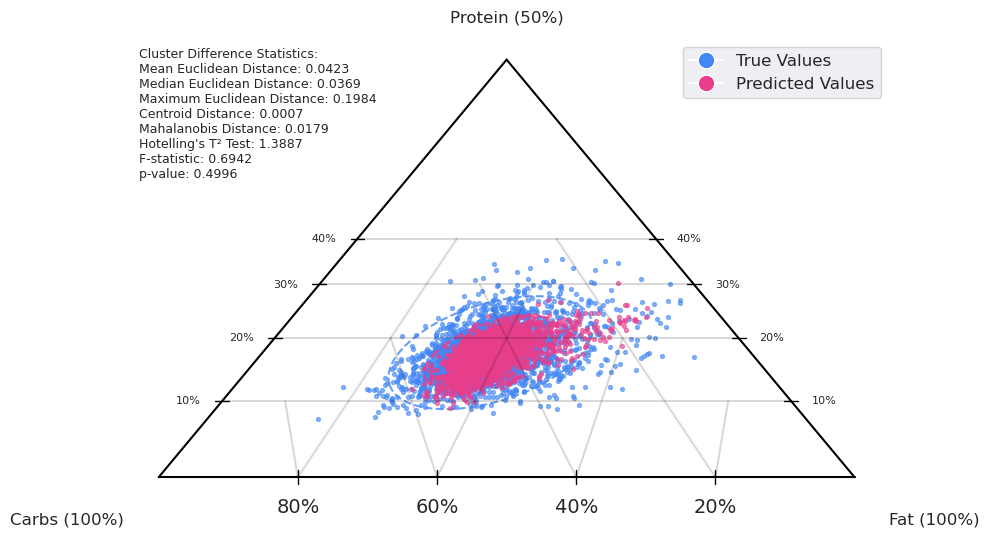

Ternary plot saved to /net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Figs_paper/ternary_plot_both.pdf


In [170]:
create_ternary_plot(protein_path, carbs_path, fat_path, show_both=True, output_path=figs_dir + 'ternary_plot_both.pdf', dot_size=8)

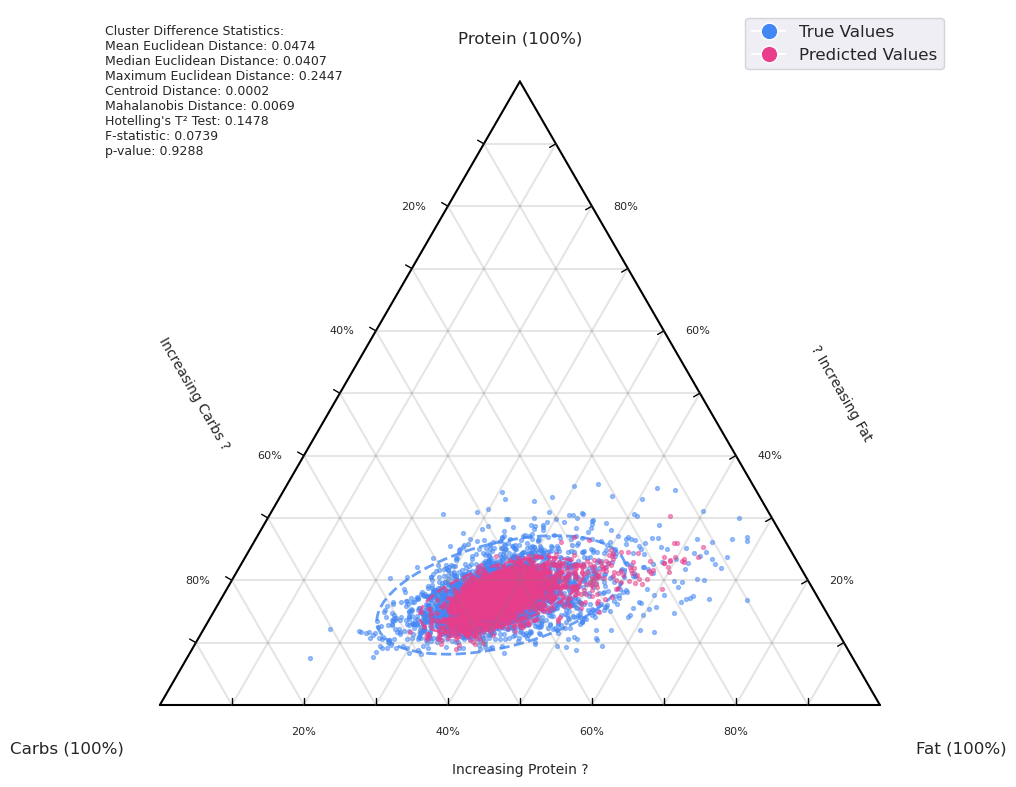

Classical ternary plot saved to /net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Figs_paper/classical_ternary_plot_1.pdf


In [171]:
prot_scale = 1
create_classical_ternary_plot(protein_path, carbs_path, fat_path, show_both=True, output_path=figs_dir + f'classical_ternary_plot_{prot_scale}.pdf', dot_size=8, protein_scale=prot_scale, alpha_val=0.5)

In [794]:
def create_ternary_plot_single_table(data_path, feature_names, labels_list=None, show_predictions=False, 
                        output_path='ternary_plot.png', dot_size=5, scale_factors=None, 
                        alpha_val=0.3, colors=None, legend_labels=None, color_column=None,
                        color_map='viridis', show_heatmap=False, heatmap_resolution=100,
                        heatmap_method='kde', heatmap_alpha=0.7, z_score_colors=False):
    """
    Creates a ternary plot of the population based on the distribution of three features.
    All three components range from 0% to 100% and should sum to 100%.
    
    Parameters:
    -----------
    data_path : str
        Path to the CSV or pickle file containing the dietary features
    feature_names : list
        List of three feature names to be used for the plot [feature1, feature2, feature3]
        These features will be placed at [top, bottom-left, bottom-right] positions
    labels_list : list, optional
        List of three labels for the triangle corners [top, bottom-left, bottom-right]
        If None, feature names will be used as labels
    show_predictions : bool, default=False
        If True, shows both 'true_values' and 'predictions' columns
        If False, only shows 'true_values'
    output_path : str, default='ternary_plot.png'
        Path where the output plot should be saved
    dot_size : int, default=5
        Size of the dots in the scatter plot
    scale_factors : list, optional
        List of scaling factors for each feature. Default is [1, 1, 1]
    alpha_val : float, default=0.3
        Transparency of the points
    colors : list, optional
        List of two colors for [true_values, predictions]. Default is ['#4287f5', '#e83e8c']
    legend_labels : list, optional
        List of strings to use as labels for the data points in the legend
        If None, will use ['True Values', 'Predicted Values']
    color_column : str, optional
        Column name to use for coloring the points. If provided, the 'colors' parameter is ignored
        for the true values (it's still used for predictions if shown)
    color_map : str, default='viridis'
        Colormap to use when color_column is specified. Any matplotlib colormap name is valid.
    show_heatmap : bool, default=False
        If True, adds a heatmap to the background of the ternary plot
    heatmap_resolution : int, default=100
        Resolution of the heatmap grid (higher values give smoother heatmaps)
    heatmap_method : str, default='kde'
        Method to create the heatmap: 'kde' (Kernel Density Estimation) or 'hexbin'
    heatmap_alpha : float, default=0.7
        Transparency of the heatmap
    z_score_colors : bool, default=False
        If True, applies z-score normalization to the color_column values before coloring
        
    Returns:
    --------
    None, but saves the plot to the specified output path and displays it
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.tri as tri
    import matplotlib.patches as patches
    from matplotlib.patches import Ellipse
    from scipy import stats
    import os
    from matplotlib.colors import Normalize
    from matplotlib import cm
    from scipy.stats import gaussian_kde
    
    # Validate inputs
    if len(feature_names) != 3:
        raise ValueError("feature_names must contain exactly three feature names")
    
    # Set default labels_list for triangle corners if not provided
    if labels_list is None:
        labels_list = feature_names
    elif len(labels_list) != 3:
        raise ValueError("labels_list must contain exactly three labels for triangle corners")
    
    # Set default legend_labels if not provided
    if legend_labels is None:
        legend_labels = ['True Values', 'Predicted Values']
    elif len(legend_labels) < 1:
        raise ValueError("legend_labels must contain at least one label")
    
    # Set default scale factors if not provided
    if scale_factors is None:
        scale_factors = [1, 1, 1]
    elif len(scale_factors) != 3:
        raise ValueError("scale_factors must contain exactly three values")
    
    # Set default colors if not provided
    if colors is None:
        colors = ['#4287f5', '#e83e8c']
    elif len(colors) != 2:
        raise ValueError("colors must contain exactly two colors")
    
    # Load the data based on file extension
    file_ext = os.path.splitext(data_path)[1].lower()
    if file_ext == '.csv':
        df = pd.read_csv(data_path)
    elif file_ext in ['.pkl', '.pickle']:
        df = pd.read_pickle(data_path)
    
    # Verify the feature names exist in the dataframe
    for feature in feature_names:
        if feature not in df.columns:
            raise ValueError(f"Feature '{feature}' not found in the dataframe")
    
    # Verify color column if provided
    if color_column is not None and color_column not in df.columns:
        raise ValueError(f"Color column '{color_column}' not found in the dataframe")
    
    # Create the ternary plot with white background
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
    ax.set_facecolor('white')
    plt.axis('off')  # Turn off standard axes
    
    # Set up the corners of the equilateral triangle
    # Standard equilateral triangle with height = sqrt(3)/2
    height = np.sqrt(3) / 2
    corners = np.array([
        [0.5, height],  # Top (feature1)
        [0, 0],         # Bottom Left (feature2)
        [1, 0]          # Bottom Right (feature3)
    ])
    
    # Function to convert from ternary coordinates to cartesian
    def ternary_to_cartesian(v1, v2, v3):
        # Ensure the inputs sum to 100 (or close to it)
        total = v1 + v2 + v3
        if not np.isclose(total, 100, rtol=0.1):
            # Normalize to ensure they sum to 100
            v1 = (v1 / total) * 100
            v2 = (v2 / total) * 100
            v3 = (v3 / total) * 100
        
        # Convert to fractions (0-1)
        v1_frac = v1 / 100
        v2_frac = v2 / 100
        v3_frac = v3 / 100
        
        # Convert to cartesian coordinates using barycentric coordinates
        x = corners[0, 0] * v1_frac + corners[1, 0] * v2_frac + corners[2, 0] * v3_frac
        y = corners[0, 1] * v1_frac + corners[1, 1] * v2_frac + corners[2, 1] * v3_frac
        return x, y
    
    # Process true values
    # Extract the values and apply scale factors
    feature1_true = df[feature_names[0]].values * scale_factors[0]
    feature2_true = df[feature_names[1]].values * scale_factors[1]
    feature3_true = df[feature_names[2]].values * scale_factors[2]
    
    # Check if the values sum to approximately 100
    sums_true = feature1_true + feature2_true + feature3_true
    
    # If the values don't sum to approximately 100, normalize them
    if not np.allclose(sums_true, 100, rtol=0.1):
        # Check if they might be in decimal form (summing to 1)
        if np.allclose(sums_true, 1, rtol=0.1):
            # Convert to percentages
            feature1_true *= 100
            feature2_true *= 100
            feature3_true *= 100
        else:
            # Normalize to ensure they sum to 100
            feature1_true = (feature1_true / sums_true) * 100
            feature2_true = (feature2_true / sums_true) * 100
            feature3_true = (feature3_true / sums_true) * 100
    
    # Convert true values to cartesian coordinates
    x_true = []
    y_true = []
    for v1, v2, v3 in zip(feature1_true, feature2_true, feature3_true):
        x, y = ternary_to_cartesian(v1, v2, v3)
        x_true.append(x)
        y_true.append(y)
    
    # Convert to numpy arrays for later use
    x_true_array = np.array(x_true)
    y_true_array = np.array(y_true)
    
    # Add heatmap if requested
    if show_heatmap:
        if heatmap_method == 'kde':
            # Create a grid of points covering the ternary plot
            xx, yy = np.meshgrid(np.linspace(0, 1, heatmap_resolution), 
                               np.linspace(0, height, heatmap_resolution))
            
            # Flatten the grid for evaluation
            positions = np.vstack([xx.ravel(), yy.ravel()])
            
            # Filter out points outside the triangle
            valid_points = []
            for x, y in zip(positions[0], positions[1]):
                # Check if point is inside the triangle
                def is_in_triangle(x, y, corners):
                    def sign(p1, p2, p3):
                        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
                    
                    d1 = sign((x, y), corners[0], corners[1])
                    d2 = sign((x, y), corners[1], corners[2])
                    d3 = sign((x, y), corners[2], corners[0])
                    
                    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
                    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)
                    
                    return not (has_neg and has_pos)
                
                if is_in_triangle(x, y, corners):
                    valid_points.append((x, y))
            
            if valid_points:
                valid_positions = np.array(valid_points).T
                
                # Create kernel density estimate
                values = np.vstack([x_true_array, y_true_array])
                kernel = gaussian_kde(values)
                
                # Evaluate kernel on grid
                z = kernel(valid_positions)
                
                # Reshape z for contourf
                tri = tri.Triangulation(valid_positions[0], valid_positions[1])
                
                # Plot the heatmap using tricontourf
                cmap = plt.cm.get_cmap(color_map)
                heatmap = ax.tricontourf(tri, z, cmap=cmap, alpha=heatmap_alpha, levels=50)
                
                # Add colorbar
                cbar = plt.colorbar(heatmap, ax=ax, pad=0.05)
                cbar.set_label('Density', rotation=270, labelpad=20)
        
        elif heatmap_method == 'hexbin':
            # Use hexbin for the heatmap
            hb = ax.hexbin(x_true_array, y_true_array, gridsize=heatmap_resolution//5, 
                         cmap=color_map, alpha=heatmap_alpha, mincnt=1)
            
            # Add colorbar
            cbar = plt.colorbar(hb, ax=ax, pad=0.05)
            cbar.set_label('Count', rotation=270, labelpad=20)
    
    # Plot true values with color based on color_column if provided
    if color_column is not None:
        # Get values for coloring
        color_values = df[color_column].values
        
        # Apply z-score normalization if requested
        if z_score_colors:
            color_values = (color_values - np.mean(color_values)) / np.std(color_values)
            color_label = f"{color_column} (z-score)"
        else:
            color_label = color_column
        
        # Create a ScalarMappable for the colorbar
        norm = Normalize(vmin=np.min(color_values), vmax=np.max(color_values))
        cmap = plt.cm.get_cmap(color_map)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        
        # Plot points with color from the column
        scatter = ax.scatter(x_true_array, y_true_array, 
                           c=color_values, cmap=color_map, 
                           alpha=alpha_val, s=dot_size, 
                           norm=norm)
        
        # Add colorbar if not already added by heatmap
        if not show_heatmap:
            cbar = plt.colorbar(sm, ax=ax, pad=0.05)
            cbar.set_label(color_label, rotation=270, labelpad=20)
    else:
        # Plot true values with single color
        ax.scatter(x_true_array, y_true_array, alpha=alpha_val, s=dot_size, color=colors[0], label=legend_labels[0])
    
    # Add 95% confidence ellipse for true values
    if len(x_true) > 2:  # Need at least 3 points for covariance
        # Calculate mean and covariance
        mean_x_true = np.mean(x_true_array)
        mean_y_true = np.mean(y_true_array)
        cov_true = np.cov(x_true_array, y_true_array)
        
        # Calculate eigenvalues and eigenvectors
        eigenvalues_true, eigenvectors_true = np.linalg.eigh(cov_true)
        
        # Calculate chi-square value for 95% confidence (2 degrees of freedom)
        chisquare_val = stats.chi2.ppf(0.95, 2)
        
        # Calculate ellipse properties
        theta_true = np.degrees(np.arctan2(eigenvectors_true[1, 0], eigenvectors_true[0, 0]))
        width_true = 2 * np.sqrt(chisquare_val * eigenvalues_true[0])
        height_true = 2 * np.sqrt(chisquare_val * eigenvalues_true[1])
        
        # Draw ellipse with dashed line
        ellipse_true = Ellipse((mean_x_true, mean_y_true),
                             width_true, height_true,
                             angle=theta_true,
                             facecolor='none',
                             edgecolor=colors[0] if color_column is None else 'black',
                             linewidth=2,
                             linestyle='--',
                             alpha=0.8)
        ax.add_patch(ellipse_true)
    
    # Process prediction values if needed
    if show_predictions and 'predictions' in df.columns:
        # Get column names for predictions
        pred_columns = [col for col in df.columns if col.startswith('pred_')]
        
        if len(pred_columns) >= 3:
            # Extract prediction values and apply scale factors
            feature1_pred = df[pred_columns[0]].values * scale_factors[0]
            feature2_pred = df[pred_columns[1]].values * scale_factors[1]
            feature3_pred = df[pred_columns[2]].values * scale_factors[2]
            
            # Check if the values sum to approximately 100
            sums_pred = feature1_pred + feature2_pred + feature3_pred
            
            # If the values don't sum to approximately 100, normalize them
            if not np.allclose(sums_pred, 100, rtol=0.1):
                # Check if they might be in decimal form (summing to 1)
                if np.allclose(sums_pred, 1, rtol=0.1):
                    # Convert to percentages
                    feature1_pred *= 100
                    feature2_pred *= 100
                    feature3_pred *= 100
                else:
                    # Normalize to ensure they sum to 100
                    feature1_pred = (feature1_pred / sums_pred) * 100
                    feature2_pred = (feature2_pred / sums_pred) * 100
                    feature3_pred = (feature3_pred / sums_pred) * 100
            
            # Convert predicted values to cartesian coordinates
            x_pred = []
            y_pred = []
            for v1, v2, v3 in zip(feature1_pred, feature2_pred, feature3_pred):
                x, y = ternary_to_cartesian(v1, v2, v3)
                x_pred.append(x)
                y_pred.append(y)
            
            # Convert to numpy arrays
            x_pred_array = np.array(x_pred)
            y_pred_array = np.array(y_pred)
            
            # Plot predicted values
            ax.scatter(x_pred_array, y_pred_array, alpha=alpha_val, s=dot_size, color=colors[1], 
                     label=legend_labels[1] if len(legend_labels) > 1 else 'Predicted Values')
            
            # Add 95% confidence ellipse for predicted values
            if len(x_pred) > 2:  # Need at least 3 points for covariance
                # Calculate mean and covariance
                mean_x_pred = np.mean(x_pred_array)
                mean_y_pred = np.mean(y_pred_array)
                cov_pred = np.cov(x_pred_array, y_pred_array)
                
                # Calculate eigenvalues and eigenvectors
                eigenvalues_pred, eigenvectors_pred = np.linalg.eigh(cov_pred)
                
                # Calculate chi-square value for 95% confidence (2 degrees of freedom)
                chisquare_val = stats.chi2.ppf(0.95, 2)
                
                # Calculate ellipse properties
                theta_pred = np.degrees(np.arctan2(eigenvectors_pred[1, 0], eigenvectors_pred[0, 0]))
                width_pred = 2 * np.sqrt(chisquare_val * eigenvalues_pred[0])
                height_pred = 2 * np.sqrt(chisquare_val * eigenvalues_pred[1])
                
                # Draw ellipse with dashed line
                ellipse_pred = Ellipse((mean_x_pred, mean_y_pred),
                                    width_pred, height_pred,
                                    angle=theta_pred,
                                    facecolor='none',
                                    edgecolor=colors[1],
                                    linewidth=2,
                                    linestyle='--',
                                    alpha=0.8)
                ax.add_patch(ellipse_pred)
            
            # Calculate statistical differences between true and predicted values
            # Calculate Euclidean distances between paired points
            euclidean_distances = np.sqrt((x_true_array - x_pred_array)**2 + (y_true_array - y_pred_array)**2)
            mean_distance = np.mean(euclidean_distances)
            median_distance = np.median(euclidean_distances)
            max_distance = np.max(euclidean_distances)
            
            # Calculate centroid distance
            centroid_true = (np.mean(x_true_array), np.mean(y_true_array))
            centroid_pred = (np.mean(x_pred_array), np.mean(y_pred_array))
            centroid_distance = np.sqrt((centroid_true[0] - centroid_pred[0])**2 + 
                                      (centroid_true[1] - centroid_pred[1])**2)
            
            # Calculate Mahalanobis distance between centroids
            # First, we need the pooled covariance matrix
            if len(x_true) > 2 and len(x_pred) > 2:
                cov_true = np.cov(x_true_array, y_true_array)
                cov_pred = np.cov(x_pred_array, y_pred_array)
                n_true = len(x_true)
                n_pred = len(x_pred)
                
                # Pooled covariance matrix
                pooled_cov = ((n_true - 1) * cov_true + (n_pred - 1) * cov_pred) / (n_true + n_pred - 2)
                
                try:
                    # Calculate inverse of covariance matrix
                    inv_pooled_cov = np.linalg.inv(pooled_cov)
                    
                    # Calculate difference between centroids
                    diff = np.array([centroid_true[0] - centroid_pred[0], centroid_true[1] - centroid_pred[1]])
                    
                    # Calculate Mahalanobis distance
                    mahalanobis_distance = np.sqrt(diff.T.dot(inv_pooled_cov).dot(diff))
                except np.linalg.LinAlgError:
                    # Handle case where covariance matrix is singular
                    mahalanobis_distance = np.nan
            else:
                mahalanobis_distance = np.nan
            
            # Paired Hotelling's T-squared test equivalent
            if len(x_true) > 2:
                # Calculate differences
                diff_x = x_true_array - x_pred_array
                diff_y = y_true_array - y_pred_array
                
                # Mean differences
                mean_diff_x = np.mean(diff_x)
                mean_diff_y = np.mean(diff_y)
                
                # Covariance of differences
                cov_diff = np.cov(diff_x, diff_y)
                
                try:
                    # Calculate inverse of covariance matrix
                    inv_cov_diff = np.linalg.inv(cov_diff)
                    
                    # Calculate Hotelling's T-squared
                    n = len(x_true)
                    mean_diff = np.array([mean_diff_x, mean_diff_y])
                    hotelling_t2 = n * mean_diff.T.dot(inv_cov_diff).dot(mean_diff)
                    
                    # Convert to F-statistic
                    p = 2  # dimensionality
                    f_stat = ((n - p) / (p * (n - 1))) * hotelling_t2
                    
                    # Calculate p-value
                    from scipy.stats import f
                    p_value = 1 - f.cdf(f_stat, p, n - p)
                except np.linalg.LinAlgError:
                    # Handle case where covariance matrix is singular
                    hotelling_t2 = np.nan
                    f_stat = np.nan
                    p_value = np.nan
            else:
                hotelling_t2 = np.nan
                f_stat = np.nan
                p_value = np.nan
                
            # Add statistics as text annotation
            stats_text = (
                f"Cluster Difference Statistics:\n"
                f"Mean Euclidean Distance: {mean_distance:.4f}\n"
                f"Median Euclidean Distance: {median_distance:.4f}\n"
                f"Maximum Euclidean Distance: {max_distance:.4f}\n"
                f"Centroid Distance: {centroid_distance:.4f}\n"
                f"Mahalanobis Distance: {mahalanobis_distance:.4f}\n"
                f"Hotelling's T² Test: {hotelling_t2:.4f}\n"
                f"F-statistic: {f_stat:.4f}\n"
                f"p-value: {p_value:.4f}"
            )
            
            # Position the text box in the upper left corner
            props = dict(boxstyle='round', facecolor='white', alpha=0.7)
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
                  verticalalignment='top', bbox=props)
    
    # Draw the triangle outline
    ax.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], 'k-', linewidth=1.5)
    ax.plot([corners[1, 0], corners[2, 0]], [corners[1, 1], corners[2, 1]], 'k-', linewidth=1.5)
    ax.plot([corners[2, 0], corners[0, 0]], [corners[2, 1], corners[0, 1]], 'k-', linewidth=1.5)
    
    # Add labels at the corners
    ax.text(corners[0][0], corners[0][1] + 0.05, f"{labels_list[0]} (100%)", fontsize=16, ha='center', va='bottom')
    ax.text(corners[1][0] - 0.05, corners[1][1] - 0.05, f"{labels_list[1]} (100%)", fontsize=16, ha='right', va='top')
    ax.text(corners[2][0] + 0.05, corners[2][1] - 0.05, f"{labels_list[2]} (100%)", fontsize=16, ha='left', va='top')
    
    # Create grid lines
    grid_step = 10  # Grid lines every 10%
    grid_alpha = 0.2
    
    # Function to draw a grid line of constant value for a specific component
    def draw_grid_line(component_idx, value):
        if component_idx == 0:  # Top vertex (feature1)
            # Lines of constant feature1 percentage
            p1 = ternary_to_cartesian(value, 100-value, 0)
            p2 = ternary_to_cartesian(value, 0, 100-value)
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray', alpha=grid_alpha)
        elif component_idx == 1:  # Bottom left vertex (feature2)
            # Lines of constant feature2 percentage
            p1 = ternary_to_cartesian(100-value, value, 0)
            p2 = ternary_to_cartesian(0, value, 100-value)
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray', alpha=grid_alpha)
        elif component_idx == 2:  # Bottom right vertex (feature3)
            # Lines of constant feature3 percentage
            p1 = ternary_to_cartesian(100-value, 0, value)
            p2 = ternary_to_cartesian(0, 100-value, value)
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'gray', alpha=grid_alpha)
    
    # Draw grid lines
    for value in range(grid_step, 100, grid_step):
        draw_grid_line(0, value)
        draw_grid_line(1, value)
        draw_grid_line(2, value)
    
    # Add tick marks and labels along each edge
    tick_step = 10  # Every 10%
    tick_length = 0.01
    
    # Function to calculate tick positions
    def get_tick_positions(edge_start, edge_end, percentages):
        positions = []
        for p in percentages:
            # Calculate fraction (0 = edge_start, 1 = edge_end)
            fraction = p / 100
            # Interpolate between edge start and end points
            x = edge_start[0] + fraction * (edge_end[0] - edge_start[0])
            y = edge_start[1] + fraction * (edge_end[1] - edge_start[1])
            positions.append((x, y))
        return positions
    
    # Generate tick percentage values
    tick_percentages = list(range(0, 101, tick_step))
    
    # Calculate tick positions for each edge
    left_ticks = get_tick_positions(corners[1], corners[0], tick_percentages)  # Bottom left to top
    right_ticks = get_tick_positions(corners[2], corners[0], tick_percentages)  # Bottom right to top
    bottom_ticks = get_tick_positions(corners[1], corners[2], tick_percentages)  # Bottom left to right
    
    # Function to draw a tick mark and label
    def draw_tick(position, angle, label, text_offset_x, text_offset_y, ha='center', va='center'):
        # Draw tick mark
        dx = tick_length * np.cos(angle)
        dy = tick_length * np.sin(angle)
        ax.plot([position[0], position[0] + dx], [position[1], position[1] + dy], 'k-', lw=1)
        
        # Add label
        if label % 20 == 0 or label == 100:  # Only show every 20% to avoid crowding
            ax.text(position[0] + text_offset_x, position[1] + text_offset_y, 
                   f"{label}%", fontsize=14, ha=ha, va=va)
    
    # Draw ticks along left edge (feature2 axis) - REVERSED
    left_angle = np.arctan2(corners[0, 1] - corners[1, 1], corners[0, 0] - corners[1, 0]) + np.pi/2
    for i, pos in enumerate(left_ticks):
        # Skip endpoints
        if i == 0 or i == len(left_ticks) - 1:
            continue
        # Reverse the percentage (100 - percentage) for the left edge
        percentage = 100 - tick_percentages[i]
        draw_tick(pos, left_angle, percentage, -0.03, 0, ha='right', va='center')
    
    # Draw ticks along right edge (feature3 axis)
    right_angle = np.arctan2(corners[0, 1] - corners[2, 1], corners[0, 0] - corners[2, 0]) + np.pi/2
    for i, pos in enumerate(right_ticks):
        # Skip endpoints
        if i == 0 or i == len(right_ticks) - 1:
            continue
        percentage = tick_percentages[i]
        draw_tick(pos, right_angle, percentage, 0.03, 0, ha='left', va='center')
    
    # Draw ticks along bottom edge (feature1 axis)
    bottom_angle = np.arctan2(corners[2, 1] - corners[1, 1], corners[2, 0] - corners[1, 0]) + np.pi/2
    for i, pos in enumerate(bottom_ticks):
        # Skip endpoints
        if i == 0 or i == len(bottom_ticks) - 1:
            continue
        percentage = tick_percentages[i]
        draw_tick(pos, right_angle, percentage, 0.03, 0, ha='left', va='center')
    
    # Draw ticks along bottom edge (feature1 axis)
    bottom_angle = np.arctan2(corners[2, 1] - corners[1, 1], corners[2, 0] - corners[1, 0]) + np.pi/2
    for i, pos in enumerate(bottom_ticks):
        # Skip endpoints
        if i == 0 or i == len(bottom_ticks) - 1:
            continue
        percentage = tick_percentages[i]
        draw_tick(pos, bottom_angle, percentage, 0, -0.03, ha='center', va='top')
    
    # No directional labels on edges as requested
    
    # Add legend with bigger dots
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], 
               label=legend_labels[0], markersize=int(dot_size*1.5)),
    ]
    
    if show_predictions:
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], 
                  label=legend_labels[1] if len(legend_labels) > 1 else 'Predicted Values', markersize=int(dot_size*1.5))
        )
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    # Set equal aspect ratio to ensure the triangle is equilateral
    ax.set_aspect('equal')
    
    # Set plot limits with a bit of padding
    padding = 0.1
    ax.set_xlim(-padding, 1 + padding)
    ax.set_ylim(-padding, height + padding)
    
    # Add a title with the features being plotted
    plt.title(f"Ternary Plot of {', '.join(labels_list)}", fontsize=14)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    
    # Show the plot
    plt.show()
    
    print(f"Ternary plot saved to {output_path}")

In [769]:
diet_features_path = '/net/mraid20/export/genie/LabData/Analyses/tomerse/david_colab/diet_features.pkl'

/tmp/ipykernel_76940/345660555.py:255: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map)


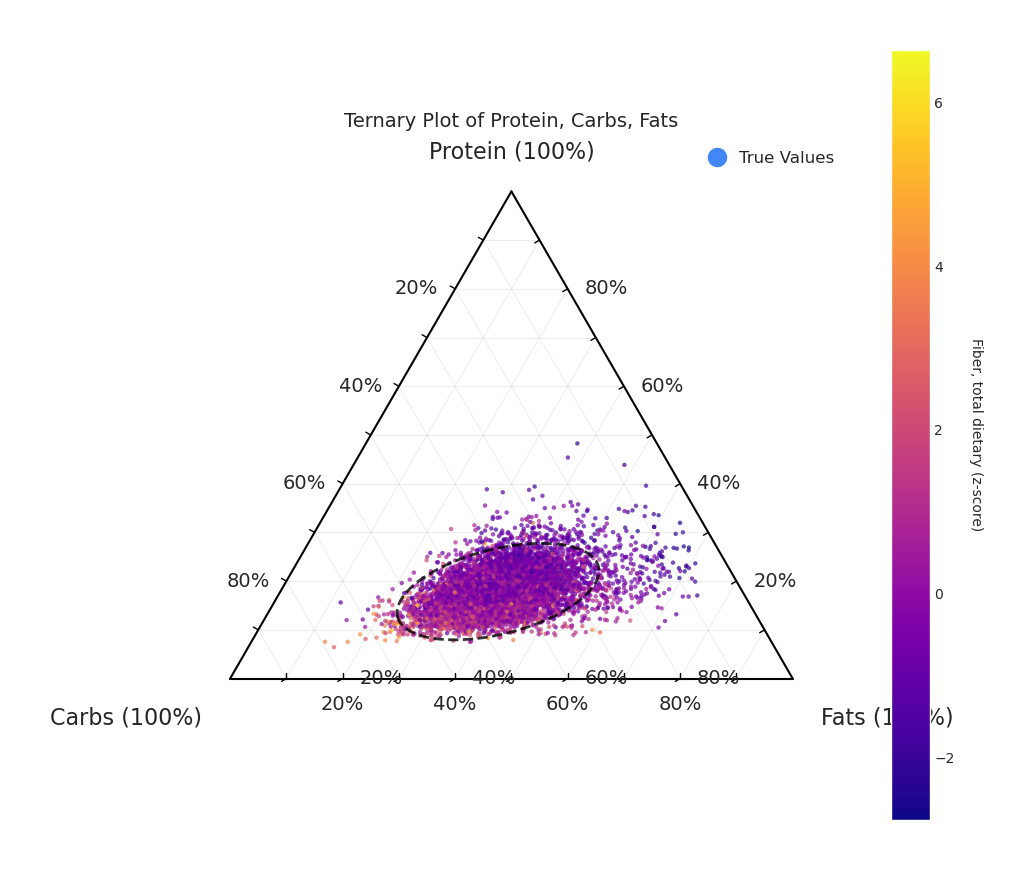

Ternary plot saved to /net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Figs_paper/ternary_plot_single_table_new_heat_map.pdf


In [807]:
create_ternary_plot_single_table(diet_features_path, ['pct_protein_calories', 'pct_carb_calories', 'pct_fat_calories'],
                                    labels_list=['Protein', 'Carbs', 'Fats'], color_column='Fiber, total dietary',show_predictions=False, output_path=figs_dir + 'ternary_plot_single_table_new_heat_map.pdf', dot_size=10, alpha_val=0.7, z_score_colors=True, color_map='plasma', heatmap_alpha=0.4, show_heatmap=False, heatmap_resolution=100, heatmap_method='hexbin')

In [184]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def create_binned_scatter_plot(file_path, true_col='true_values', pred_col='predictions', n_bins=10, 
                              figsize=(10, 8), swarm=True, max_swarm_points=1000,
                              equal_samples=True, median_marker='X'):
    """
    Create a binned scatter plot from a table of true values and predictions.
    
    Parameters:
    -----------
    file_path : str or Path
        Path to the file containing the data (CSV, Excel, etc.)
    true_col : str, default='true_values'
        Name of the column containing true values.
    pred_col : str, default='predictions'
        Name of the column containing predicted values.
    n_bins : int, default=10
        Number of bins to use for grouping true values.
    figsize : tuple, default=(10, 8)
        Figure size (width, height) in inches.
    swarm : bool, default=True
        Whether to show individual points as a swarm plot.
    max_swarm_points : int, default=1000
        Maximum number of points to show in the swarm plot (to avoid overcrowding).
    equal_samples : bool, default=True
        If True, create bins with equal sample sizes (quantile binning).
        If False, create bins with equal width ranges.
    median_marker : str, default='X'
        Marker style for the bin medians. Available options:
        'o': circle, 's': square, 'D': diamond, '^': triangle_up, 'v': triangle_down,
        '<': triangle_left, '>': triangle_right, 'p': pentagon, '*': star, 'h': hexagon1,
        'H': hexagon2, '+': plus, 'x': x, 'X': x_filled, 'd': thin_diamond, '|': vline,
        '_': hline, '.': point, ',': pixel
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plot.
    metrics : dict
        Dictionary of error metrics (MAE, RMSE, R²).
    bin_stats : pandas.DataFrame
        Statistics for each bin.
    """
    # Determine file type and read accordingly
    file_path = Path(file_path)
    if file_path.suffix.lower() == '.csv':
        df = pd.read_csv(file_path)
    elif file_path.suffix.lower() in ['.xlsx', '.xls']:
        df = pd.read_excel(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file_path.suffix}")
    
    # Check if columns exist
    if true_col not in df.columns:
        raise ValueError(f"True value column '{true_col}' not found in the data.")
    if pred_col not in df.columns:
        raise ValueError(f"Prediction column '{pred_col}' not found in the data.")
    
    # Clean data
    data = df[[true_col, pred_col]].copy()
    data.columns = ['true', 'pred']
    data = data.dropna()
    
    # Calculate metrics
    errors = data['pred'] - data['true']
    abs_errors = np.abs(errors)
    
    metrics = {
        'mae': np.mean(abs_errors),
        'rmse': np.sqrt(np.mean(errors ** 2)),
        'r2': 1 - (np.sum(errors ** 2) / np.sum((data['true'] - data['true'].mean()) ** 2))
    }
    
    # Create bins
    if equal_samples:
        # Equal sample size bins (quantile-based)
        bins = pd.qcut(data['true'], n_bins, duplicates='drop', labels=False)
        # Get bin edges for labeling
        bin_edges = pd.qcut(data['true'], n_bins, duplicates='drop', retbins=True)[1]
    else:
        # Equal width bins
        bins = pd.cut(data['true'], n_bins, labels=False)
        # Get bin edges for labeling
        bin_edges = pd.cut(data['true'], n_bins, retbins=True)[1]
    
    # Store bin assignment as numeric column (fixes the categorical issue)
    data['bin_id'] = bins
    
    # Create a mapping from bin_id to bin edges for visualization
    bin_info = {}
    for i in range(len(bin_edges)-1):
        bin_info[i] = {
            'left': bin_edges[i],
            'right': bin_edges[i+1],
            'center': (bin_edges[i] + bin_edges[i+1]) / 2
        }
    
    # Calculate bin statistics
    bin_stats = data.groupby('bin_id').agg({
        'true': 'median',
        'pred': 'median',
        'bin_id': 'count'
    }).rename(columns={'bin_id': 'count'}).reset_index()
    
    # Add bin boundaries to bin_stats from our bin_info mapping
    bin_stats['bin_left'] = bin_stats['bin_id'].map(lambda x: bin_info[x]['left'])
    bin_stats['bin_right'] = bin_stats['bin_id'].map(lambda x: bin_info[x]['right'])
    bin_stats['bin_center'] = bin_stats['bin_id'].map(lambda x: bin_info[x]['center'])
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Assign colors to bins
    unique_bins = sorted(data['bin_id'].unique())
    palette = sns.color_palette("husl", len(unique_bins))
    bin_colors = {b: palette[i] for i, b in enumerate(unique_bins)}
    
    # Plot swarm of individual points (with subsampling if needed)
    if swarm and len(data) > 0:
        if len(data) > max_swarm_points:
            # Stratified sampling to maintain bin proportions
            sampled_data = pd.DataFrame()
            for bin_val, group in data.groupby('bin_id'):
                bin_sample_size = max(1, int(max_swarm_points * len(group) / len(data)))
                sampled_data = pd.concat([
                    sampled_data, 
                    group.sample(min(bin_sample_size, len(group)), random_state=42)
                ])
        else:
            sampled_data = data
            
        # Add jitter to avoid overplotting within each bin
        for bin_val, bin_group in sampled_data.groupby('bin_id'):
            # Calculate bin width for jittering
            bin_width = bin_info[bin_val]['right'] - bin_info[bin_val]['left']
            
            # Create jitter
            jitter = np.random.uniform(-bin_width/4, bin_width/4, size=len(bin_group))
            true_jittered = bin_group['true'] + jitter
            
            # Plot points
            ax.scatter(
                true_jittered, 
                bin_group['pred'], 
                alpha=0.5, 
                s=20, 
                color=bin_colors[bin_val], 
                label=None
            )
    
    # Plot bin medians
    ax.scatter(
        bin_stats['true'], 
        bin_stats['pred'], 
        s=100, 
        color='black', 
        marker=median_marker,
        edgecolor='white', 
        linewidth=1, 
        zorder=5, 
        label='Bin Medians'
    )
    
    # Calculate median bin size for legend
    median_bin_size = int(bin_stats['count'].median())
    
    # Set tight limits around bin medians
    # Add a small padding of 5% of the range
    x_min = bin_stats['true'].min()
    x_max = bin_stats['true'].max()
    y_min = bin_stats['pred'].min()
    y_max = bin_stats['pred'].max()
    
    x_padding = 0.1 * (x_max - x_min)
    y_padding = 0.1 * (y_max - y_min)
    
    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    # Add labels and title
    title = 'Binned Scatter Plot of True vs Predicted Values'
    if equal_samples:
        title += ' (Equal Sample Size Bins)'
    else:
        title += ' (Equal Width Bins)'
    
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(title)
    
    # Add metrics annotation
    metrics_text = (f"MAE: {metrics['mae']:.3f}\n"
                   f"RMSE: {metrics['rmse']:.3f}\n"
                   f"R²: {metrics['r2']:.3f}")
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
            verticalalignment='top', bbox=props)
    
    # Add legend
    if len(unique_bins) <= 10:  # Only add bin colors to legend if there aren't too many
        handles, labels = ax.get_legend_handles_labels()
        # Add median bin size to the bin medians label
        if handles and labels:
            # Update the first label (Bin Medians) to include median bin size
            labels[0] = f"Bin Medians (median n={median_bin_size})"
            
        if swarm:
            for i, bin_val in enumerate(unique_bins):
                bin_left = bin_info[bin_val]['left']
                bin_right = bin_info[bin_val]['right']
                bin_label = f"Bin {i+1}: [{bin_left:.3f}, {bin_right:.3f})"
                handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                         markerfacecolor=bin_colors[bin_val], markersize=8))
                labels.append(bin_label)
        ax.legend(handles, labels, loc='best', framealpha=0.7)
    else:
        ax.legend(loc='top right', framealpha=0.7)
    
    plt.tight_layout()
    return fig, metrics, bin_stats

In [281]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def create_binned_lollipop_plot(file_path, true_col='true_values', pred_col='predictions', n_bins=10, 
                              figsize=(6, 5), show_points=True, max_points=1000,
                              equal_samples=True, median_marker='o', lollipop_width=2,
                              lollipop_color='black', lollipop_alpha=0.8):
    """
    Create a binned scatter plot with lollipops extending from the x-axis to each bin median.
    
    Parameters:
    -----------
    file_path : str or Path
        Path to the file containing the data (CSV, Excel, etc.)
    true_col : str, default='true_values'
        Name of the column containing true values.
    pred_col : str, default='predictions'
        Name of the column containing predicted values.
    n_bins : int, default=10
        Number of bins to use for grouping true values.
    figsize : tuple, default=(10, 8)
        Figure size (width, height) in inches.
    show_points : bool, default=True
        Whether to show individual data points in addition to the lollipops.
    max_points : int, default=1000
        Maximum number of individual points to show (to avoid overcrowding).
    equal_samples : bool, default=True
        If True, create bins with equal sample sizes (quantile binning).
        If False, create bins with equal width ranges.
    median_marker : str, default='o'
        Marker style for the bin medians at the top of the lollipops.
    lollipop_width : float, default=2
        Width of the lollipop stems.
    lollipop_color : str, default='black'
        Color of the lollipop stems and markers.
    lollipop_alpha : float, default=0.8
        Transparency of the lollipops.
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plot.
    metrics : dict
        Dictionary of error metrics (MAE, RMSE, R²).
    bin_stats : pandas.DataFrame
        Statistics for each bin.
    """
    # Determine file type and read accordingly
    file_path = Path(file_path)
    if file_path.suffix.lower() == '.csv':
        df = pd.read_csv(file_path)
    elif file_path.suffix.lower() in ['.xlsx', '.xls']:
        df = pd.read_excel(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file_path.suffix}")
    
    # Check if columns exist
    if true_col not in df.columns:
        raise ValueError(f"True value column '{true_col}' not found in the data.")
    if pred_col not in df.columns:
        raise ValueError(f"Prediction column '{pred_col}' not found in the data.")
    
    # Clean data
    data = df[[true_col, pred_col]].copy()
    data.columns = ['true', 'pred']
    data = data.dropna()
    
    # Calculate metrics
    errors = data['pred'] - data['true']
    abs_errors = np.abs(errors)
    
    metrics = {
        'mae': np.mean(abs_errors),
        'rmse': np.sqrt(np.mean(errors ** 2)),
        'r2': 1 - (np.sum(errors ** 2) / np.sum((data['true'] - data['true'].mean()) ** 2))
    }
    
    # Create bins
    if equal_samples:
        # Equal sample size bins (quantile-based)
        bins = pd.qcut(data['true'], n_bins, duplicates='drop', labels=False)
        # Get bin edges for labeling
        bin_edges = pd.qcut(data['true'], n_bins, duplicates='drop', retbins=True)[1]
    else:
        # Equal width bins
        bins = pd.cut(data['true'], n_bins, labels=False)
        # Get bin edges for labeling
        bin_edges = pd.cut(data['true'], n_bins, retbins=True)[1]
    
    # Store bin assignment as numeric column
    data['bin_id'] = bins
    
    # Create a mapping from bin_id to bin edges for visualization
    bin_info = {}
    for i in range(len(bin_edges)-1):
        bin_info[i] = {
            'left': bin_edges[i],
            'right': bin_edges[i+1],
            'center': (bin_edges[i] + bin_edges[i+1]) / 2
        }
    
    # Calculate bin statistics
    bin_stats = data.groupby('bin_id').agg({
        'true': 'median',
        'pred': 'median',
        'bin_id': 'count'
    }).rename(columns={'bin_id': 'count'}).reset_index()
    
    # Add bin boundaries to bin_stats from our bin_info mapping
    bin_stats['bin_left'] = bin_stats['bin_id'].map(lambda x: bin_info[x]['left'])
    bin_stats['bin_right'] = bin_stats['bin_id'].map(lambda x: bin_info[x]['right'])
    bin_stats['bin_center'] = bin_stats['bin_id'].map(lambda x: bin_info[x]['center'])
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Assign colors to bins
    unique_bins = sorted(data['bin_id'].unique())
    palette = sns.color_palette("husl", len(unique_bins))
    bin_colors = {b: palette[i] for i, b in enumerate(unique_bins)}
    
    # Plot individual points (with subsampling if needed)
    if show_points and len(data) > 0:
        if len(data) > max_points:
            # Stratified sampling to maintain bin proportions
            sampled_data = pd.DataFrame()
            for bin_val, group in data.groupby('bin_id'):
                bin_sample_size = max(1, int(max_points * len(group) / len(data)))
                sampled_data = pd.concat([
                    sampled_data, 
                    group.sample(min(bin_sample_size, len(group)), random_state=42)
                ])
        else:
            sampled_data = data
            
        # Add jitter to avoid overplotting within each bin
        for bin_val, bin_group in sampled_data.groupby('bin_id'):
            # Calculate bin width for jittering
            bin_width = bin_info[bin_val]['right'] - bin_info[bin_val]['left']
            
            # Create jitter
            jitter = np.random.uniform(-bin_width/4, bin_width/4, size=len(bin_group))
            true_jittered = bin_group['true'] + jitter
            
            # Plot points
            ax.scatter(
                true_jittered, 
                bin_group['pred'], 
                alpha=0.4, 
                s=20, 
                color=bin_colors[bin_val], 
                label=None
            )
    
    # Plot lollipops for bin medians
    for _, row in bin_stats.iterrows():
        # Vertical line from x-axis to the bin median
        ax.plot(
            [row['true'], row['true']], 
            [0, row['pred']], 
            '-', 
            color=lollipop_color,
            alpha=lollipop_alpha,
            linewidth=lollipop_width,
            zorder=4
        )
        
        # Marker at the top of the lollipop
        ax.scatter(
            row['true'], 
            row['pred'], 
            s=120, 
            color=lollipop_color,
            marker=median_marker,
            edgecolor='white', 
            linewidth=1, 
            zorder=5, 
            alpha=lollipop_alpha
        )
    
    # Calculate median bin size for legend
    median_bin_size = int(bin_stats['count'].median())
    
    # Set tight limits around bin medians
    # Add a small padding of 5% of the range
    x_min = bin_stats['true'].min()
    x_max = bin_stats['true'].max()
    y_min = bin_stats['pred'].min()
    y_max = bin_stats['pred'].max()
    
    x_padding = 0.1 * (x_max - x_min)
    y_padding = 0.1 * (y_max - y_min)
    
    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    # # Add labels and title
    # title = 'Binned Lollipop Plot of True vs Predicted Values'
    # if equal_samples:
    #     title += ' (Equal Sample Size Bins)'
    # else:
    #     title += ' (Equal Width Bins)'
    
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    # ax.set_title(title)
    
    # Add metrics annotation
    metrics_text = (f"MAE: {metrics['mae']:.3f}\n"
                   f"RMSE: {metrics['rmse']:.3f}\n"
                   f"R²: {metrics['r2']:.3f}")
    
    # Define box properties with alpha for transparency
    box_props = dict(
        boxstyle='round',
        facecolor='white',
        alpha=0.7,  # Adjust this value (0-1) to control transparency
        pad=0.5,    # Padding inside the box
        edgecolor='gray'  # Add a border
    )
    
    # Position the text box at the top center of the plot
    # Using figure coordinates instead of axis coordinates
    ax.text(
        # 0.7, 0.3, metrics_text, 
        0.1, 0.7, metrics_text, 
            transform=ax.transAxes,
            horizontalalignment='left',
            verticalalignment='top', 
            bbox=box_props,
            fontsize=10)
    
    # Add bin info to the legend
    handles = []
    labels = []
    
    # Add lollipop to legend
    handles.append(plt.Line2D([0], [0], marker=median_marker, color=lollipop_color, 
                            markersize=10, markerfacecolor=lollipop_color, linestyle='-', alpha=lollipop_alpha,
                            label=f"Bin Medians (median n={median_bin_size})"))
    labels.append(f"Bin Medians (median n={median_bin_size})")
    
    # Add bin colors to legend if there aren't too many
    if len(unique_bins) <= 10 and show_points:
        for i, bin_val in enumerate(unique_bins):
            bin_left = bin_info[bin_val]['left']
            bin_right = bin_info[bin_val]['right']
            bin_label = f"Bin {i+1}: [{bin_left:.3f}, {bin_right:.3f})"
            handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                     markerfacecolor=bin_colors[bin_val], markersize=8))
            labels.append(bin_label)
    
    ax.legend(handles, labels, loc='best', framealpha=0.7)
    
    plt.tight_layout()
    return fig, metrics, bin_stats

In [282]:
diet_type = 'carnivore_score_per_day'
path_diff = diet_paper_dir_del + f'/Longitudinal/combined_ms_diet_w_diff/diff_diet_scores/results/{diet_type}/predictions_{diet_type}.csv'

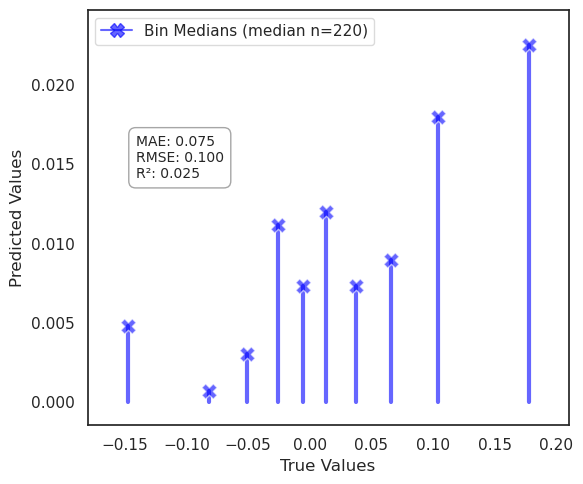

In [283]:
fig_bars, metrics_bars, bin_stats_bars = create_binned_lollipop_plot(path_diff, n_bins=10, equal_samples=True, median_marker='X', 
                                                                     show_points=False, lollipop_color='blue', lollipop_alpha=0.6, lollipop_width=3)
fig_bars.savefig(figs_dir + f'binned_lollipop_plot_{diet_type}_diff.png', dpi=300)

In [218]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def create_multi_binned_scatter_plot(diet_types=None, file_paths=None, base_path=None, 
                                    true_col='true_values', pred_col='predictions', n_bins=10,
                                    figsize=(12, 10), equal_samples=True, dataset_names=None, 
                                    markers=['X', 'o', 'D', '^', 's', 'p', '*', 'h', '+', 'v']):
    """
    Create a binned scatter plot from multiple diet type prediction datasets.
    
    Parameters:
    -----------
    diet_types : list of str, default=None
        List of diet types to process. If provided, file_paths will be constructed using base_path.
    file_paths : list of str or Path, default=None
        Paths to the files containing the data (CSV, Excel, etc.)
        Either diet_types or file_paths must be provided.
    base_path : str, default=None
        Base path template with {diet_type} placeholder.
        Example: '/path/to/results/{diet_type}/predictions_{diet_type}.csv'
        Required if diet_types is used.
    true_col : str, default='true_values'
        Name of the column containing true values.
    pred_col : str, default='predictions'
        Name of the column containing predicted values.
    n_bins : int, default=10
        Number of bins to use for grouping true values.
    figsize : tuple, default=(12, 10)
        Figure size (width, height) in inches.
    equal_samples : bool, default=True
        If True, create bins with equal sample sizes (quantile binning).
        If False, create bins with equal width ranges.
    dataset_names : list of str, default=None
        Names for each dataset. If None, will use diet types or filenames without extensions.
    markers : list of str, default=['X', 'o', 'D', '^', 's', 'p', '*', 'h', '+', 'v']
        Marker styles for the bin medians for each dataset.
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object containing the plot.
    metrics_list : list of dict
        List of dictionaries containing error metrics (MAE, RMSE, R²) for each dataset.
    bin_stats_list : list of pandas.DataFrame
        List of dataframes with statistics for each bin for each dataset.
    """
    # Handle file paths based on diet types or directly provided paths
    if diet_types is not None and base_path is not None:
        # Construct file paths from diet types
        file_paths = [base_path.format(diet_type=diet_type) for diet_type in diet_types]
        
        # Use diet types as dataset names if not provided
        if dataset_names is None:
            dataset_names = diet_types
    elif file_paths is not None:
        # Use provided file paths
        if dataset_names is None:
            # Extract filenames without extensions as dataset names
            dataset_names = [Path(path).stem for path in file_paths]
    else:
        raise ValueError("Either diet_types with base_path or file_paths must be provided")
    
    if not file_paths:
        raise ValueError("No file paths to process")
    
    if len(dataset_names) != len(file_paths):
        raise ValueError("Number of dataset names must match number of file paths")
    
    # Make sure we have enough markers for all datasets
    if len(markers) < len(file_paths):
        # Repeat markers if necessary
        markers = markers * (len(file_paths) // len(markers) + 1)
    
    # Create color palette for datasets
    dataset_palette = sns.color_palette("Dark2", len(file_paths))
    
    # Create figure with white background
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('white')  # Set the figure background to white
    ax.set_facecolor('white')  # Set the axis background to white
    
    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
    # Process each dataset
    all_data = []
    metrics_list = []
    bin_stats_list = []
    
    for i, (file_path, dataset_name, marker) in enumerate(zip(file_paths, dataset_names, markers)):
        # Process the file (similar to create_binned_scatter_plot)
        file_path = Path(file_path)
        if file_path.suffix.lower() == '.csv':
            df = pd.read_csv(file_path)
        elif file_path.suffix.lower() in ['.xlsx', '.xls']:
            df = pd.read_excel(file_path)
        else:
            raise ValueError(f"Unsupported file type: {file_path.suffix}")
        
        # Check if columns exist
        if true_col not in df.columns:
            raise ValueError(f"True value column '{true_col}' not found in {file_path}")
        if pred_col not in df.columns:
            raise ValueError(f"Prediction column '{pred_col}' not found in {file_path}")
        
        # Clean data
        data = df[[true_col, pred_col]].copy()
        data.columns = ['true', 'pred']
        data = data.dropna()
        
        # Add dataset identifier
        data['dataset'] = dataset_name
        all_data.append(data)
        
        # Calculate metrics
        errors = data['pred'] - data['true']
        abs_errors = np.abs(errors)
        
        metrics = {
            'dataset': dataset_name,
            'mae': np.mean(abs_errors),
            'rmse': np.sqrt(np.mean(errors ** 2)),
            'r2': 1 - (np.sum(errors ** 2) / np.sum((data['true'] - data['true'].mean()) ** 2))
        }
        metrics_list.append(metrics)
        
        # Create bins
        if equal_samples:
            # Equal sample size bins (quantile-based)
            bins = pd.qcut(data['true'], n_bins, duplicates='drop', labels=False)
            # Get bin edges for labeling
            bin_edges = pd.qcut(data['true'], n_bins, duplicates='drop', retbins=True)[1]
        else:
            # Equal width bins
            bins = pd.cut(data['true'], n_bins, labels=False)
            # Get bin edges for labeling
            bin_edges = pd.cut(data['true'], n_bins, retbins=True)[1]
        
        # Store bin assignment
        data['bin_id'] = bins
        
        # Create a mapping from bin_id to bin edges for visualization
        bin_info = {}
        for j in range(len(bin_edges)-1):
            bin_info[j] = {
                'left': bin_edges[j],
                'right': bin_edges[j+1],
                'center': (bin_edges[j] + bin_edges[j+1]) / 2
            }
        
        # Calculate bin statistics
        bin_stats = data.groupby('bin_id').agg({
            'true': 'median',
            'pred': 'median',
            'bin_id': 'count'
        }).rename(columns={'bin_id': 'count'}).reset_index()
        
        # Add bin boundaries to bin_stats from our bin_info mapping
        bin_stats['bin_left'] = bin_stats['bin_id'].map(lambda x: bin_info[x]['left'] if x in bin_info else None)
        bin_stats['bin_right'] = bin_stats['bin_id'].map(lambda x: bin_info[x]['right'] if x in bin_info else None)
        bin_stats['bin_center'] = bin_stats['bin_id'].map(lambda x: bin_info[x]['center'] if x in bin_info else None)
        bin_stats['dataset'] = dataset_name
        bin_stats_list.append(bin_stats)
        
        # No individual points plotting - removed swarm option
        
        # Simplify dataset name to first word after splitting by underscore
        display_name = dataset_name.split('_')[1] if '_' in dataset_name else dataset_name
        
        # Plot bin medians with dataset-specific color and marker
        ax.scatter(
            bin_stats['true'], 
            bin_stats['pred'], 
            s=100, 
            color=dataset_palette[i], 
            marker=marker,
            edgecolor='white', 
            linewidth=1, 
            zorder=5, 
            label=f"{display_name}"
        )
    
    # Combine all bin statistics for setting dynamic axis limits
    combined_bin_stats = pd.concat(bin_stats_list, ignore_index=True)
    
    # Set limits based on bin medians (not individual points)
    x_min = combined_bin_stats['true'].min()
    x_max = combined_bin_stats['true'].max()
    y_min = combined_bin_stats['pred'].min()
    y_max = combined_bin_stats['pred'].max()
    
    # Add padding proportional to the range
    x_padding = 0.05 * (x_max - x_min)
    y_padding = 0.05 * (y_max - y_min)
    
    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    
    # # Add labels and title
    # title = 'Multi-Dataset Binned Scatter Plot: True vs Predicted Values'
    # if equal_samples:
    #     title += ' (Equal Sample Size Bins)'
    # else:
    #     title += ' (Equal Width Bins)'
    
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    # ax.set_title(title)
    
    # Add metrics table as text
    metrics_text = "Metrics:\n"
    metrics_text += "Dataset".ljust(15) + "MAE".ljust(10) + "RMSE".ljust(10) + "R²\n"
    metrics_text += "-" * 40 + "\n"
    
    for metrics in metrics_list:
        # Simplify dataset name to first word after splitting by underscore
        display_name = metrics['dataset'].split('_')[1] if '_' in metrics['dataset'] else metrics['dataset']
        
        metrics_text += f"{display_name[:12]}...".ljust(15) if len(display_name) > 12 else f"{display_name}".ljust(15)
        metrics_text += f"{metrics['mae']:.3f}".ljust(10)
        metrics_text += f"{metrics['rmse']:.3f}".ljust(10)
        metrics_text += f"{metrics['r2']:.3f}\n"
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
            verticalalignment='top', bbox=props, fontfamily='monospace')
    
    # Add legend
    ax.legend(loc='lower right', framealpha=0.7)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return fig, metrics_list, bin_stats_list


In [194]:
diet_types = ['med_score_per_day', 'paleo_score_per_day', 'vegetarian_score_per_day', 'wfpb_score_per_day', 'vegan_score_per_day', 'carnivore_score_per_day']
file_paths = []
for diet_type in diet_types:
    path = f"{diet_paper_dir_del}/Longitudinal/combined_ms_diet_w_diff/diff_diet_scores/results/{diet_type}/predictions_{diet_type}.csv"
    file_paths.append(path)

In [ ]:
# create and save lollipop plot for each diet type and path
for diet_type, path in zip(diet_types, file_paths):
    fig, metrics, bin_stats = create_binned_lollipop_plot(path, n_bins=10, equal_samples=True, median_marker='X', show_points=False)
    fig.savefig(figs_dir + f'binned_lollipop_plot_{diet_type}_diff.png', dpi=300)

In [ ]:
fig, metrics, bin_stats_list = create_multi_binned_scatter_plot(
    file_paths=file_paths,
    true_col='true_values', 
    pred_col='predictions',
    n_bins=10,
    figsize=(12, 10),
    equal_samples=True,
    dataset_names=None,
    markers=['X', 'o', 'D', '^', 's', 'p', '*', 'h']
)
plt.savefig(figs_dir + '/diet_diffs_binned_predictions.png', dpi=300)
plt.show()